## **MENINGKATKAN PERFORMA DETEKSI RISIKO KREDIT DENGAN MENGGABUNGKAN PENDEKATAN MACHINE LEARNING DAN ANALISIS JARINGAN MELALUI FEATURE EMBEDDING BERBASIS GNN**




| Nama | NRP |
| ---- | ---- |
| Nathaniel Ryo Kurniadi | 5025221019 |
| Daffa Zimraan | 5025221223 |
| Muhammad Rafi Budi p| 5025221307 |

---

**Dini Adni Navastara, S.Kom, M.Sc.**


---

</br>

**Dataset**: <br>
https://www.kaggle.com/datasets/wordsforthewise/lending-club/data
<br>

**Model Building**: <br>
Artificial Neural Network (ANN), Extreme Gradient Boosting (XGboost), Random Forest (RF), Logistic Regression (LR), Ensemble dengan teknik Bagging

# **CRISP-DM**

Metodologi pengembangan model Menggunakan Cross Industry Standard Process for Data Mining

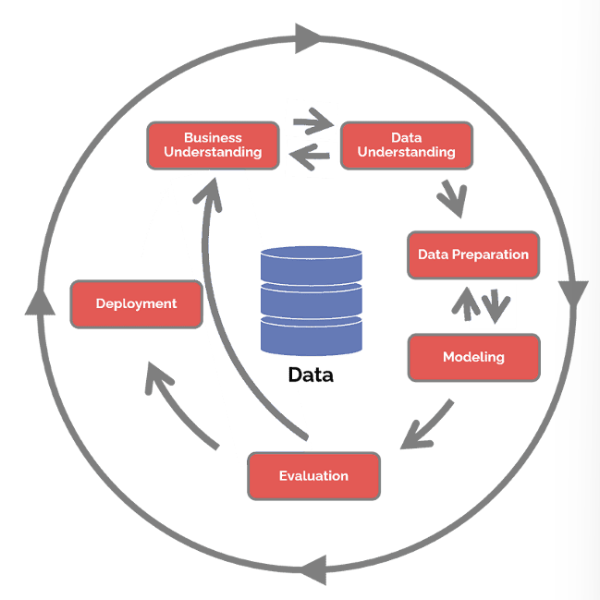

# **Import Library & Dataset**

In [2]:
# %pip install tensorflow
# %pip install kaggle
# %pip install networkx
# %pip install lightgbm 
# %pip install catboost 
# %pip install torch 
# %pip install torch-geometric

In [3]:
# import os
# import json
# cred = {"username":"nathanielryo","key":"a6af88b906ee9e800165dbaef8ed8bbd"}
# os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

# api_token = cred


# with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
#     json.dump(api_token, f)

In [4]:
# ! kaggle datasets download -d shriyashjagtap/fraudulent-e-commerce-transactions

In [5]:
# import zipfile

# with zipfile.ZipFile("fraudulent-e-commerce-transactions.zip", "r") as zip_ref:
#     zip_ref.extractall("fraud_dataset")

In [6]:
# =========================
# Basic Libraries
# =========================
import warnings
import math
warnings.filterwarnings('ignore')
from datetime import datetime
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from scipy import stats

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# =========================
# Preprocessing
# =========================
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    LabelEncoder,
    StandardScaler,
)
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler
from imblearn.combine import SMOTETomek

# =========================
# Model Selection & Evaluation
# =========================
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    RandomizedSearchCV,
)

from scipy.stats import randint, uniform

# =========================
# Machine Learning Models
# =========================
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# =========================
# Deep Learning (PyTorch & PyG)
# =========================
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import (
    GCNConv,
    SAGEConv,
    global_mean_pool,
)
from torch_geometric.loader import NeighborLoader


# =========================
# Deep Learning (TensorFlow / Keras)
# =========================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# **1. Business Understanding**

Penilaian risiko kredit merupakan proses penting bagi lembaga keuangan untuk meminimalkan potensi kerugian akibat gagal bayar, namun data peminjam modern berskala besar, kompleks, dan tidak seimbang sehingga model tradisional sering gagal mendeteksi peminjam berisiko tinggi, terutama karena tidak mampu menangkap hubungan relasional antar peminjam. Untuk menjawab kebutuhan tersebut, proyek ini mengembangkan model prediksi risiko kredit yang menggabungkan machine learning dengan feature embedding berbasis Graph Neural Network (GNN) agar mampu memanfaatkan baik informasi tabular maupun struktur hubungan dalam data sehingga prediksi menjadi lebih akurat, stabil, dan bermanfaat untuk pengambilan keputusan kredit.
<br /> <br />

**Tujuan** <br />
Proyek ini bertujuan untuk membangun mode machine learning yang dapat mengklasifikasi kemungkinkan gagal bayar peminjam secara lebih akurat dengan memanfaatkan representasi tabular dan graf dari dataset

# **2. Data Understanding**

## **Data Collection**

- Dataset diambil dari Kaggle: [All Lending Club loan data](https://www.kaggle.com/datasets/wordsforthewise/lending-club/data)
- Data berisi histori peminjaman customer Lending Club

## **Data Description**

Dikarenakan terdapat banyak sekali fitur (151) fitur dan terdapat fitur-fitur yang mendeskripsikan hal yang sama, maka fitur-fitur tersebut penulis bagikan menjadi 12 kategori utama agar konteks dataset dapat lebih mudah dipahami

| No | Kelompok Fitur                                | Anggota Fitur                                                                                                                                                                                                                              | Deskripsi                                                                                                                                                                   |
| -- | ---------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1  | Informasi Identitas & Metadata                 | id, member_id, url, desc, application_type, policy_code                                                                                                                                                                                      | Informasi untuk mengidentifikasi pinjaman, peminjam, dan metadata untuk keperluan administratif.                                                                           |
| 2  | Informasi Pinjaman                             | loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, purpose, title, disbursement_method                                                                                                                                   | Fitur yang menggambarkan detail pinjaman, seperti jumlah, tenor, cicilan, dan tujuan pinjaman.                                                                             |
| 3  | Status & Aktivitas Pembayaran                  | loan_status, pymnt_plan, total_pymnt, total_pymnt_inv, out_prncp, out_prncp_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, next_pymnt_d                       | Menunjukkan aktivitas pembayaran pinjaman terkini, jumlah cicilan yang telah dibayarkan, dan aktivitas penagihan.                                                          |
| 4  | Informasi Pendapatan & Pekerjaan               | emp_title, emp_length, annual_inc, verification_status, annual_inc_joint, verification_status_joint, dti, dti_joint                                                                                                                         | Menggambarkan kondisi ekonomi peminjam, seperti status pekerjaan, pendapatan per tahun, dan verifikasi data keuangan.                                                      |
| 5  | Informasi Lokasi                               | zip_code, addr_state                                                                                                                                                                                                                         | Menunjukkan lokasi peminjam.                                                                                                                                                |
| 6  | Informasi Kredit                               | earliest_cr_line, fico_range_low, fico_range_high, last_fico_range_low, last_fico_range_high, inq_last_6mths, inq_last_12m, open_acc, total_acc, pub_rec, delinq_2yrs, mths_since_last_delinq, mths_since_last_record, mths_since_recent_inq, pub_rec_bankruptcies, tax_liens | Rekam jejak kredit peminjam, seperti skor FICO, jumlah akun, riwayat keterlambatan, dan catatan publik yang relevan.                                                       |
| 7  | Utilization & Revolving Credit                 | revol_bal, revol_util, total_rev_hi_lim, num_rev_accts, num_rev_tl_bal_gt_0                                                                                                                                                                | Menjelaskan perilaku peminjam terkait penggunaan kredit bergulir seperti kartu kredit.                                                                                      |
| 8  | Informasi Pinjaman Terkait Angsuran & Aset     | mort_acc, total_bal_il, il_util, open_act_il, open_il_12m, open_il_24m, total_il_high_credit_limit                                                                                                                                         | Detil kredit angsuran dan aset terkait yang digunakan untuk melakukan evaluasi kemampuan peminjam untuk membayar.                                                           |
| 9  | Riwayat Aktivitas Kredit Lainnya               | num_bc_tl, num_bc_sats, num_il_tl, num_actv_bc_tl, num_sats, mo_sin_old_il_acct, mo_sin_rcnt_rev_tl_op, percent_bc_gt_75, pct_tl_nvr_dlq                                                           | Menggambarkan kebiasaan pengguna dalam menggunakan berbagai jenis kredit dalam jangka panjang maupun pendek.                                                                |
| 10 | Informasi Pasangan (Secondary Applicant)       | sec_app_fico_range_low, sec_app_fico_range_high, sec_app_earliest_cr_line, sec_app_open_acc, sec_app_revol_util                                                                                                                            | Fitur-fitur khusus untuk pinjaman bersama untuk menggambarkan kondisi kredit pasangan peminjam.                                                                            |
| 11 | Fitur Hardship (Keringanan Pembayaran)         | hardship_flag, hardship_type, hardship_status, hardship_start_date, hardship_end_date, hardship_amount                                                                                                                                      | Informasi apakah peminjam mendapatkan keringanan pembayaran karena kondisi finansial tertentu.                                                                              |
| 12 | Fitur Debt Settlement                          | debt_settlement_flag, settlement_status, settlement_amount, settlement_date, settlement_percentage, settlement_term                                                                                                                         | Menggambarkan apakah peminjam sudah mencapai kesepakatan jatuh tempo hutang dengan pemberi pinjaman.                                                                        |


## **Exploratory Data Analysis**

Untuk EDA dan proses training, kita akan menggunakan dataset dari csv `accepted_2007_to_2018Q4` yang mempunyai lebih dari 2 juta entri

### **Intro EDA**

Pertama, kita akan memuat dataset dan menampilkannya untuk memastikan bahwa dataset berhasil dimuat dengan benar.

In [7]:
df = pd.read_csv("./data/accepted_2007_to_2018Q4.csv")

In [8]:
pd.options.display.max_rows = 1000
df.shape

(2260701, 151)

Karena pada dataset mentah terdapat data dengan loan status `Current` yang berarti masih dalam proses pengembalian, maka yang di ambil hanya yang telah pinjaman yang sudah selesai.

In [9]:
completed_statuses = [
    'Fully Paid', 'Charged Off', 'Default', 
    'Late (31-120 days)', 'Late (16-30 days)',
    'Does not meet the credit policy. Status:Fully Paid',
    'Does not meet the credit policy. Status: Charged Off'
]
df = df[df['loan_status'].isin(completed_statuses)].copy()
print(f"Filtered to completed loans: {df.shape[0]:,} rows")

Filtered to completed loans: 1,373,154 rows


Untuk menyederhanakan berbagai label status pinjaman pada dataset mentah, kita melakukan konversi menjadi klasifikasi biner. Semua status yang menandakan pinjaman berhasil dilunasi dikategorikan sebagai 0 (tidak default), sedangkan status yang menunjukkan kegagalan bayar atau keterlambatan signifikan dikategorikan sebagai 1 (default). Proses ini dilakukan dengan memetakan setiap label asli ke dalam nilai 0 atau 1 seperti pada tabel pemetaan berikut.

In [10]:
target_map = {
    'Fully Paid': 0, 'Charged Off': 1, 'Default': 1, 
    'Late (31-120 days)': 1, 'Late (16-30 days)': 1, 
    'Does not meet the credit policy. Status:Fully Paid': 0,  
    'Does not meet the credit policy. Status: Charged Off': 1
}
temp_target = df['loan_status'].map(target_map)


In [11]:
status_map = {
    'Fully Paid': 0, 'Charged Off': 1, 'Default': 1, 
    'Late (31-120 days)': 1, 'Late (16-30 days)': 1,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Does not meet the credit policy. Status:Charged Off': 1
}
df['loan_status_binary'] = df['loan_status'].map(status_map).astype(int)


In [14]:
df.head().T

0  \
id                                                                                   68407277   
member_id                                                                                 NaN   
loan_amnt                                                                              3600.0   
funded_amnt                                                                            3600.0   
funded_amnt_inv                                                                        3600.0   
term                                                                                36 months   
int_rate                                                                                13.99   
installment                                                                            123.03   
grade                                                                                       C   
sub_grade                                                                                  C4   
emp_title                                                                             leadman   
emp_length                                                                          10+ years   
home_ownership                                                                       MORTGAGE   
annual_inc                                                                            55000.0   
verification_status                                                              Not Verified   
issue_d                                                                              Dec-2015   
loan_status                                                                        Fully Paid   
pymnt_plan                                                                                  n   
url                                         https://lendingclub.com/browse/loanDetail.acti...   
desc                                                                                      NaN   
purpose                                                                    debt_consolidation   
title                                                                      Debt consolidation   
zip_code                                                                                190xx   
addr_state                                                                                 PA   
dti                                                                                      5.91   
delinq_2yrs                                                                               0.0   
earliest_cr_line                                                                     Aug-2003   
fico_range_low                                                                          675.0   
fico_range_high                                                                         679.0   
inq_last_6mths                                                                            1.0   
mths_since_last_delinq                                                                   30.0   
mths_since_last_record                                                                    NaN   
open_acc                                                                                  7.0   
pub_rec                                                                                   0.0   
revol_bal                                                                              2765.0   
revol_util                                                                               29.7   
total_acc                                                                                13.0   
initial_list_status                                                                         w   
out_prncp                                                                                 0.0   
out_prncp_inv                                                                             0.0   
total_pymnt                                                                       4421.723917   
total_pymnt_inv   

Dari potongan data ini, terapat masalah yang dapat diidentifikasi, yaitu format data yang perlu diperbaiki, seperti pada kolom `term` yang seharusnya fitur numerik yang menunjukkan lama pinjaman menjadi tipe string seperti `36 months`. Hal yang sama dapat dilihat pada kolom `emp_length`.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1373154 entries, 0 to 2260697
Columns: 152 entries, id to loan_status_binary
dtypes: float64(113), int64(1), object(38)
memory usage: 1.6+ GB


dari >2 juta data pinjaman yang ada, tersisa 1.3 juta dengan 152 fitur karena penambahan fitur `loan_status_binary`

In [ ]:
df.isnull().sum()
missing_count = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    "missing_count": missing_count,
    "missing_percent": missing_percent
})

missing_df = missing_df.sort_values("missing_percent", ascending=False)

missing_df


missing_count  missing_percent
member_id                                         1373154       100.000000
orig_projected_additional_accrued_interest        1367703        99.603031
hardship_status                                   1365523        99.444272
hardship_amount                                   1365523        99.444272
hardship_last_payment_amount                      1365523        99.444272
hardship_length                                   1365523        99.444272
payment_plan_start_date                           1365523        99.444272
hardship_reason                                   1365523        99.444272
deferral_term                                     1365523        99.444272
hardship_payoff_balance_amount                    1365523        99.444272
hardship_end_date                                 1365523        99.444272
hardship_start_date                               1365523        99.444272
hardship_loan_status                              1365523        99.444272
hardship_type                                     1365523        99.444272
hardship_dpd                                      1365523        99.444272
sec_app_mths_since_last_major_derog               1365487        99.441650
sec_app_revol_util                                1352431        98.490847
revol_bal_joint                                   1352053        98.463319
sec_app_collections_12_mths_ex_med                1352052        98.463246
sec_app_chargeoff_within_12_mths                  1352052        98.463246
sec_app_num_rev_accts                             1352052        98.463246
sec_app_open_acc                                  1352052        98.463246
sec_app_open_act_il                               1352052        98.463246
sec_app_earliest_cr_line                          1352052        98.463246
sec_app_fico_range_high                           1352052        98.463246
sec_app_fico_range_low                            1352052        98.463246
sec_app_mort_acc                                  1352052        98.463246
sec_app_inq_last_6mths                            1352052        98.463246
next_pymnt_d                                      1345310        97.972259
verification_status_joint                         1344901        97.942474
dti_joint                                         1344667        97.925433
annual_inc_joint                                  1344664        97.925215
settlement_percentage                             1338956        97.509529
settlement_status                                 1338956        97.509529
settlement_date                                   1338956        97.509529
debt_settlement_flag_date                         1338956        97.509529
settlement_amount                                 1338956        97.509529
settlement_term                                   1338956        97.509529
desc                                              1247860        90.875459
mths_since_last_record                            1139260        82.966659
mths_since_recent_bc_dlq                          1047522        76.285835
mths_since_last_major_derog                       1011515        73.663624
mths_since_recent_revol_delinq                     913910        66.555536
il_util                                            887780        64.652617
mths_since_rcnt_il                                 826740        60.207377
all_util                                           811686        59.111068
open_acc_6m                                        811629        59.106917
total_cu_tl                                        811629        59.106917
inq_last_12m                                       811629        59.106917
open_act_il                                        811628        59.106845
open_il_12m                                        811628        59.106845
inq_fi                                             811628        59.106845
open_il_24m                                        811628        59.1

Banyak sekali missing value dari dataset ini, sehingga perlu metode penanganan yang tepat agar tidak terjadi bias. Analisis yang bisa ditarik dari data missing values:
- Missing values yang terjadi mayoritas dipengaruhi oleh kolom lain. Misal bila `application_type` = Individual, maka tidak mungkin fitur-fitur yang khusus pasangan seperti `annual_income_joint,dti_joint,verification_status_joint`,dll terisi. 
- Missing values dengan >= 50% sebaiknya di drop karena sulit untuk ditangani tanpa menciptakan bias

In [ ]:
df.describe().T

count           mean  \
member_id                                         0.0            NaN   
loan_amnt                                   1373154.0   14460.820673   
funded_amnt                                 1373154.0   14452.324229   
funded_amnt_inv                             1373154.0   14426.992572   
int_rate                                    1373154.0      13.285135   
installment                                 1373154.0     439.068088   
annual_inc                                  1373150.0   76263.372080   
dti                                         1372751.0      18.309783   
delinq_2yrs                                 1373128.0       0.318608   
fico_range_low                              1373154.0     696.101552   
fico_range_high                             1373154.0     700.101691   
inq_last_6mths                              1373127.0       0.659254   
mths_since_last_delinq                       681383.0      34.283661   
mths_since_last_record                       233894.0      70.553097   
open_acc                                    1373128.0      11.591867   
pub_rec                                     1373128.0       0.215486   
revol_bal                                   1373154.0   16242.036647   
revol_util                                  1372233.0      51.768997   
total_acc                                   1373128.0      24.941941   
out_prncp                                   1373154.0     213.070919   
out_prncp_inv                               1373154.0     213.023721   
total_pymnt                                 1373154.0   14708.941816   
total_pymnt_inv                             1373154.0   14681.747264   
total_rec_prncp                             1373154.0   12054.804621   
total_rec_int                               1373154.0    2415.753919   
total_rec_late_fee                          1373154.0       1.839859   
recoveries                                  1373154.0     236.543419   
collection_recovery_fee                     1373154.0      39.414142   
last_pymnt_amnt                             1373154.0    5326.732219   
last_fico_range_high                        1373154.0     676.033437   
last_fico_range_low                         1373154.0     658.878371   
collections_12_mths_ex_med                  1373031.0       0.017262   
mths_since_last_major_derog                  361639.0      43.700538   
policy_code                                 1373154.0       1.000000   
annual_inc_joint                              28490.0  117398.454794   
dti_joint                                     28487.0      19.018908   
acc_now_delinq                              1373128.0       0.005023   
tot_coll_amt                                1303639.0     249.081200   
tot_cur_bal                                 1303639.0  140905.840900   
open_acc_6m                                  561525.0       1.051175   
open_act_il                                  561526.0       2.789269   
open_il_12m                                  561526.0       0.774835   
open_il_24m                                  561526.0       1.740051   
mths_since_rcnt_il                           546414.0      19.618557   
total_bal_il                                 561526.0   35867.794993   
il_util                                      485374.0      71.412583   
open_rv_12m                                  561526.0       1.423293   
open_rv_24m                                  561526.0       3.011155   
max_bal_bc                                   561526.0    5522.521356   
all_util                                     561468.0      58.207661   
total_rev_hi_lim                            1303639.0   32758.194732   
inq_fi                                       561526.0       1.098343   
total_cu_tl                                  561525.0       1.603296   
inq_last_12m                                 561525.0       2.317179   
acc_open_past_24mths                        1323885.0       4.700152   
avg_cur_bal     

Dari data-data di atas, kita mendapatkan informasi tentang distribusi data numerik, dapat terindikasi juga bahwa ada data yang tidak valid yang perlu di hapus outliernya, seperti:
- dti (debt to income ratio) ada nilai negatif perlu dihapus.
- total_rec_late_fee dengan nilai negatif perlu dihapus 

### **Data Visualization**

#### **Distribusi Data**

**Data numerik**

Numeric columns: 114


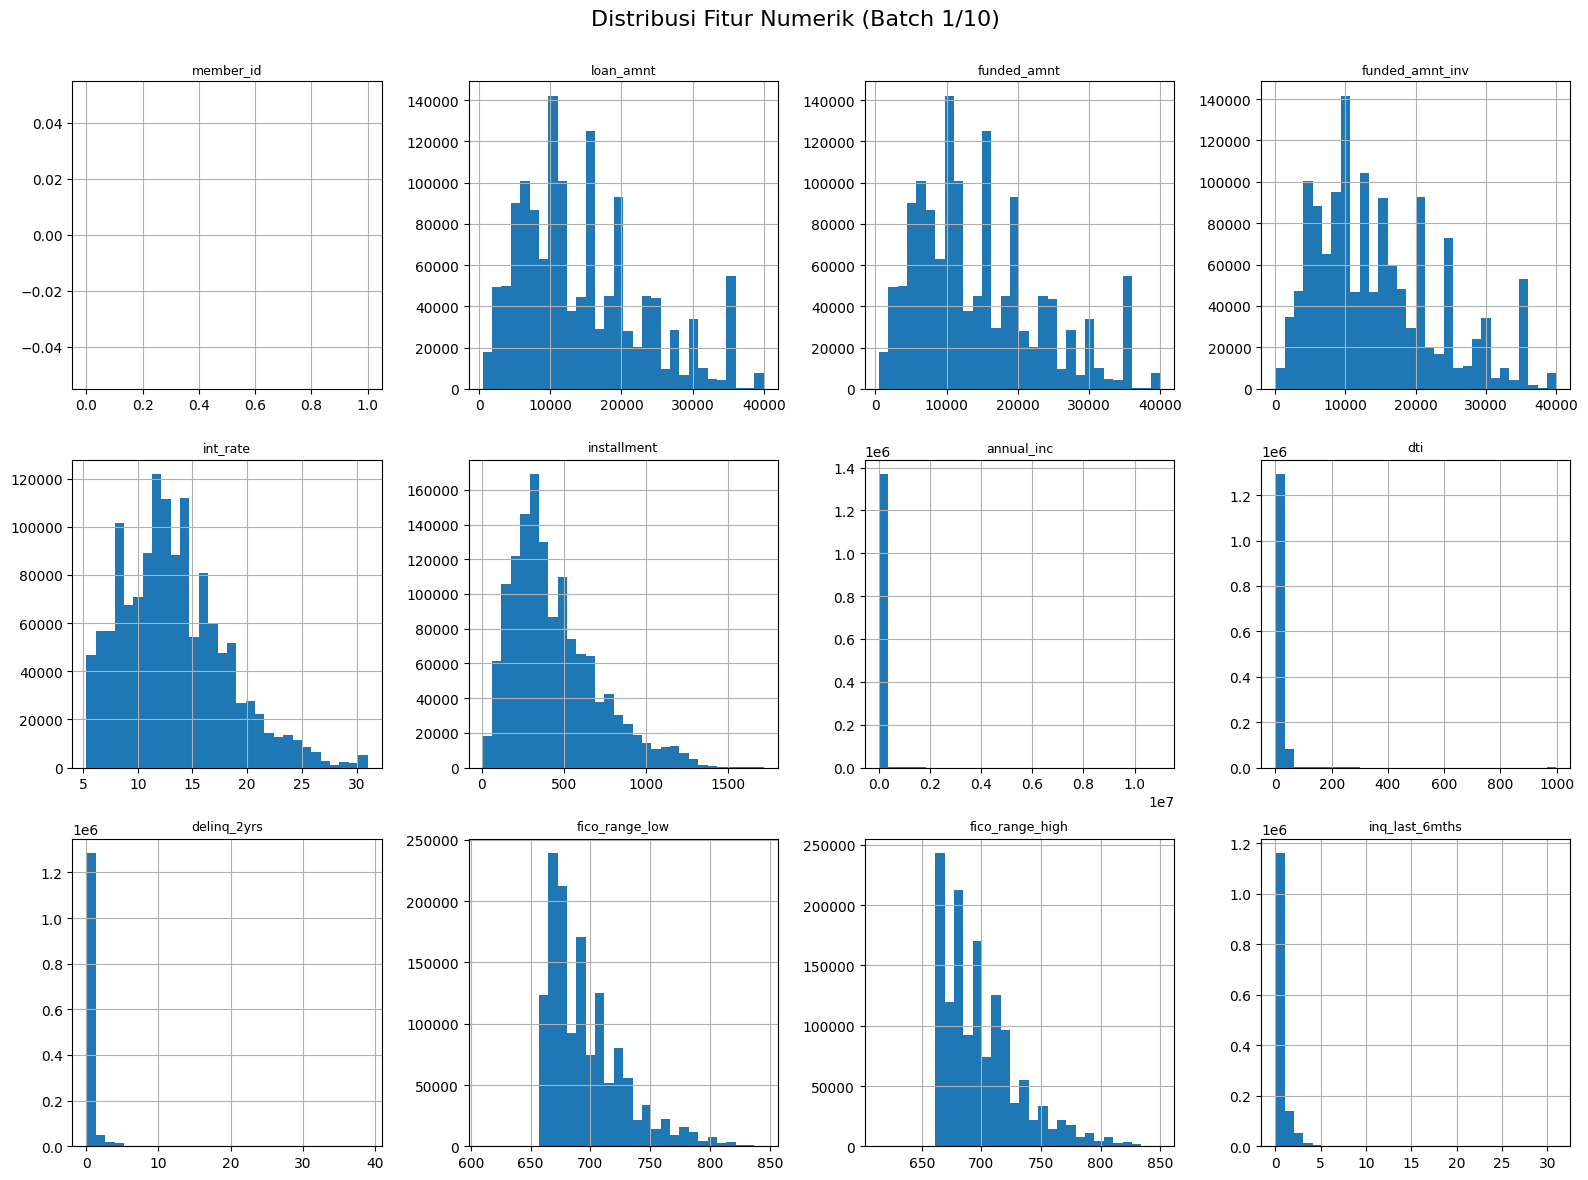

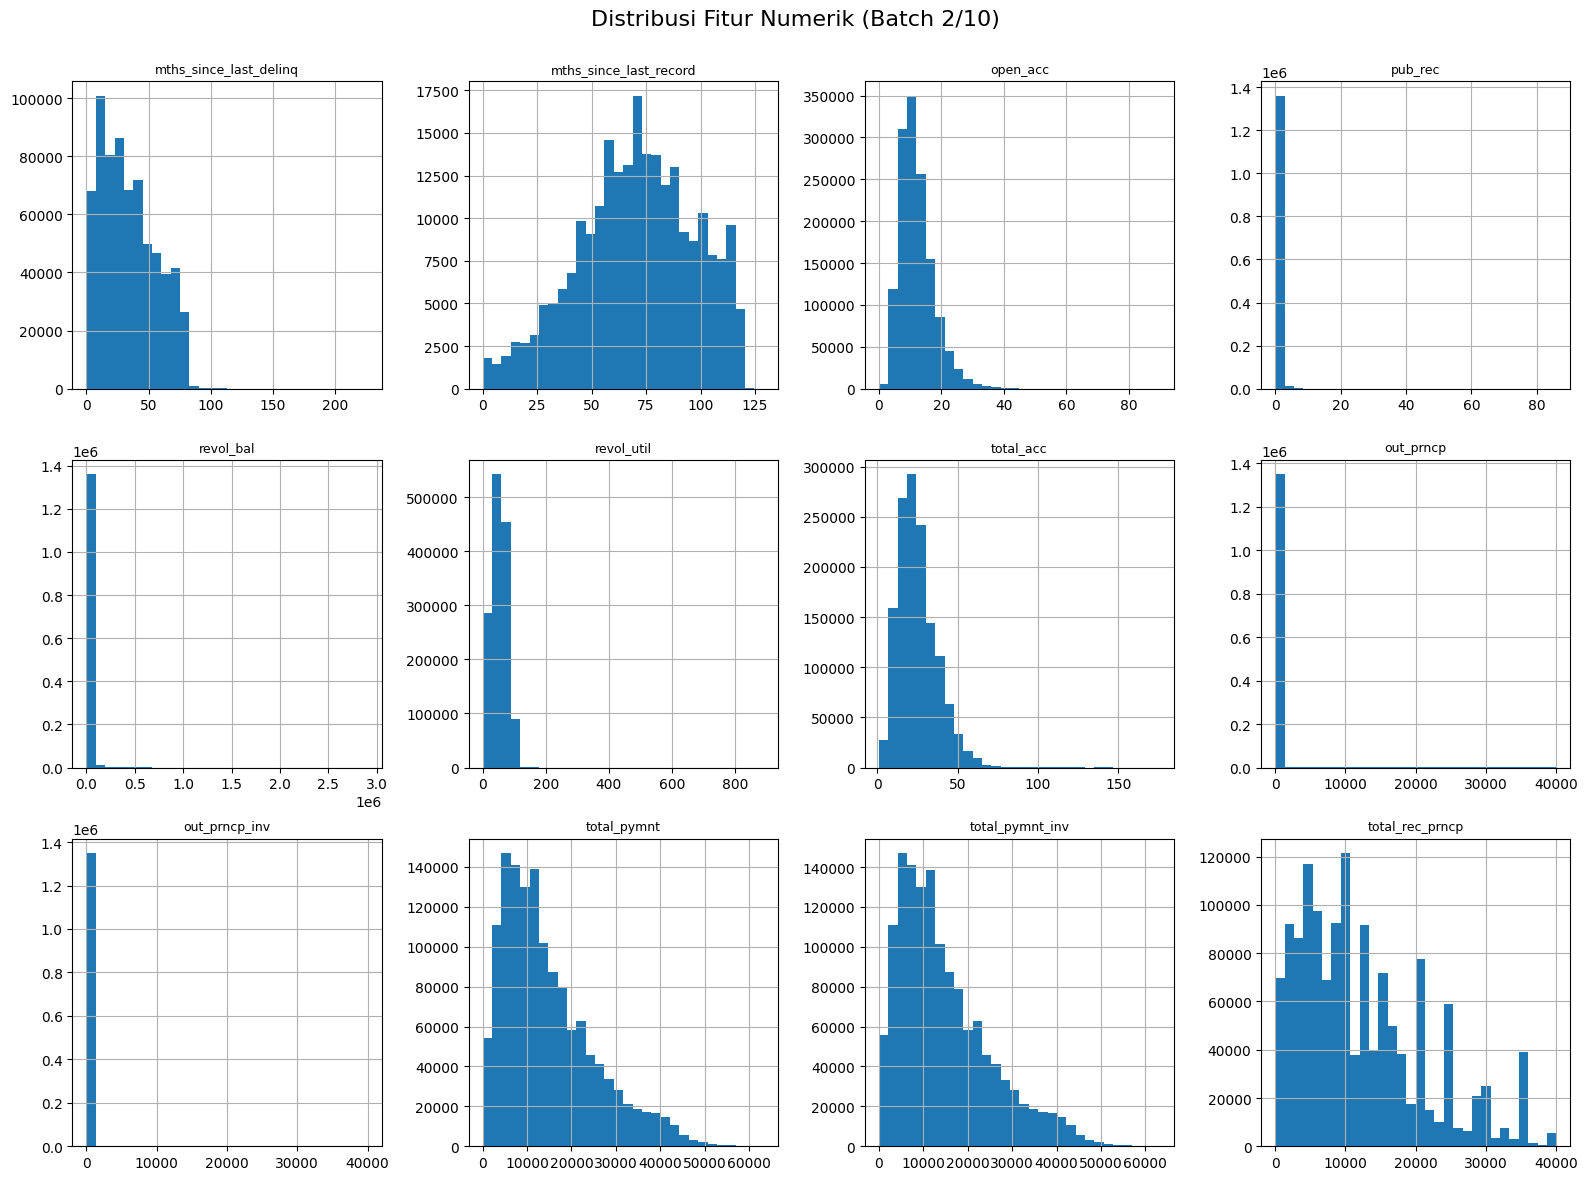

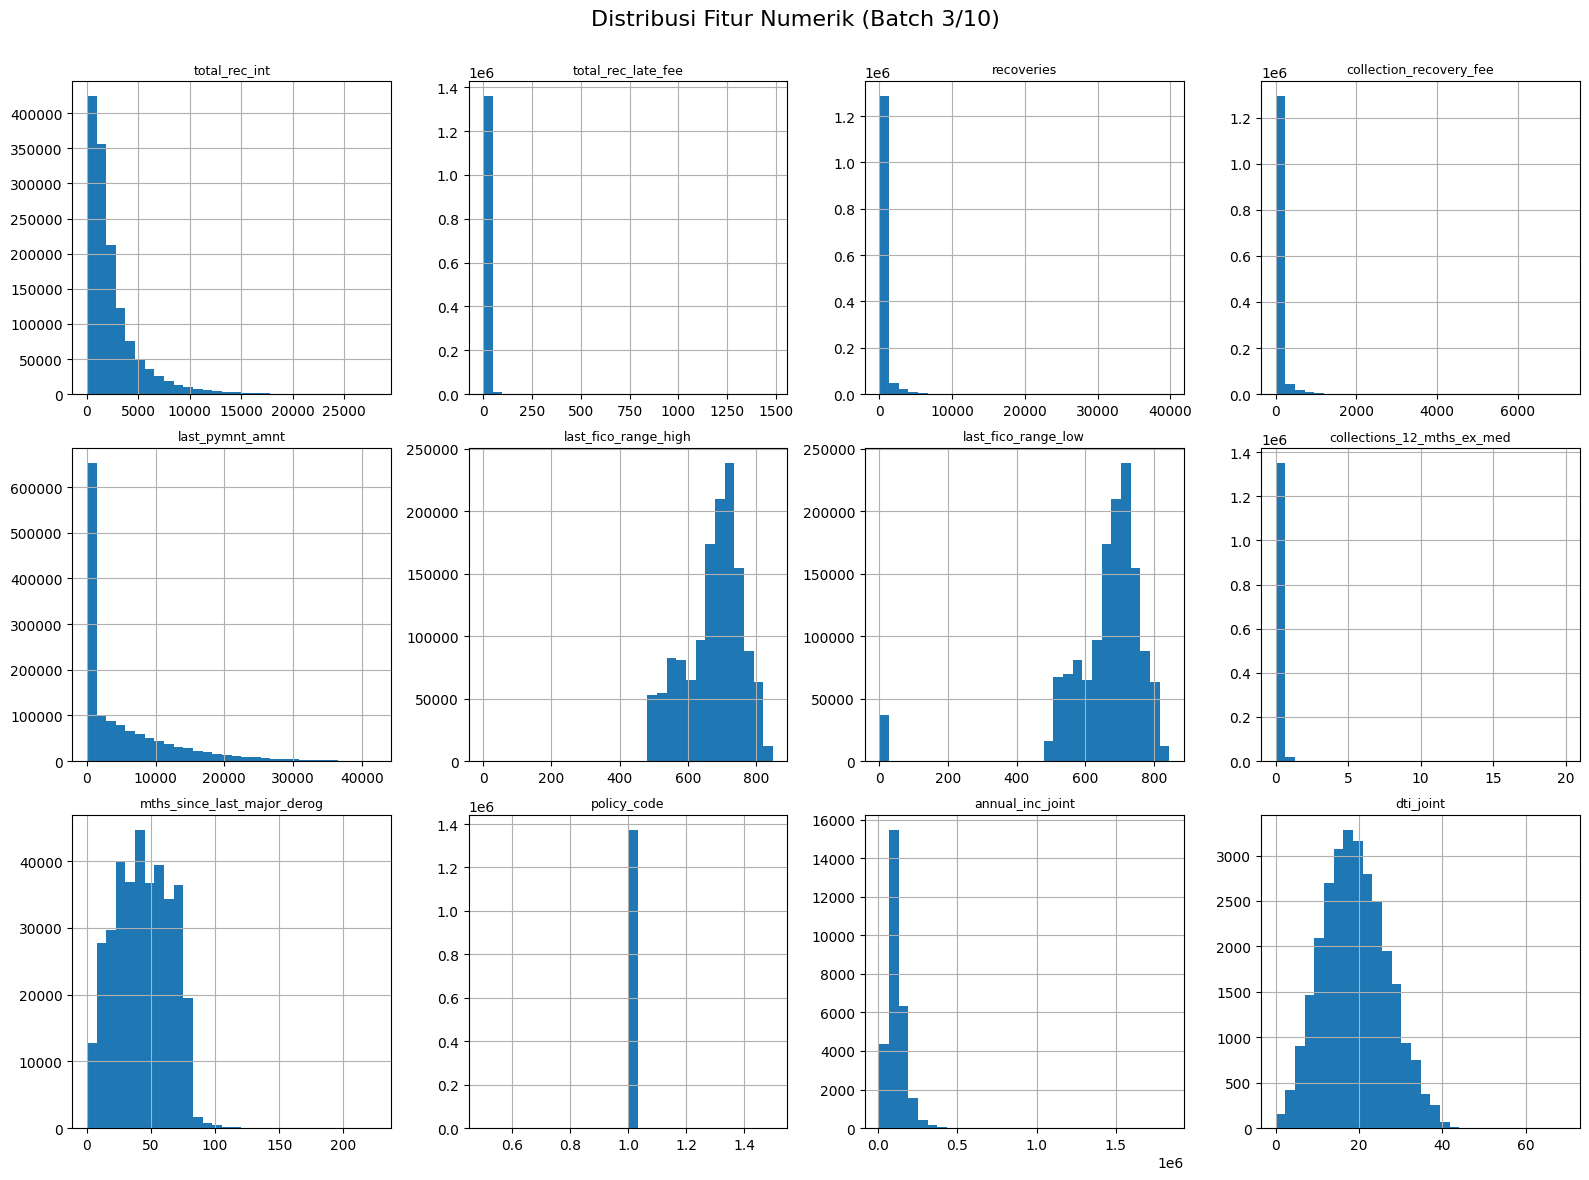

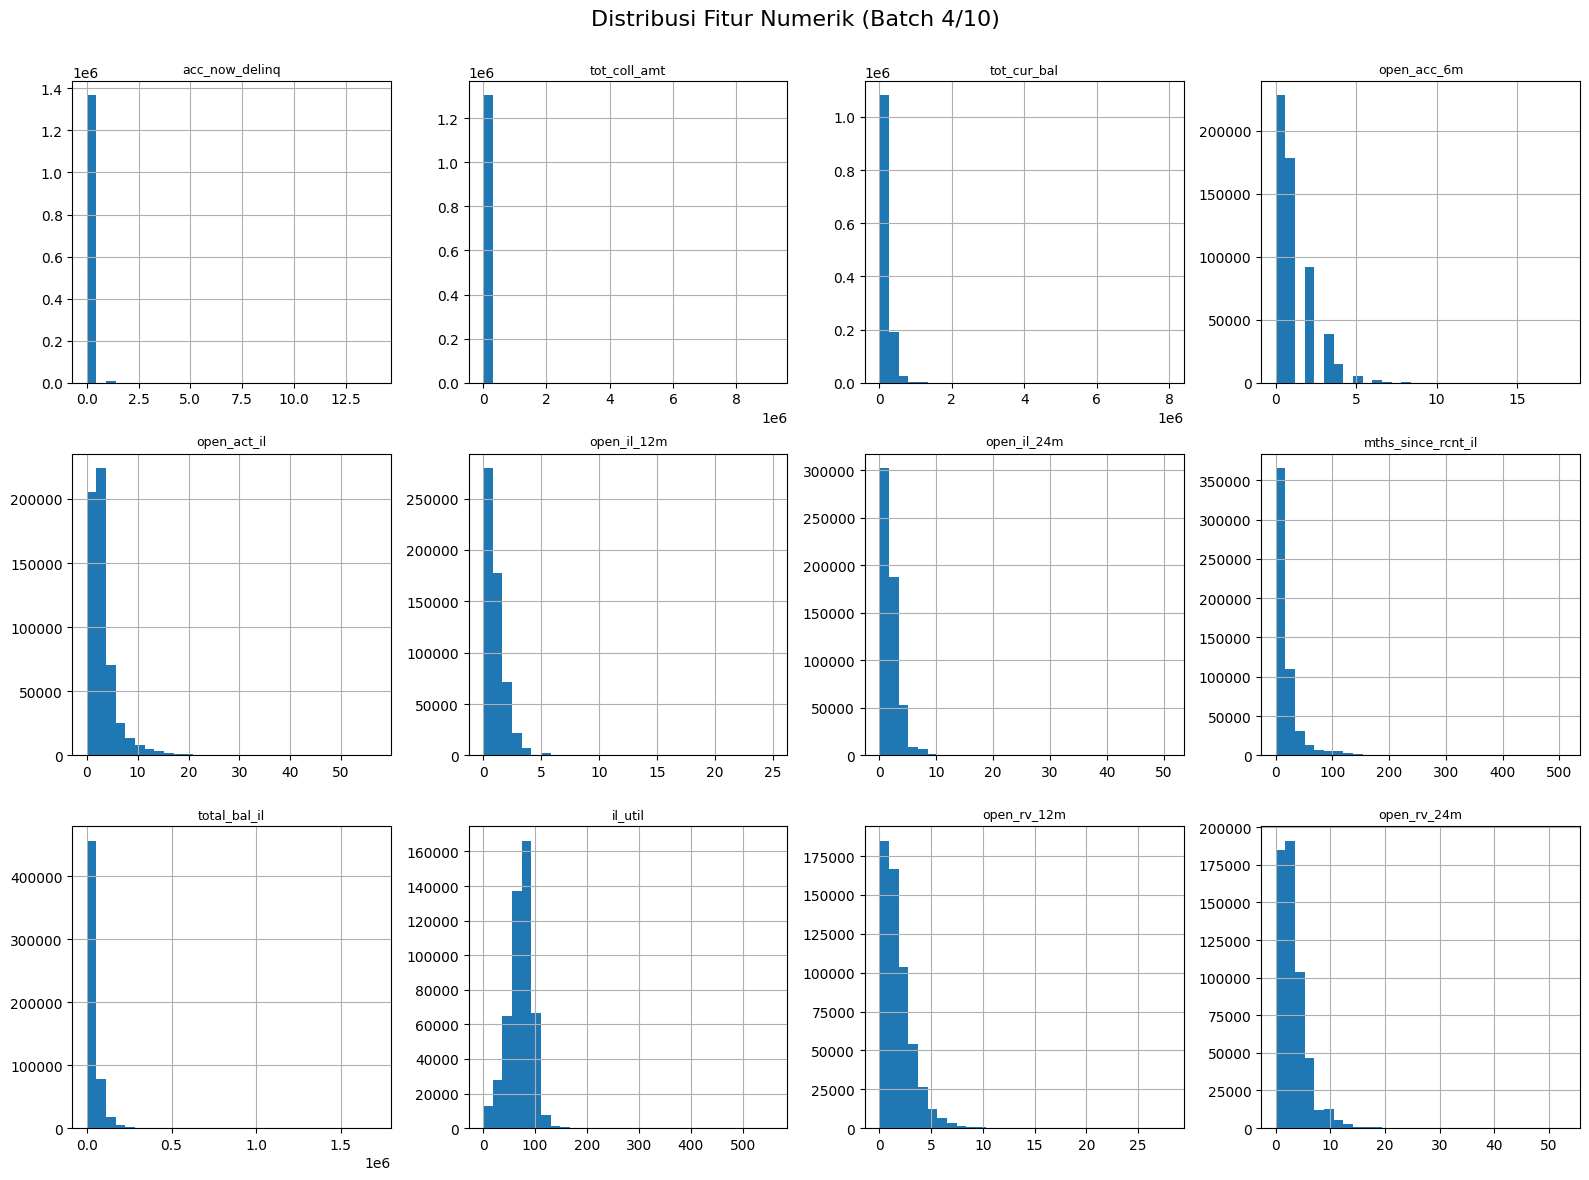

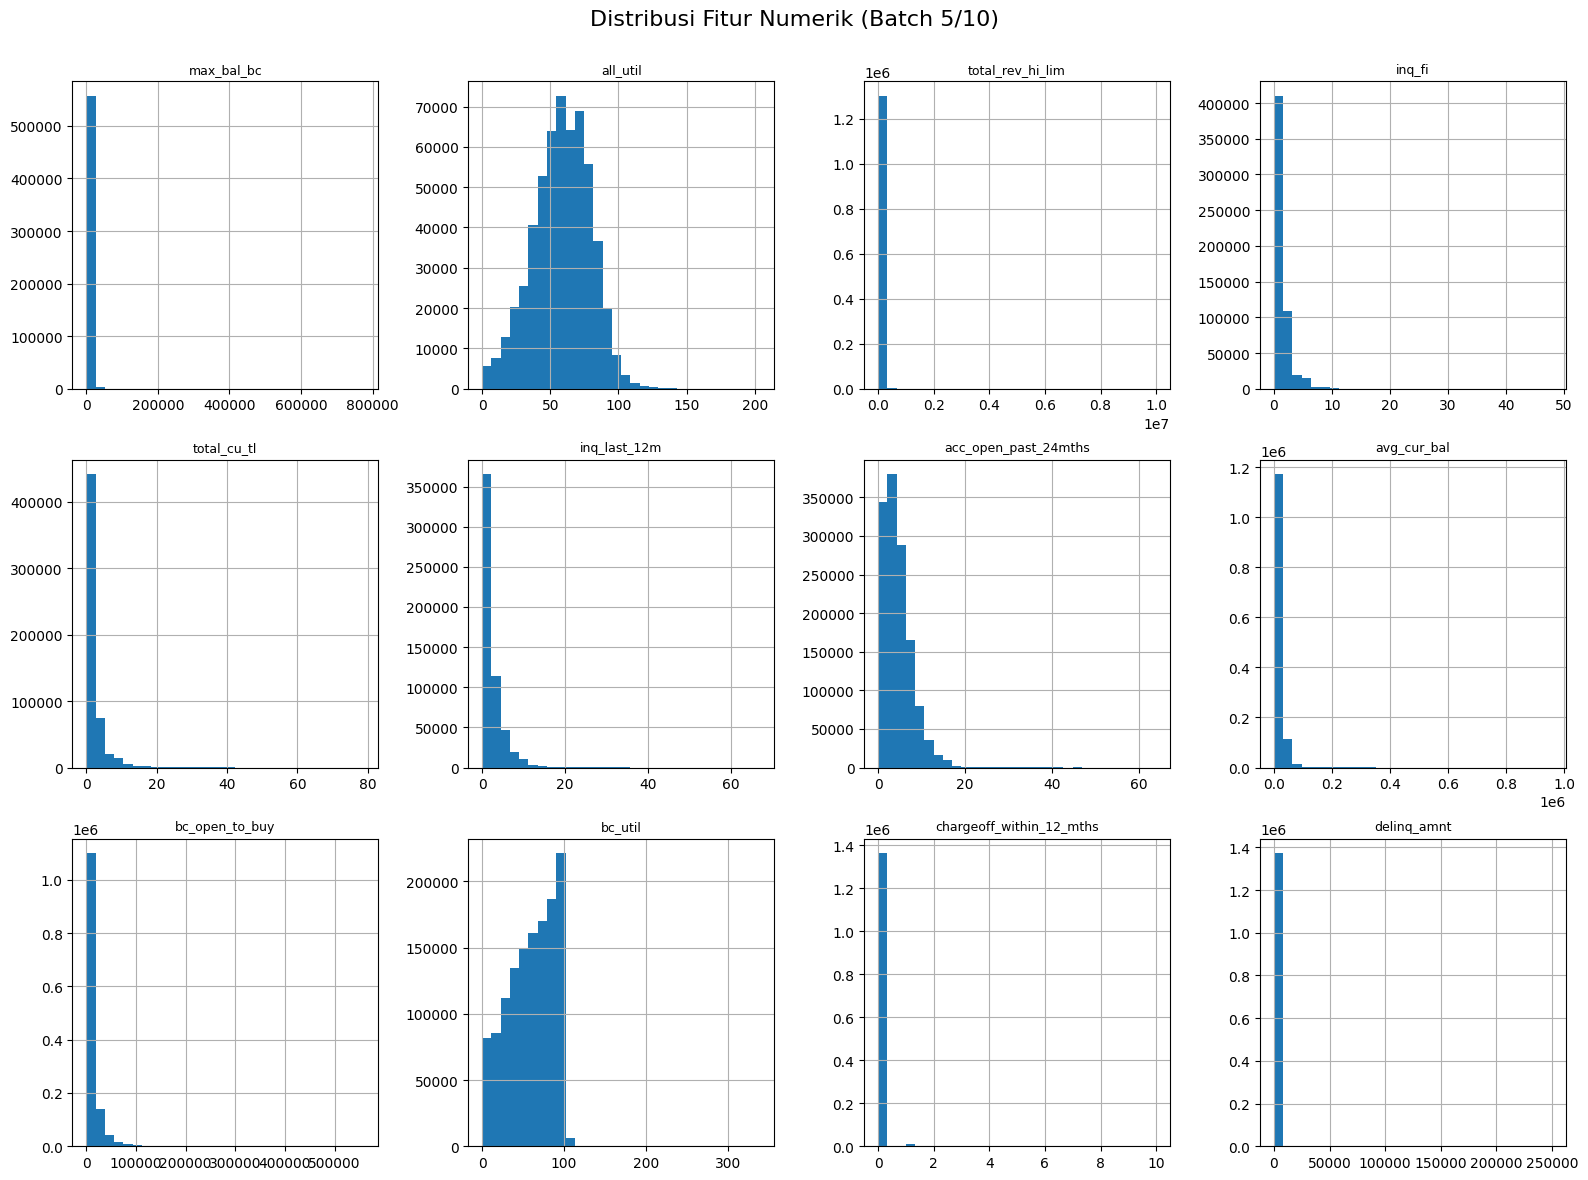

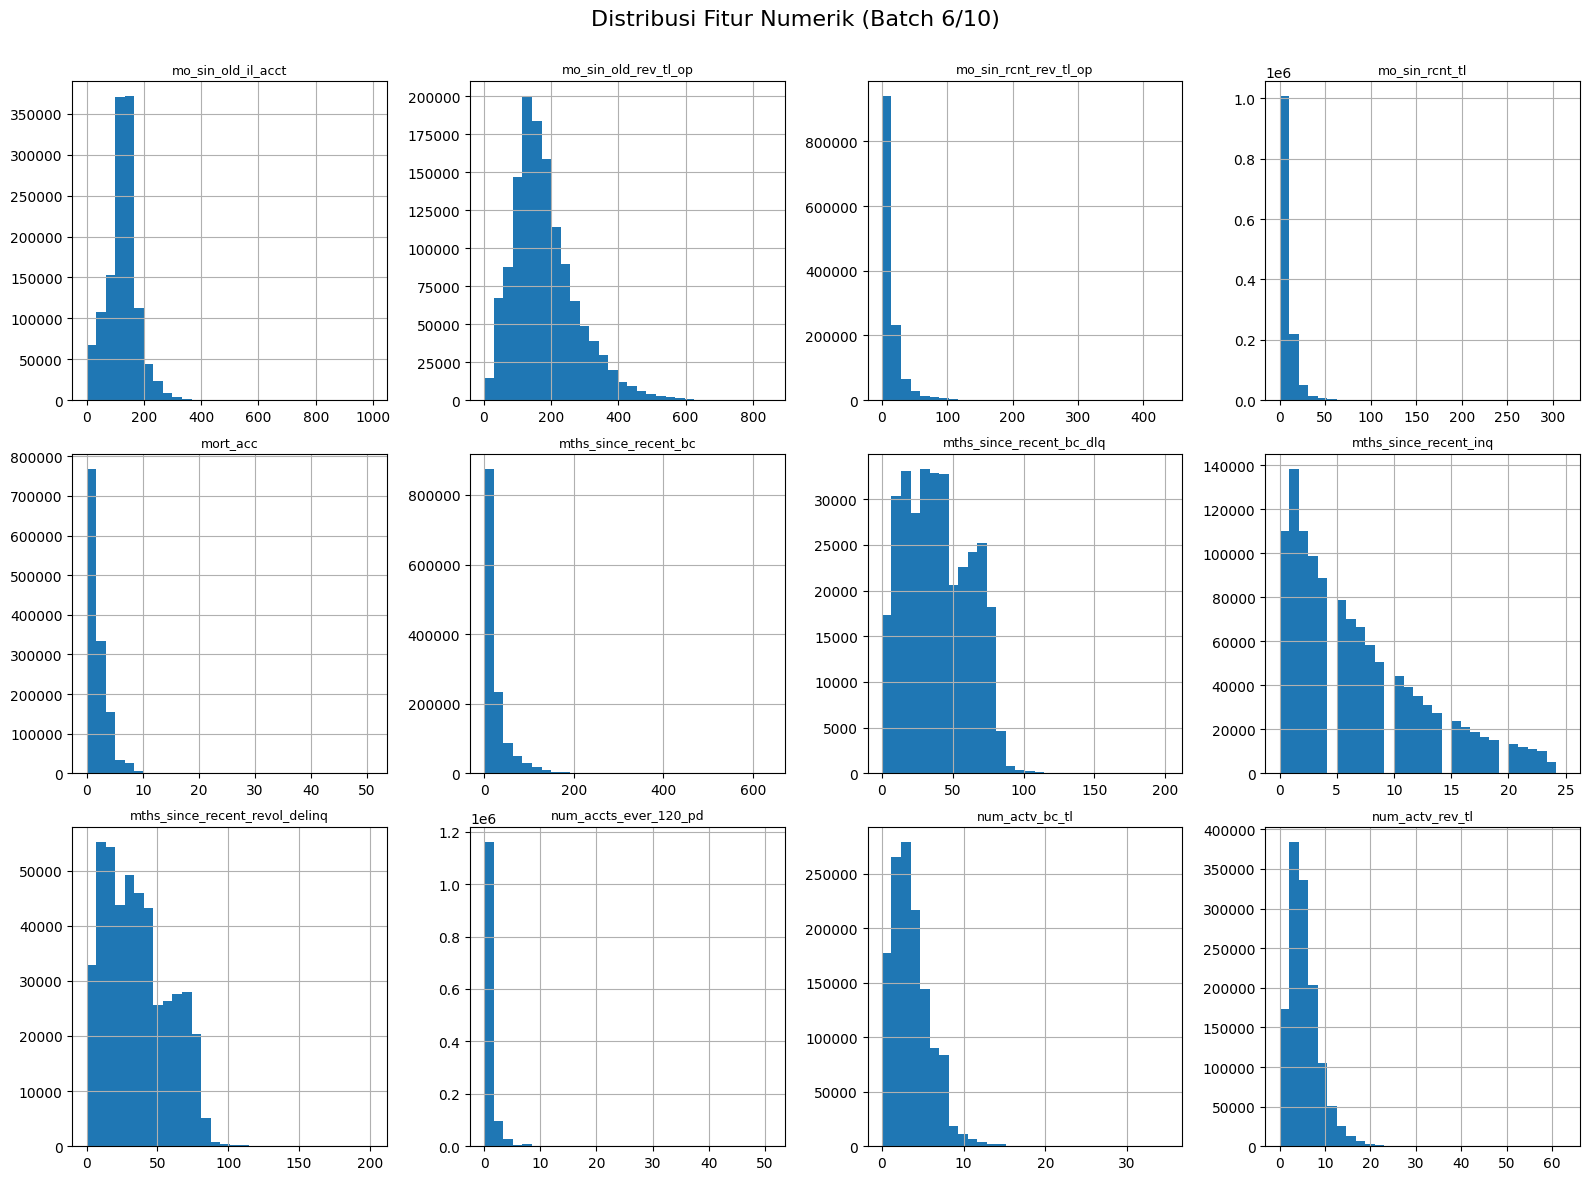

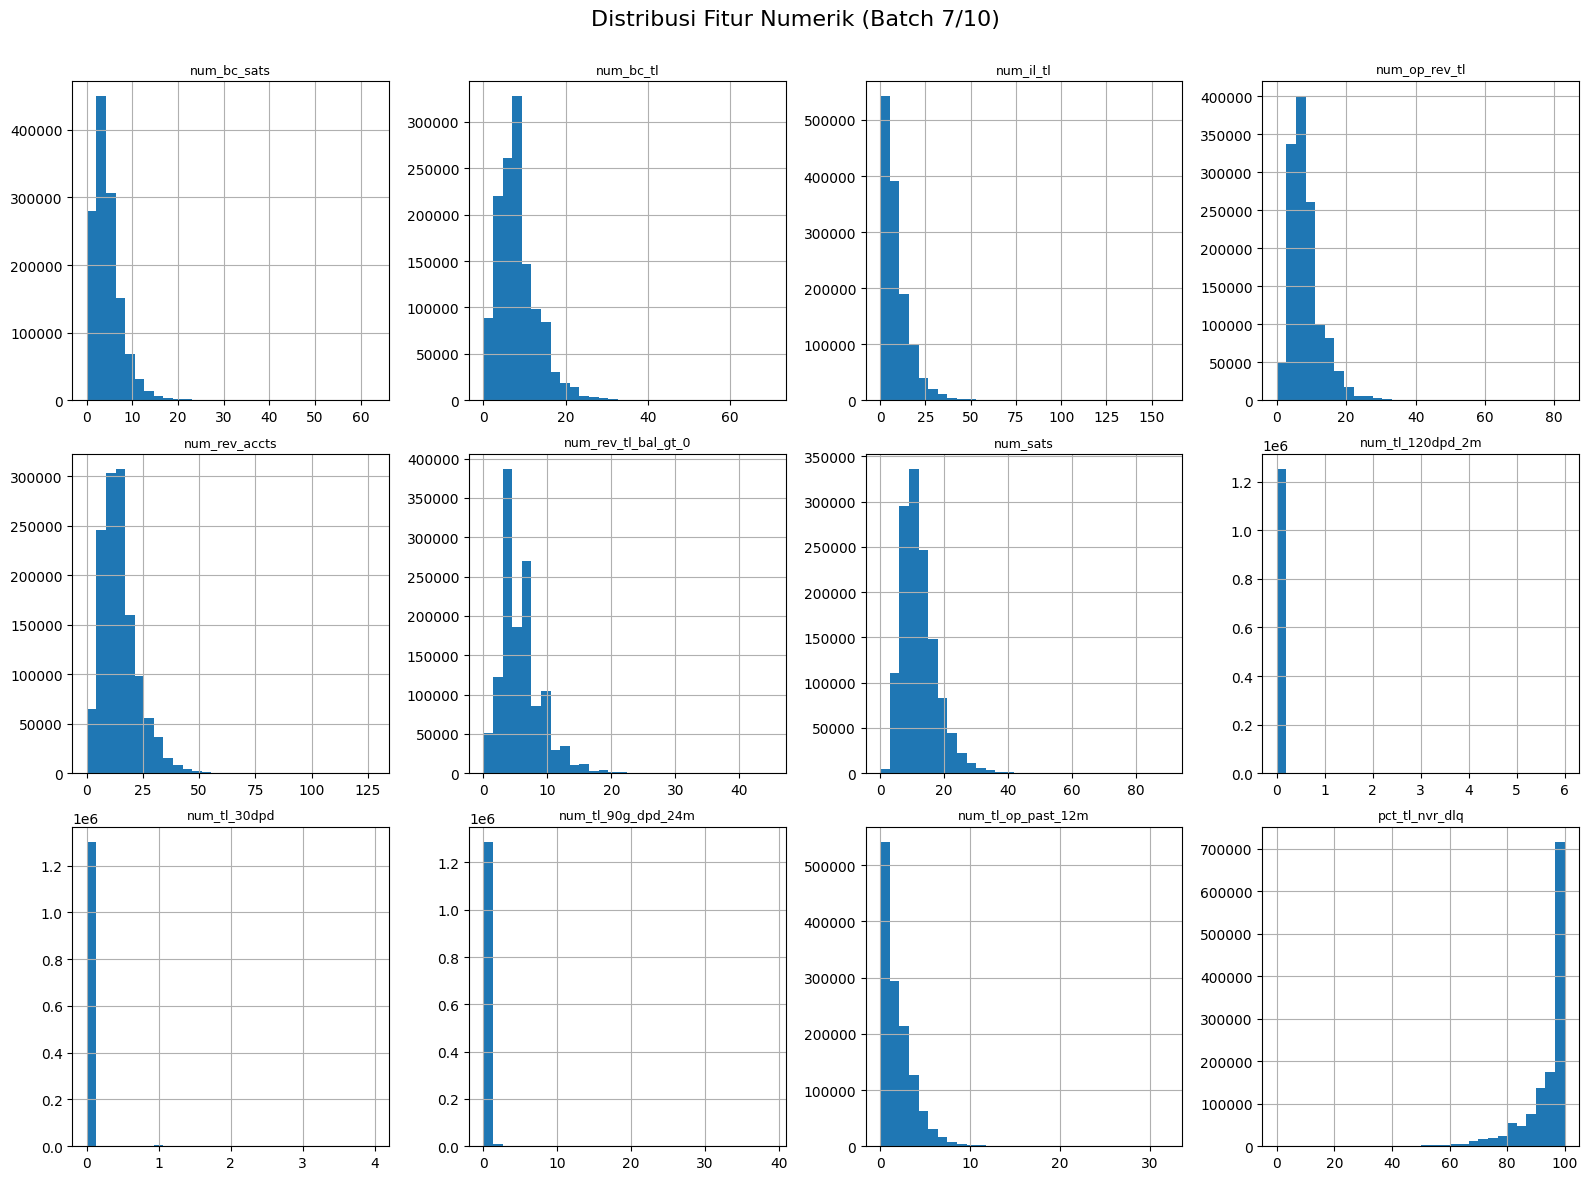

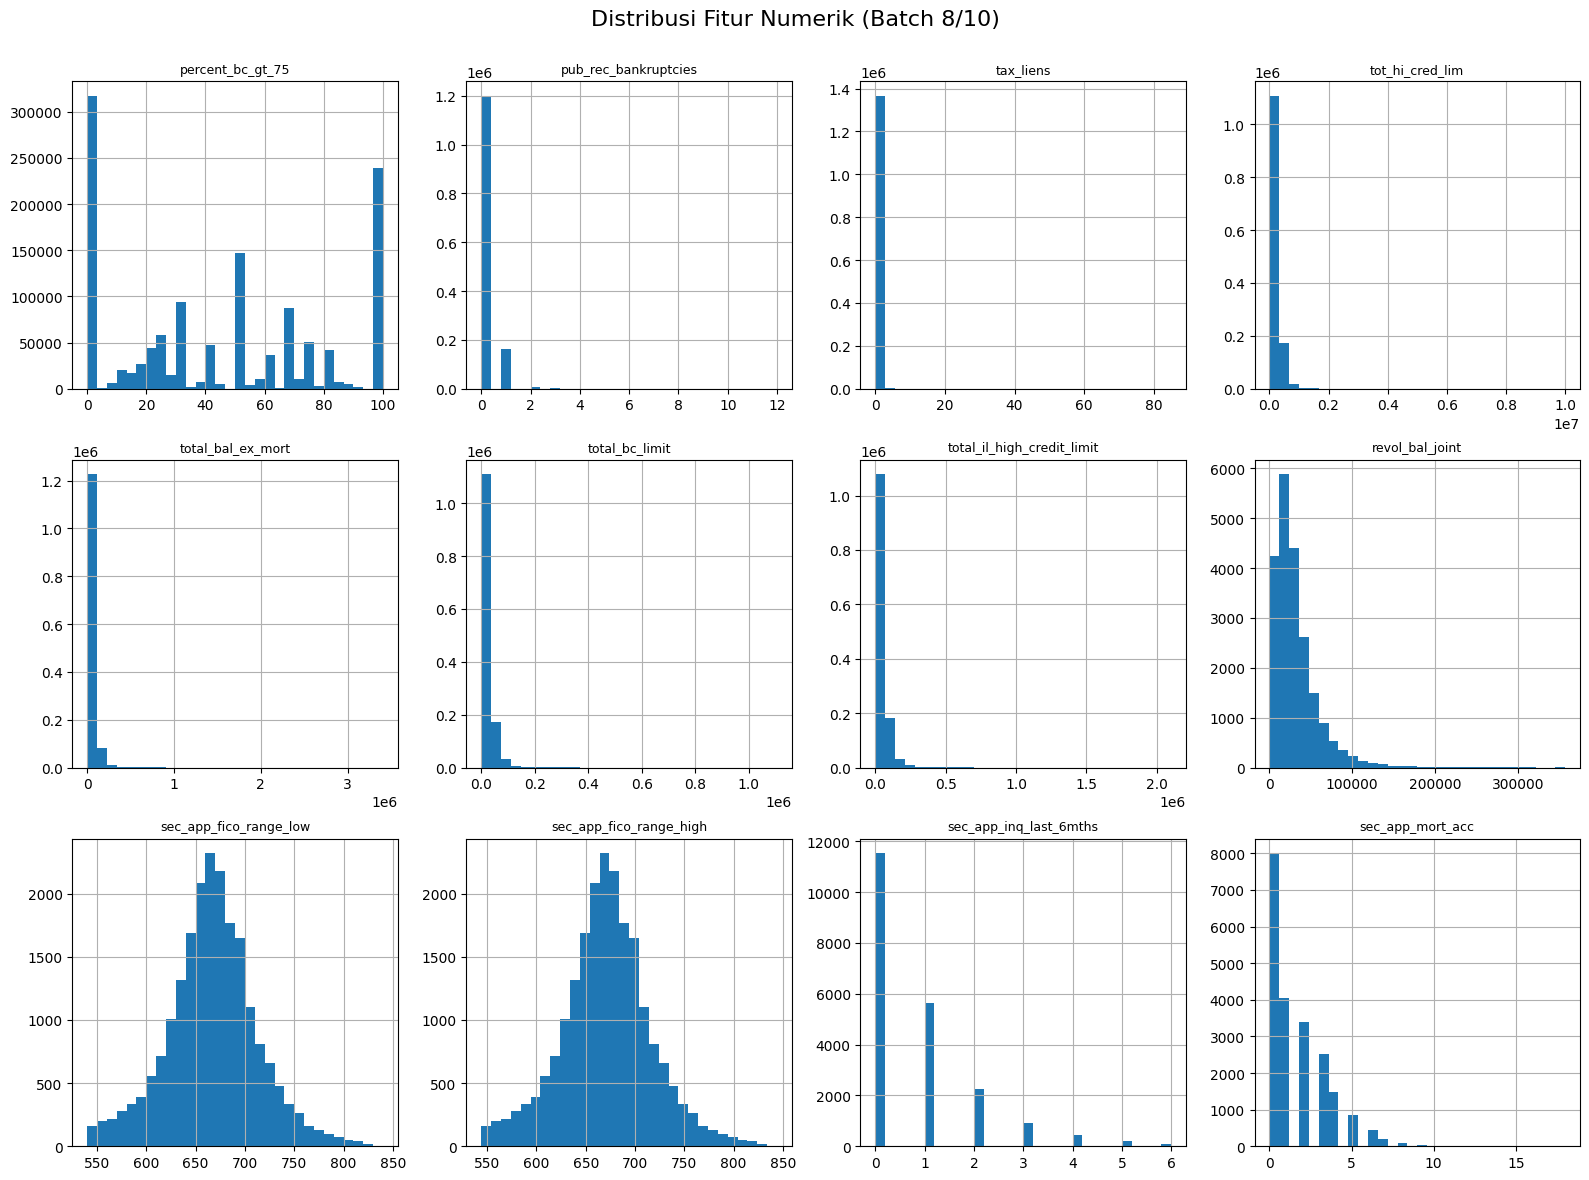

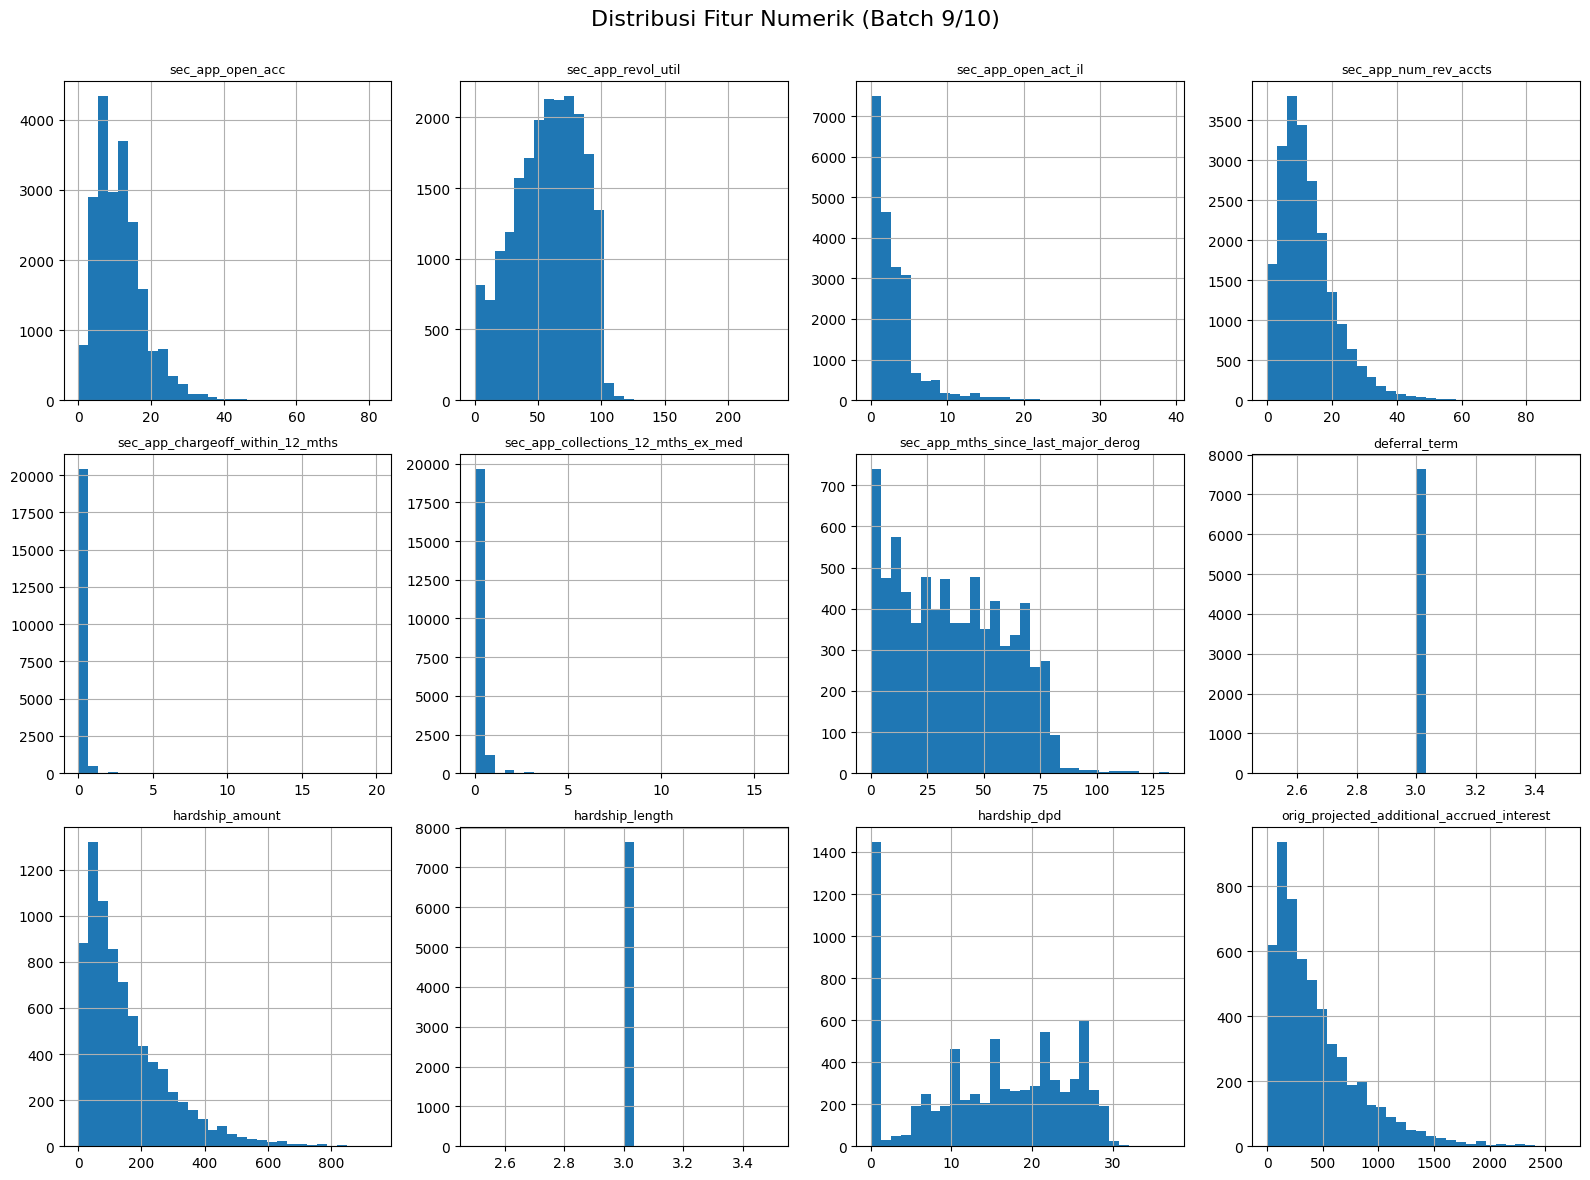

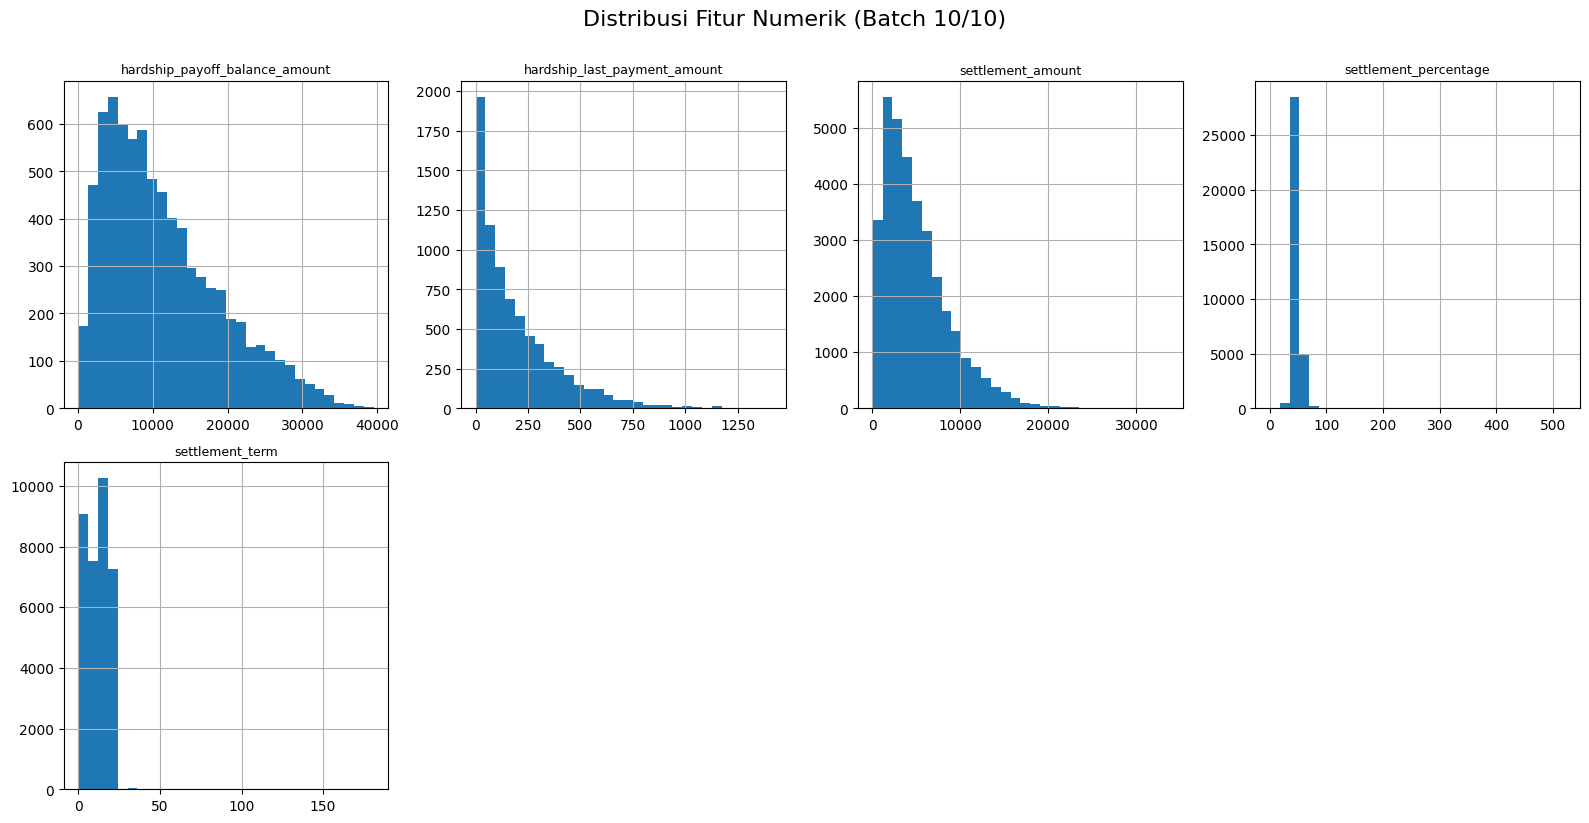

In [18]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
print(f"Numeric columns: {len(numeric_cols)}")

plots_per_page = 12
num_pages = math.ceil(len(numeric_cols) / plots_per_page)

for page in range(num_pages):
    start = page * plots_per_page
    end = start + plots_per_page
    cols_to_plot = [c for c in numeric_cols[start:end] if c != 'loan_status_binary']
    plt.figure(figsize=(16, 12))

    for i, col in enumerate(cols_to_plot, 1):
        plt.subplot(3, 4, i)
        df[col].hist(bins=30)
        plt.title(col, fontsize=9)

    plt.tight_layout()
    plt.suptitle(f"Distribusi Fitur Numerik (Batch {page+1}/{num_pages})", fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()


Dari visualisasi 113 kolom numerik, terdapat beberapa distribusi fitur yang penting dibahas untuk memahami karakteristik dataset lebih mendalam yaitu:
- `loan_amnt` (Pinjaman yang diminta): Distribusinya terlihat right-skewed denga mayoritas pinjaman berada di kisaran $5000 - $15000. Hal ini menunjukkan pinjaman yang disetujui mayoritas adalah pinjaman dengan jumlah relatif kecil hingga menengah.
- `funded_amnt` (Pinjaman yang dibiayai): Pola distribusinya hampir sama dengan `loan_amnt`, menunjukkan hampir semua pinjaman dibiayai penuh oleh sistem.
- `funded_amnt_inv` (Pinjaman yang dibiyai oleh retail): Pola distribusinya juga mirip dengan `funded_amnt` tetapi sedikit lebih menyebar, menandakkan variasi tingkat partisipasi investor.Adanya peran institusi (fund besar) dalam memenuhi pinjaman yang ada di Lending Club juga berpengaruh pada distribusi fitur ini.
- `int_rate` (Bunga pinjaman): Distribusi right skewed, didominasi dengan suku bunga sekitar 10-15%. Digabungkan dengan informasi `loan_amnt`, kita mendapat informasi bahwa orang yang meminjam melalui Lending Club profil risikonya lumayan tinggi (meminjam uang relatif kecil-menengah dengan bunga yang relatif tinggi).
- `installment` (jumlah cicilan bulanan): Distribusi menumpuk pada bayaran bulanan rendah karena rata-rata nominal yang dipinjam juga rendah-sedang.
- `annual_inc` (pendapatan tahunan): Distribusi pendapatan tahunan terlihat normal dengan distribusi sangat right skewed, karena memang individu dengan pendapatan sangat besar jumlahnya sedikit.
- `dti` (pemasukkan yang digunakan untuk membayar hutang) (perbandinan hutang dengan pemasukkan): Distribusi nya sangat right skewed dengan beberapa nilai ekstrem. Hal ini menunjukkan  rata-rata peminjam yang di terima oleh Lending Club mempunyai dti yang rendah
- `fico_range_low` (Batas bawah skor FICO ): Distribusi berkumpul di kisaran 650-720. Hal ini menunjukkan mayoritas peminjam yang diterima oleh Lending Club memiliki kredit skor yang cukup baik (kredibel). Righ-skew kecil muncul dari orang-orang dengan skor kredit lebih tinggi yang jumlahnya jauh lebih sedikit.
- `fico_range_high` (Batas atas skor FICO): Distribusinya hampir sama degnan `fico_range_low`, tetapi sedikit lebih tinggi karena adalah batas atas rentang skor kredit.
- `inq_last_6mths` (Jumlah inquiry kredit dalam 6 bulan terakhir): Distribusi sangat right skewed dengan mayoritas peminjam memiliki 0-2 inquiry dalam 6 bulan terakhir, menunjukkan aktivitas pengajuan kredit yang relatif rendah. Nilai ekstrem (> 5) muncul sangat jarang yang menandakkan orang dengan profil risiko tinggi sedikit yang diterima oleh Lending Club.
- `open_acc` (Jumlah akun kreadit aktif): Distribusi right-skewed dengan mayoritas di kisaran 5-15 akun.
- `total_acc` (Total akun kredit sepanjang hidup): Distribusi mirip dengan `open_acc` tetapi dengan nilai yang lebih tinggi karena mencakup semua akun yang ada (termasuk yang sudah ditutup). Right skew muncul karena banyak peminjam memiliki riwayat kredit panjang dengan banyak akun sepanjang hidupnya.
- `revol_bal` (Saldo kredit bergulir): Distribusi sangat right skewed dengan sebagian besar saldo berada di level rendah, namun terdapat outlier dengan saldo sangat besar. Hal ini menunjukkan penggunaan revolving credit yang sangat bervariasi antar individu
- `revol_util` (Rasio pemakaian kredit bergulir): Distribusi juga right-skewed dengan mayoritas peminjam memiliki pemakaikan rendah hingga sedang (< 40%). Nilai ekstrem menunjukkan peminjam yang mendekati batas kredit. 

**Data Kategorikal**

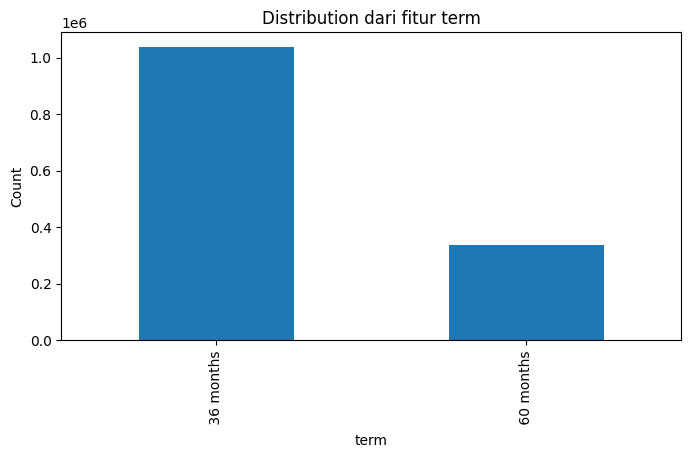

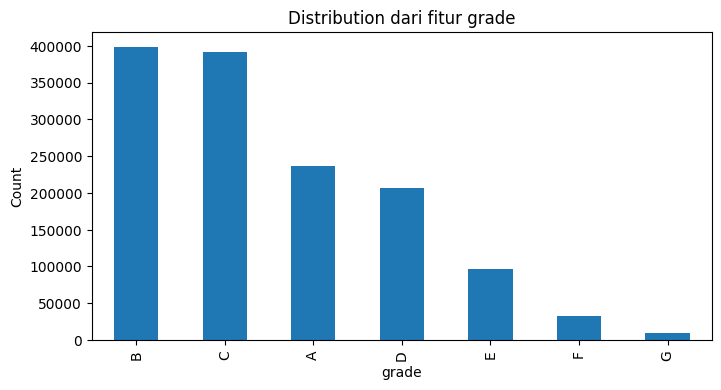

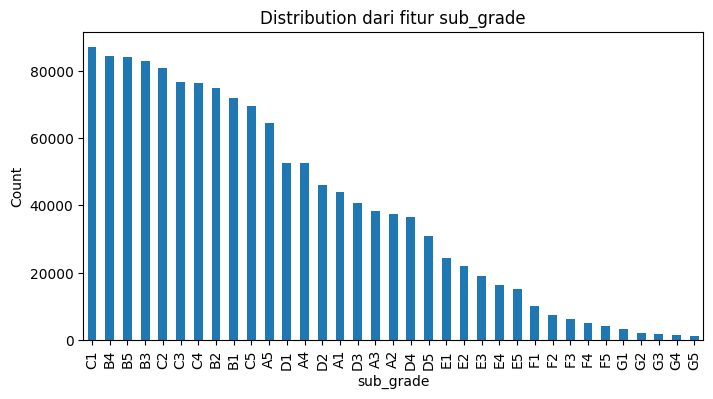

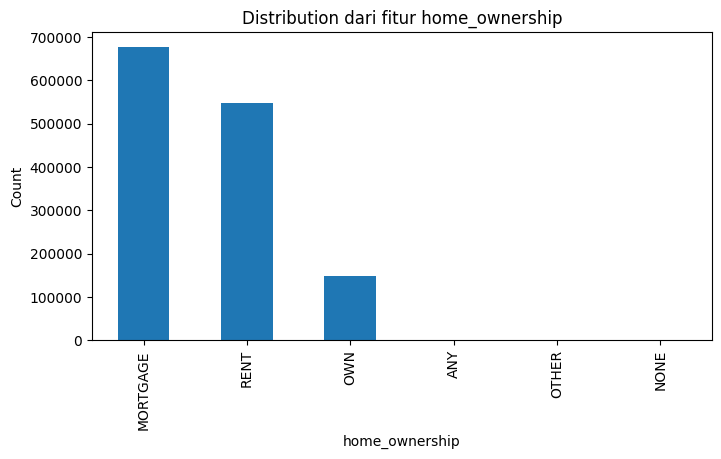

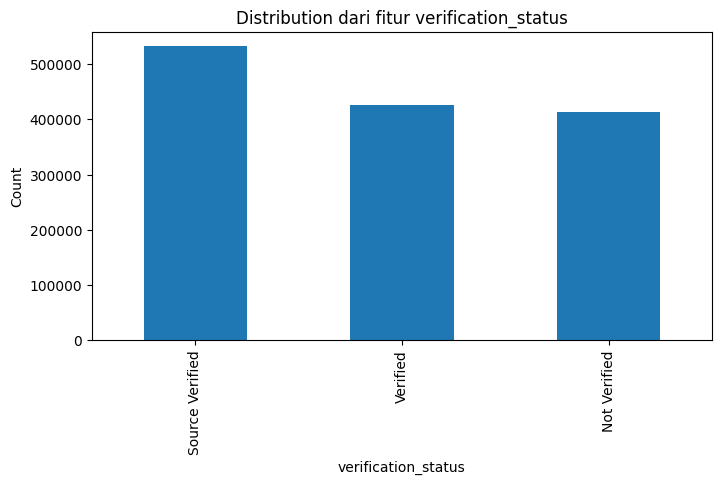

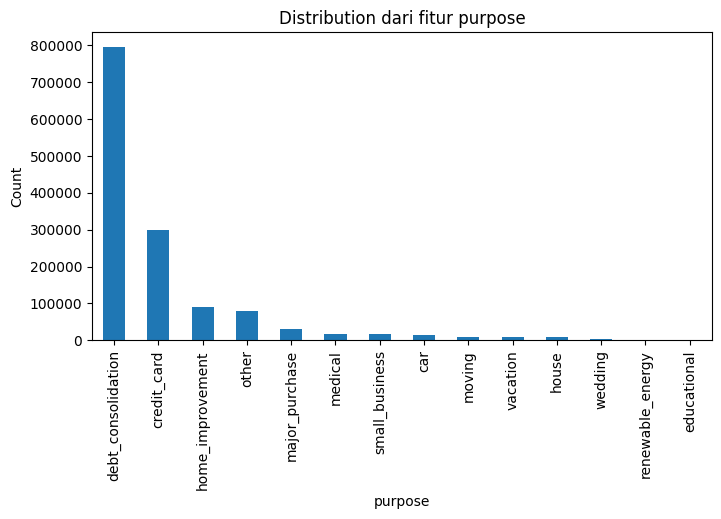

In [25]:
categorical_cols = df.select_dtypes(include=['object']).columns

for col in ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose']:
    plt.figure(figsize=(8,4))
    df[col].value_counts().plot(kind="bar")
    plt.title(f"Distribution dari fitur {col}")
    plt.ylabel("Count")
    plt.show()


Dari 6 fitur kategorikal , berikut pembahasannya:
- `term` (Lama pinjaman): Hanya terdapat 2 opsi pinjaman di Lending Club pelunasan dalam 36 bulan atau 60 bulan. Mayoritas orang memilih 36 bulan agar hutang cepat selesai dan jumlah yang dibayarkan tidak terlalu besar.
- `grade`: Mayoritas berada di grade B dan C (risiko rendah-sedang) diikuti dengan grade A karena populasi orang dengan skor kredit grade A sepertinya sedikit, diikuti dengan D,E,F,G. Hal ini menunjukkan bahwa semakin bagus grade (mendekati A), maka semakin banyak pula pinjaman yang disetujui.
- `sub_grade`: Informasi yang didapat kurang lebih sama dengan `grade`.
- `home_ownership` (Status kepemilikan rumah): Mayoritas peminjam memiliki status MORTGAGE (cicilan rumah) diikuti RENT dan OWN, sementara kategori ANY, OTHER, dan NONE hampir tidak ada. Ini menunjukkan bahwa sebagian besar peminjam adalah orang yang sedang mencicil rumah atau menyewa, yang mengindikasikan mereka memiliki komitmen finansial bulanan yang stabil.
- `verification_status` (Status verifikasi): Distribusi cukup merata antara Source Verified (~540 ribu), Verified (~430 ribu), dan Not Verified (~420 ribu). Hal ini menunjukkan Lending Club melakukan proses verifikasi yang cukup ketat, di mana lebih dari separuh peminjam telah diverifikasi sumber pendapatannya.
- `purpose` (Tujuan pinjaman): Debt consolidation (konsolidasi hutang) mendominasi dengan ~80 ribu, diikuti credit card (~30 ribu) dan home improvement (~10 ribu), sementara tujuan lain relatif kecil. Ini mengindikasikan bahwa mayoritas peminjam menggunakan platform untuk menata ulang hutang mereka dengan bunga yang lebih rendah.

### **Hubungan Dengan Label**

Fitur Numerik

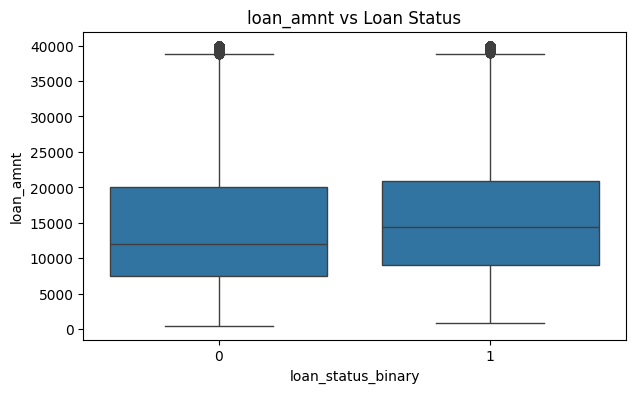

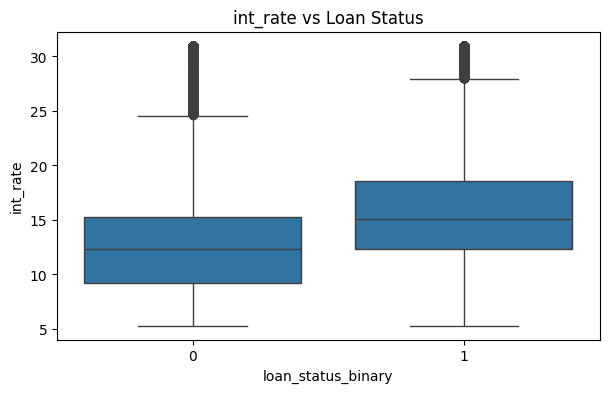

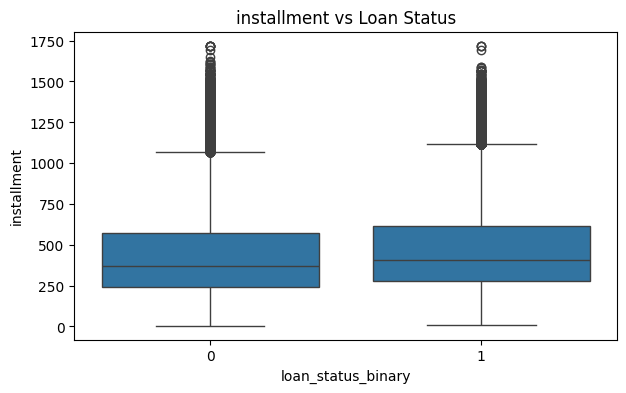

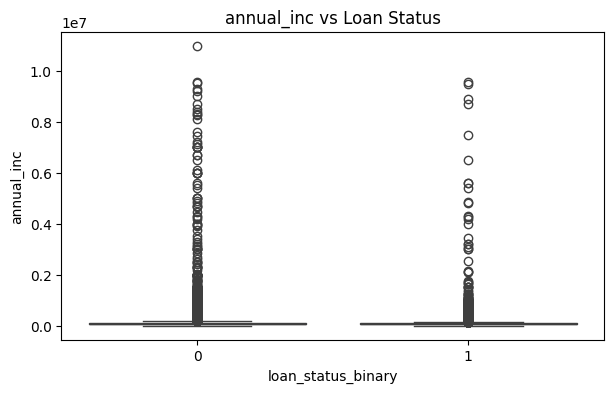

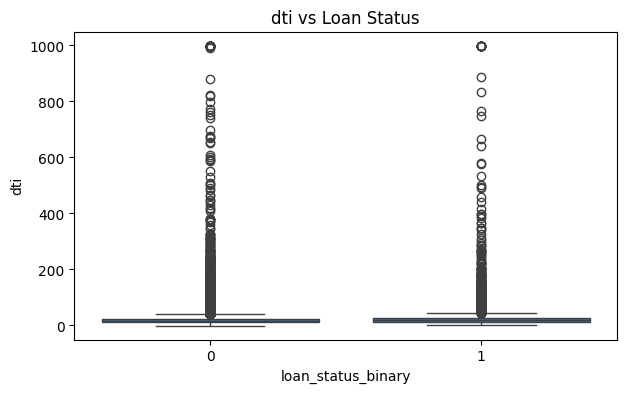

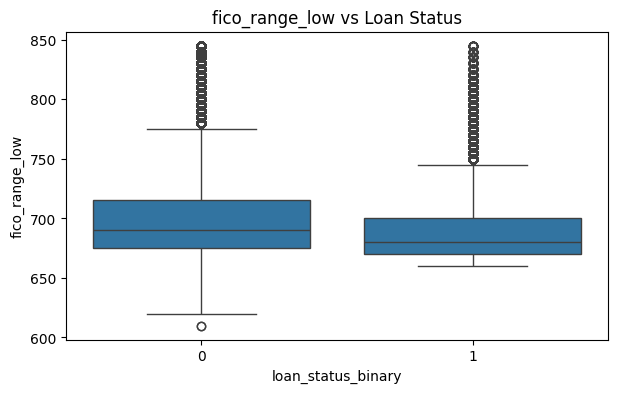

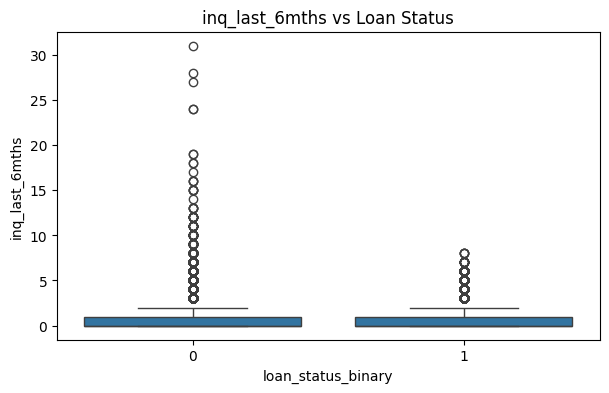

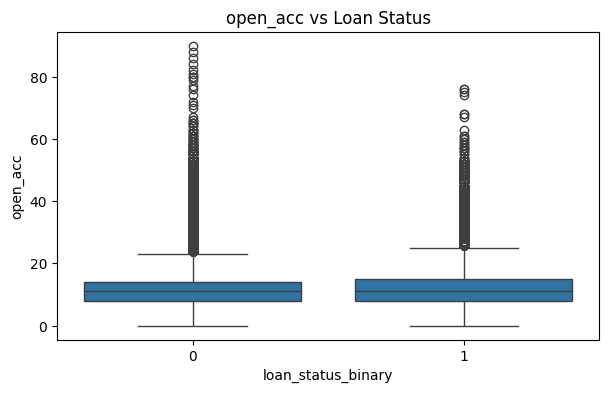

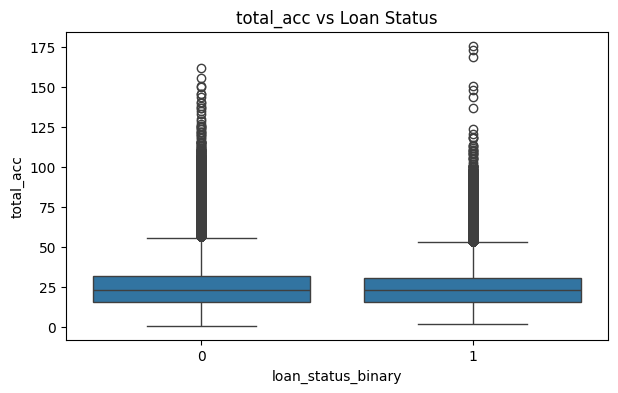

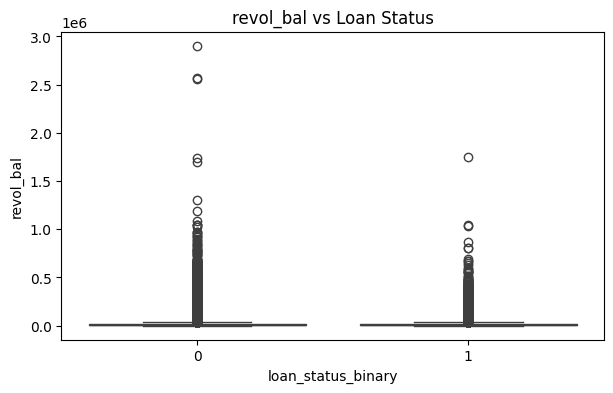

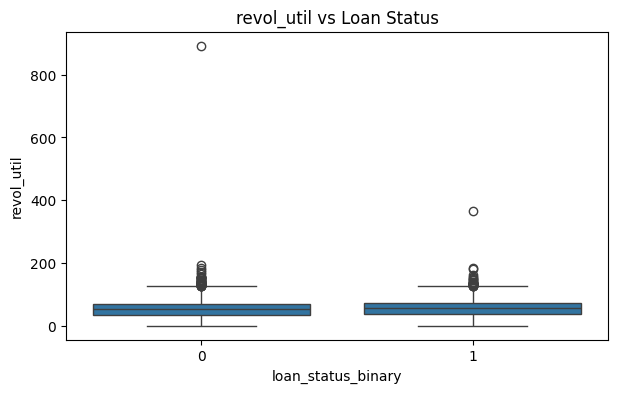

In [20]:
important_numerics = [
    'loan_amnt',
    'int_rate',
    'installment',
    'annual_inc',
    'dti',
    'fico_range_low',
    'inq_last_6mths',
    'open_acc',
    'total_acc',
    'revol_bal',
    'revol_util'
]

for col in important_numerics:
    plt.figure(figsize=(7,4))
    sns.boxplot(data=df, x='loan_status_binary', y=col)
    plt.title(f"{col} vs Loan Status")
    plt.show()


Dari visualisasi data yang telah dilakukan untuk melihat hubungan fitur numerikal dengan kelas label, didapatkan beberapa fitur yang terindikasi punya hubungan dengan label, yaitu:
- `loan_amnt`: loan amount berpengaruh terhadap `loan_status` dimana semakin tinggi pinjaman yang dilakukan, maka memperbesar kemungkinan default.
- `int_rate`: interest rate berpengaruh pada `loan_status` dimana peminjam yang default cenderung memiliki buga pinjaman yang lebih tinggi.
- `installment`: Terdapat hubungan yang cenderung lebih lemah dari fitur installmet terhadap `loan_status` dimana peminjam yang default cenderung sedikit lebih tinggi installmentnya.
- `fico_range_low`: Batas bawah skor FICO yang lebih rendah cenderung default (semakin buruk credit score, maka risiko gagal bayar naik)
- `revol_bal`: Terdapat hubungan antara `revol_bal` dengan `loan_status` dimana peminjam yang akhirnya default memiliki distribusi saldo kredit bergulir yang cenderung lebih tinggi.
- `revol_util`: Rasio pemakaian kredit bergulir sedikit lebih tinggi pada peminjam yang akhirnya default.

Fitur Kategorikal

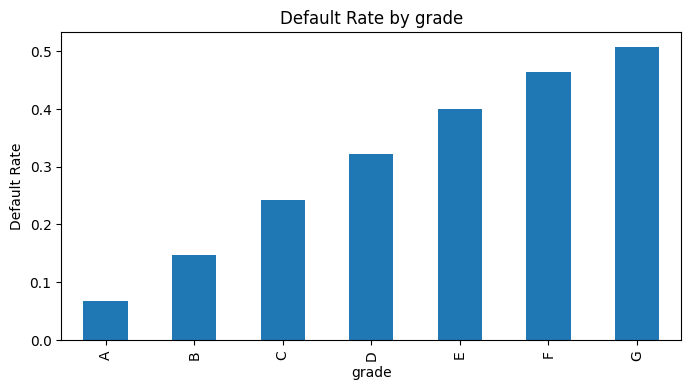

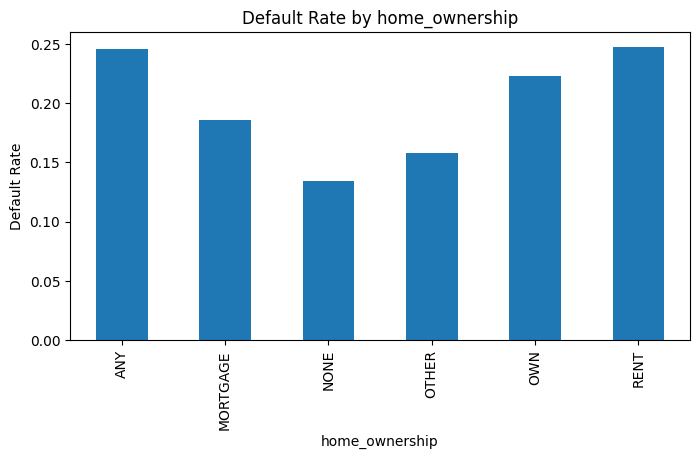

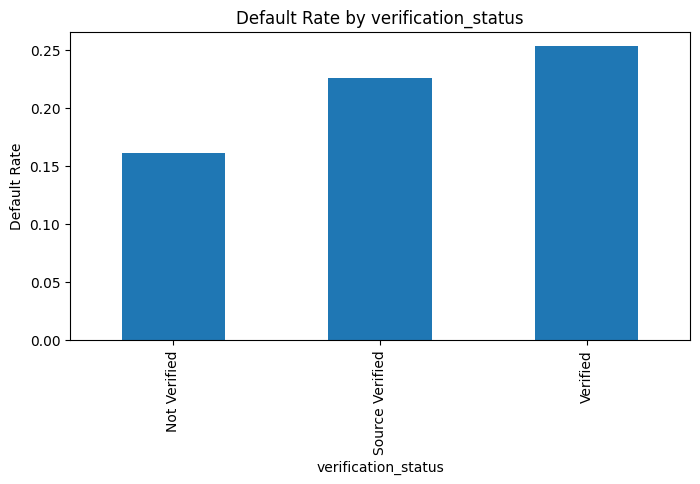

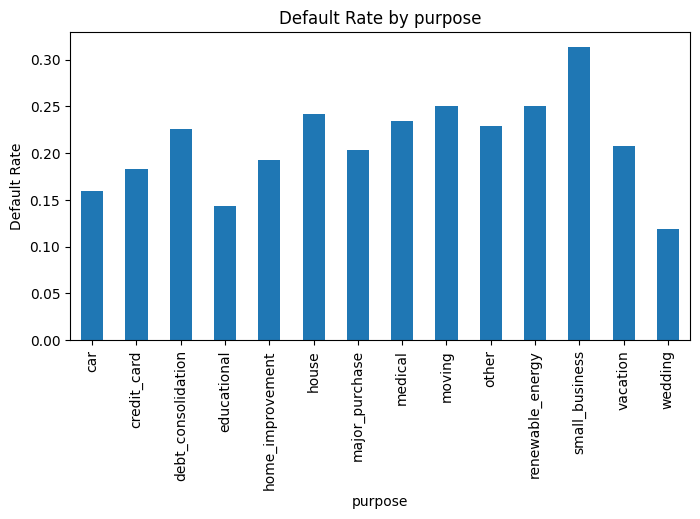

In [ ]:
categoricals = ['grade', 'home_ownership', 'verification_status', 'purpose']

for col in categoricals:
    plt.figure(figsize=(8,4))
    default_rate = df.groupby(col)['loan_status_binary'].mean()
    default_rate.plot(kind="bar")
    plt.ylabel("Default Rate")
    plt.title(f"Default Rate vs {col}")
    plt.show()


Dari visualisasi data dari fitur kategorikal yang telah dilakukan, maka didapatkan beberapa informasi berikut:
- `grade`: `grade` sangat berpengaruh pada default rate, dimana semakin buruk grade (menjauhi A) maka kemungkinan default semakin besar
- `home_ownership`: Peminjam dengan status `home_ownership` RENT,ANY, dan OWN memiliki default rate yang lebih tinggi dibanding kategori yang lainnya
- `verification_status`: Peminjam dengan status Verified justru memiliki kemungkinan default yang lebih tinggi dibanding not_verified
- `purpose`: Mayoritas peminjam di Lending Club yang disetujui memiliki tujuan untuk membuka bisnis kecil.

#### **Analisis Label**


Credit Risk Distribution:
           Count  Percentage (%)
Paid     1078739           78.56
Default   294415           21.44

Default Rate: 21.44%


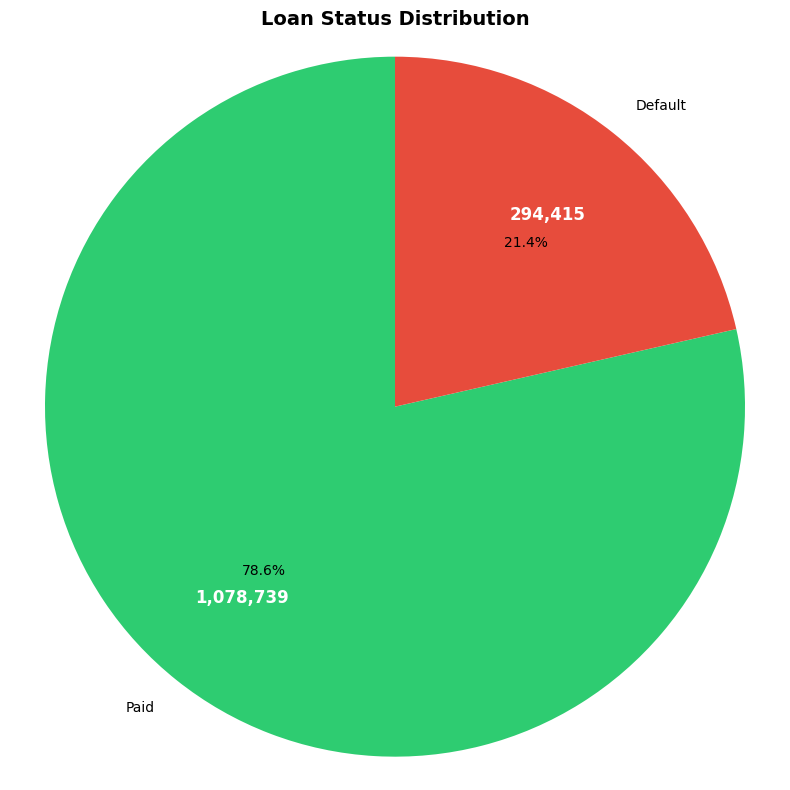

In [26]:
# Credit Risk Distribution
risk_counts = df["loan_status_binary"].value_counts().sort_index()
risk_percentages = df["loan_status_binary"].value_counts(normalize=True).sort_index() * 100

risk_summary = pd.DataFrame({
    "Count": risk_counts,
    "Percentage (%)": risk_percentages.round(2)
})
risk_summary.index = ['Paid', 'Default']
print("\nCredit Risk Distribution:")
print(risk_summary)
print(f"\nDefault Rate: {df['loan_status_binary'].mean()*100:.2f}%")


# Pie Chart
plt.figure(figsize=(8, 8))

labels = ['Paid', 'Default']
sizes = risk_counts.values
colors = ['#2ecc71', '#e74c3c']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Add count labels inside the pie chart
for i, (label, size) in enumerate(zip(labels, sizes)):
    angle = 90 + 360 * sum(sizes[:i]) / sum(sizes) + 180 * size / sum(sizes)
    plt.text(0.7 * np.cos(np.radians(angle)), 0.7 * np.sin(np.radians(angle)), 
             f'{size:,}', ha='center', va='center', fontsize=12, fontweight='bold', color='white')

plt.title("Loan Status Distribution", fontsize=14, fontweight='bold')
plt.axis('equal') 
plt.tight_layout()
plt.show()

Grafik distribusi kelas label menunjukkan adanya sedikit data imbalance, oleh karena itu dalam salah satu skenario akan dilakukan teknik sampling untuk mengatasinya.

**Heatmap**

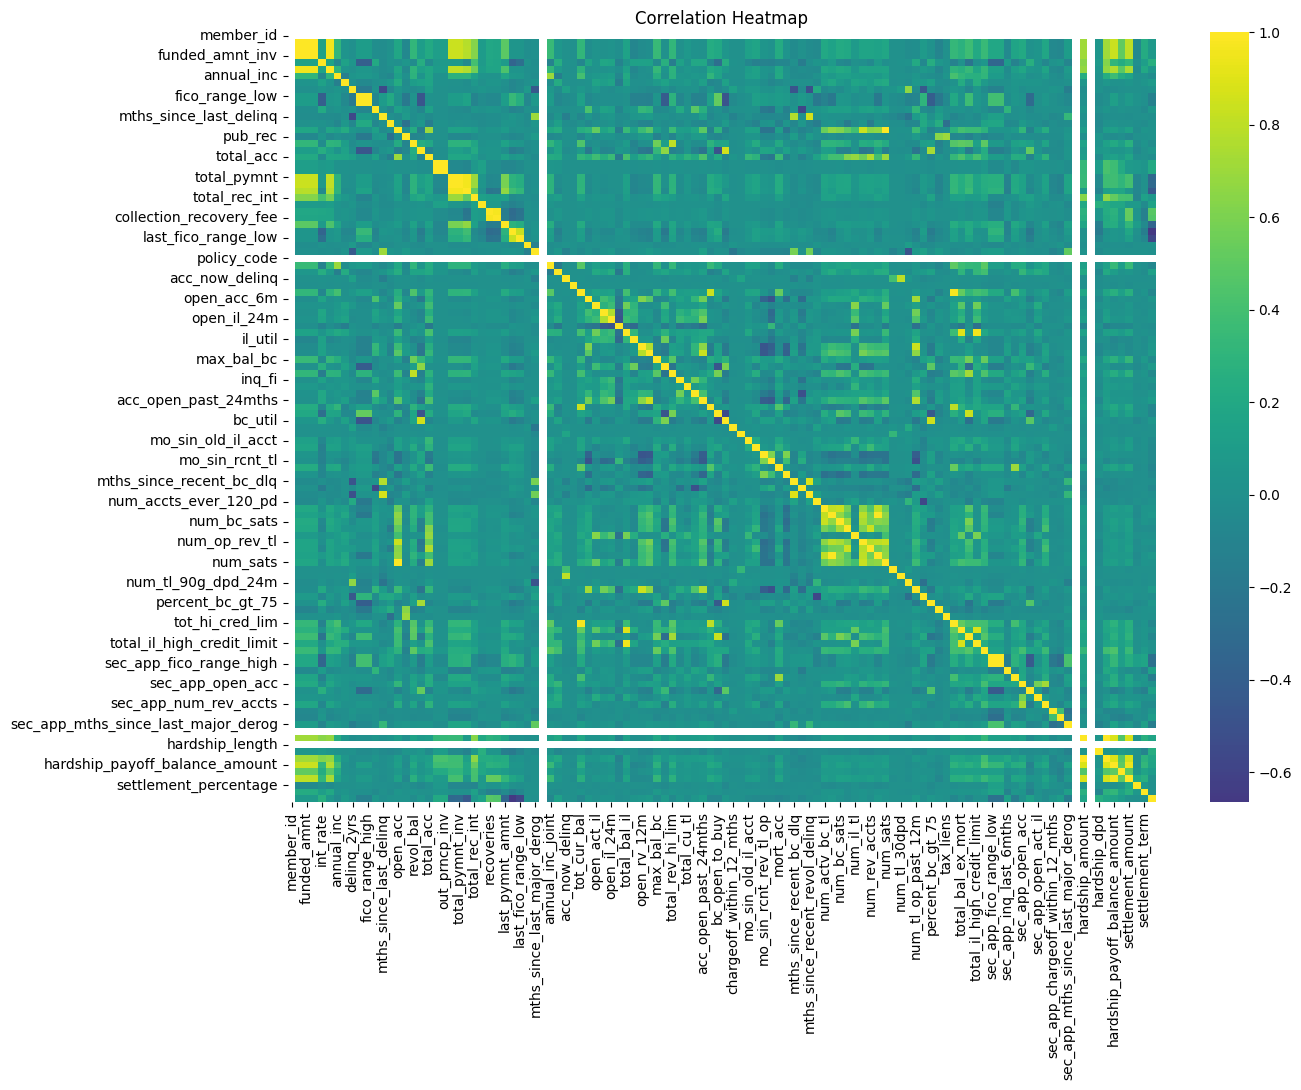

In [27]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap="viridis", center=0)
plt.title("Correlation Heatmap")
plt.show()


Untuk mempermudah pencarian fitur yang relevan dan mengetahui korelasi linear antar fitur untuk ditangani, maka dibuat pencarian pasangan dengan hubungan kuat (threshold +- 0.65). 

In [28]:
threshold = 0.65
high_corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .sort_values(ascending=False)
)

high_corr_pairs[high_corr_pairs > threshold]


sec_app_fico_range_low                      sec_app_fico_range_high                       1.000000
hardship_amount                             orig_projected_additional_accrued_interest    1.000000
fico_range_low                              fico_range_high                               1.000000
out_prncp                                   out_prncp_inv                                 0.999999
loan_amnt                                   funded_amnt                                   0.999564
total_pymnt                                 total_pymnt_inv                               0.999121
funded_amnt                                 funded_amnt_inv                               0.998939
open_acc                                    num_sats                                      0.998737
loan_amnt                                   funded_amnt_inv                               0.998407
num_actv_rev_tl                             num_rev_tl_bal_gt_0                           0.981982
tot_cur_ba

In [29]:
threshold = 0.65
high_corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .sort_values(ascending=False)
)

high_corr_pairs[high_corr_pairs < -threshold]

last_fico_range_high  loan_status_binary   -0.665064
dtype: float64

Didapatkan fitur-fitur yang berhubungan erat dengan fitur label ataupun fitur lainnya, yang nantinya akan menjadi informasi tambahan pada saat preprocessing, dimana fitur yang berkorelasi erat satu sama lain lebih baik di drop salah satu karena informasi yang didapatkan kurang lebih sama dan menggunakan fitur-fitur yang berhubungan kuat dengan kelas label saja.

# Data Preprocessing

### **Sample datas for experiment(don't run if want full data)**

In [239]:
original_df = df.copy()

# sampling
np.random.seed(123)
sample_indices = np.random.choice(original_df.index, size=200000, replace=False)
df = original_df.loc[sample_indices].reset_index(drop=True)


print(f"\nFinal sampled dataset: {df.shape}")
available = []
missing = []


Final sampled dataset: (200000, 157)


In [240]:
entity_info = pd.DataFrame({
    'member_id': df['member_id'].astype(str),
    'zip_code': df['zip_code'].astype(str),
    'addr_state': df['addr_state'].astype(str),
    'emp_title': df['emp_title'].astype(str),
    'purpose': df['purpose'].astype(str)
})

In [241]:
risk_counts = df["loan_status_binary"].value_counts().sort_index()
risk_percentages = df["loan_status_binary"].value_counts(normalize=True).sort_index() * 100

risk_summary = pd.DataFrame({
    "Count": risk_counts,
    "Percentage (%)": risk_percentages.round(2)
})
risk_summary.index = ['Paid', 'Default']
print("\nCredit Risk Distribution:")
print(risk_summary)
print(f"\nDefault Rate: {df['loan_status_binary'].mean()*100:.2f}%")


Credit Risk Distribution:
          Count  Percentage (%)
Paid     157019           78.51
Default   42981           21.49

Default Rate: 21.49%


## **Data Cleaning**

In [ ]:
# Employment length: '10+ years' to 10
if 'emp_length' in df.columns and df['emp_length'].dtype == 'object':
    df['emp_length'] = df['emp_length'].str.extract('(\d+)').fillna(0).astype(int)
   

# Loan term: ' 36 months' to 36  
if 'term' in df.columns and df['term'].dtype == 'object':
    df['term'] = df['term'].str.extract('(\d+)').fillna(0).astype(int)


## **Feature Engineering**

In [243]:
# FICO Score
fico_cols = [col for col in df.columns if 'fico' in col.lower()]

if fico_cols:    
    if 'fico_range_low' in df.columns and 'fico_range_high' in df.columns:
        df['fico_score'] = (df['fico_range_low'] + df['fico_range_high']) / 2
    elif len(fico_cols) > 0:
        df['fico_score'] = df[fico_cols[0]]      
else:
    df['fico_score'] = 700

# Creadit History age
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')
current_date = pd.Timestamp.now()
df['credit_age_years'] = (current_date - df['earliest_cr_line']).dt.days / 365
df['credit_age_years'] = df['credit_age_years'].fillna(df['credit_age_years'].median())

## **Feature Selection**

Selain fitur yang berkorelasi erat satu sama lain dan missing value banyak, terdapat fitur yang berpotensi menyebabkan data leakage karena mengandung informasi setelah sebuah request pinjaman disetujui, membuat prediksi berpotensi bias, sehingga perlu di abaikan juga. Fitur seperti `total_pymnt,total_rec_int, out_prncp, recoveries, collection_recovery_fee, last_pymnt_d` di abaikan. Fitur `grade` juga di abaikan karena informasi yang sama ada di fitur `sub_grade`.

In [244]:
desired_features = {
    # ---- Core Loan Info ----
    "loan_amnt": "Loan amount",
    "term": "Loan term",
    "int_rate": "Interest rate",
    "purpose": "Loan purpose",
    
    # ---- Borrower Profile ----
    "home_ownership": "Home ownership",
    "annual_inc": "Annual income",
    "dti": "Debt-to-income ratio",
    "emp_length": "Employment length",
    
    # ---- Credit Score ----
    "fico_score": "Credit score",
    "sub_grade": "LC credit grade",
    
    # ---- Credit History ----
    "delinq_2yrs": "Recent delinquencies",
    "credit_age_years": "Credit age",
    "inq_last_6mths": "Recent inquiries",
    "open_acc": "Open accounts",
    "pub_rec": "Public records",
    "total_acc": "Total accounts",
    "pub_rec_bankruptcies": "Bankruptcies",
    
    # ---- Credit Utilization ----
    "revol_util": "Revolving utilization",
    "revol_bal": "Revolving balance",
    
    # ---- Additional Risk Indicators ----
    "mort_acc": "Mortgage accounts",
    "collections_12_mths_ex_med": "Recent collections",
    "chargeoff_within_12_mths": "Recent chargeoffs",
    "tax_liens": "Tax liens",
}

for feature, description in desired_features.items():
    if feature in df.columns:
        available.append(feature)
        print(f" {feature:<25} {description}")
    else:
        missing.append(feature)
        print(f" {feature:<25} {description} [NOT FOUND]")

 loan_amnt                 Loan amount
 term                      Loan term
 int_rate                  Interest rate
 purpose                   Loan purpose
 home_ownership            Home ownership
 annual_inc                Annual income
 dti                       Debt-to-income ratio
 emp_length                Employment length
 fico_score                Credit score
 sub_grade                 LC credit grade
 delinq_2yrs               Recent delinquencies
 credit_age_years          Credit age
 inq_last_6mths            Recent inquiries
 open_acc                  Open accounts
 pub_rec                   Public records
 total_acc                 Total accounts
 pub_rec_bankruptcies      Bankruptcies
 revol_util                Revolving utilization
 revol_bal                 Revolving balance
 mort_acc                  Mortgage accounts
 collections_12_mths_ex_med Recent collections
 chargeoff_within_12_mths  Recent chargeoffs
 tax_liens                 Tax liens


## **Handling Missing Values**

In [245]:
# Check each available feature for nulls
missing_info = df[available].isnull().sum()
features_with_nulls = missing_info[missing_info > 0]

if len(features_with_nulls) > 0:    
    for feature, null_count in features_with_nulls.items():
        null_pct = (null_count / len(df)) * 100
   
    # Numeric features: fill with median 
    numeric_features = df[available].select_dtypes(include=[np.number]).columns
    for col in numeric_features:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
        
    
    # Categorical features: fill with mode
    categorical_features = df[available].select_dtypes(include=['object']).columns
    for col in categorical_features:
        if df[col].isnull().sum() > 0:
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)
df.isna().sum()

id                                                 0
member_id                                     200000
loan_amnt                                          0
funded_amnt                                        0
funded_amnt_inv                                    0
term                                               0
int_rate                                           0
installment                                        0
grade                                              0
sub_grade                                          0
emp_title                                      12898
emp_length                                         0
home_ownership                                     0
annual_inc                                         0
verification_status                                0
issue_d                                            0
loan_status                                        0
pymnt_plan                                         0
url                                           

## **Removing Outliers**

In [246]:
# Hapus DTI dengan nilai negatif
df = df[df['dti'] >= 0]
# Hapus total_rec_late_fee dengan nilai negatif
df = df[df['total_rec_late_fee'] >= 0]

## **Encoding**

In [247]:
categorical_to_encode = [
    'home_ownership',
    'purpose', 
    'sub_grade',
]
encoded_columns = []

for cat_feature in categorical_to_encode:
    if cat_feature in available:
        # Create a label encoder
        le = LabelEncoder()
        
        # Encode the feature
        encoded_name = f'{cat_feature}_encoded'
        df[encoded_name] = le.fit_transform(df[cat_feature])
        encoded_columns.append(encoded_name)
        
        # Show what we did
        n_categories = len(le.classes_)

## **Train-Test Split**

In [248]:
numeric_features = [f for f in available if f not in categorical_to_encode]
final_features = numeric_features + encoded_columns
print(df[final_features])

        loan_amnt  term  int_rate  annual_inc    dti  emp_length  fico_score  \
0         12000.0    60     13.49     65000.0  18.87           2       682.0   
1         18000.0    36     11.44     65000.0  14.90           2       667.0   
2         24000.0    36      5.32    103000.0  12.05           6       737.0   
3          5000.0    36     10.49     25000.0   6.39          10       692.0   
4         34625.0    60     14.49    200000.0  18.06          10       727.0   
...           ...   ...       ...         ...    ...         ...         ...   
199995    18350.0    36     10.99     50000.0  18.53           7       667.0   
199996    12000.0    36     10.99     55000.0  11.56           2       697.0   
199997    21000.0    36     12.69    267000.0   8.87          10       707.0   
199998     5000.0    36     12.99     28000.0  18.30           0       677.0   
199999    24000.0    60     11.49     60000.0  31.62           1       732.0   

        delinq_2yrs  credit_age_years  

In [249]:
X = df[final_features].copy()
y = df['loan_status_binary'].copy()

# Let's check our target distribution BEFORE splitting
print("\n📊 Target Distribution (Overall):")
for class_val in sorted(y.unique()):
    count = (y == class_val).sum()
    pct = (y == class_val).mean() * 100
    label = "Paid" if class_val == 0 else "Default"
    print(f"   {class_val} ({label:<7}): {count:>8,} samples ({pct:>5.1f}%)")

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42, stratify=y)


📊 Target Distribution (Overall):
   0 (Paid   ):  157,019 samples ( 78.5%)
   1 (Default):   42,981 samples ( 21.5%)


## **Scaling**

In [250]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# **Modelling**

In [251]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, is_keras=False):
    """
    Comprehensive evaluation of a classification model
    """
    print(f"\n{'='*60}")
    print(f"🔍 EVALUATING: {model_name}")
    print(f"{'='*60}")
    
    # Make predictions
    if is_keras:
        y_train_pred = (model.predict(X_train) > 0.5).astype(int).flatten()
        y_test_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
        y_train_proba = model.predict(X_train).flatten()
        y_test_proba = model.predict(X_test).flatten()
    else:
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Train_Accuracy': accuracy_score(y_train, y_train_pred),
        'Test_Accuracy': accuracy_score(y_test, y_test_pred),
        'Train_Precision': precision_score(y_train, y_train_pred),
        'Test_Precision': precision_score(y_test, y_test_pred),
        'Train_Recall': recall_score(y_train, y_train_pred),
        'Test_Recall': recall_score(y_test, y_test_pred),
        'Train_F1': f1_score(y_train, y_train_pred),
        'Test_F1': f1_score(y_test, y_test_pred),
        'Train_AUC': roc_auc_score(y_train, y_train_proba),
        'Test_AUC': roc_auc_score(y_test, y_test_proba)
    }
    
    # Print metrics table
    print("\n📊 PERFORMANCE METRICS:")
    print(f"{'Metric':<20} {'Train':<12} {'Test':<12}")
    print("-" * 44)
    print(f"{'Accuracy':<20} {metrics['Train_Accuracy']:<12.4f} {metrics['Test_Accuracy']:<12.4f}")
    print(f"{'Precision':<20} {metrics['Train_Precision']:<12.4f} {metrics['Test_Precision']:<12.4f}")
    print(f"{'Recall':<20} {metrics['Train_Recall']:<12.4f} {metrics['Test_Recall']:<12.4f}")
    print(f"{'F1-Score':<20} {metrics['Train_F1']:<12.4f} {metrics['Test_F1']:<12.4f}")
    print(f"{'AUC-ROC':<20} {metrics['Train_AUC']:<12.4f} {metrics['Test_AUC']:<12.4f}")
    
    # Confusion Matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    
    # Plot Confusion Matrices and ROC Curves
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Train Confusion Matrix
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                xticklabels=['Paid', 'Default'], yticklabels=['Paid', 'Default'])
    axes[0, 0].set_title(f'{model_name} - Train Confusion Matrix', fontweight='bold')
    axes[0, 0].set_ylabel('True Label')
    axes[0, 0].set_xlabel('Predicted Label')
    
    # Test Confusion Matrix
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1],
                xticklabels=['Paid', 'Default'], yticklabels=['Paid', 'Default'])
    axes[0, 1].set_title(f'{model_name} - Test Confusion Matrix', fontweight='bold')
    axes[0, 1].set_ylabel('True Label')
    axes[0, 1].set_xlabel('Predicted Label')
    
    # Train ROC Curve
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    axes[1, 0].plot(fpr_train, tpr_train, color='blue', lw=2, 
                    label=f'ROC curve (AUC = {metrics["Train_AUC"]:.4f})')
    axes[1, 0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].set_title(f'{model_name} - Train ROC Curve', fontweight='bold')
    axes[1, 0].legend(loc="lower right")
    axes[1, 0].grid(alpha=0.3)
    
    # Test ROC Curve
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    axes[1, 1].plot(fpr_test, tpr_test, color='green', lw=2, 
                    label=f'ROC curve (AUC = {metrics["Test_AUC"]:.4f})')
    axes[1, 1].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
    axes[1, 1].set_xlim([0.0, 1.0])
    axes[1, 1].set_ylim([0.0, 1.05])
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].set_title(f'{model_name} - Test ROC Curve', fontweight='bold')
    axes[1, 1].legend(loc="lower right")
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return metrics

## **Logistic Regression**


🔍 EVALUATING: Logistic Regression

📊 PERFORMANCE METRICS:
Metric               Train        Test        
--------------------------------------------
Accuracy             0.6566       0.6587      
Precision            0.3400       0.3405      
Recall               0.6349       0.6281      
F1-Score             0.4428       0.4416      
AUC-ROC              0.7080       0.7062      


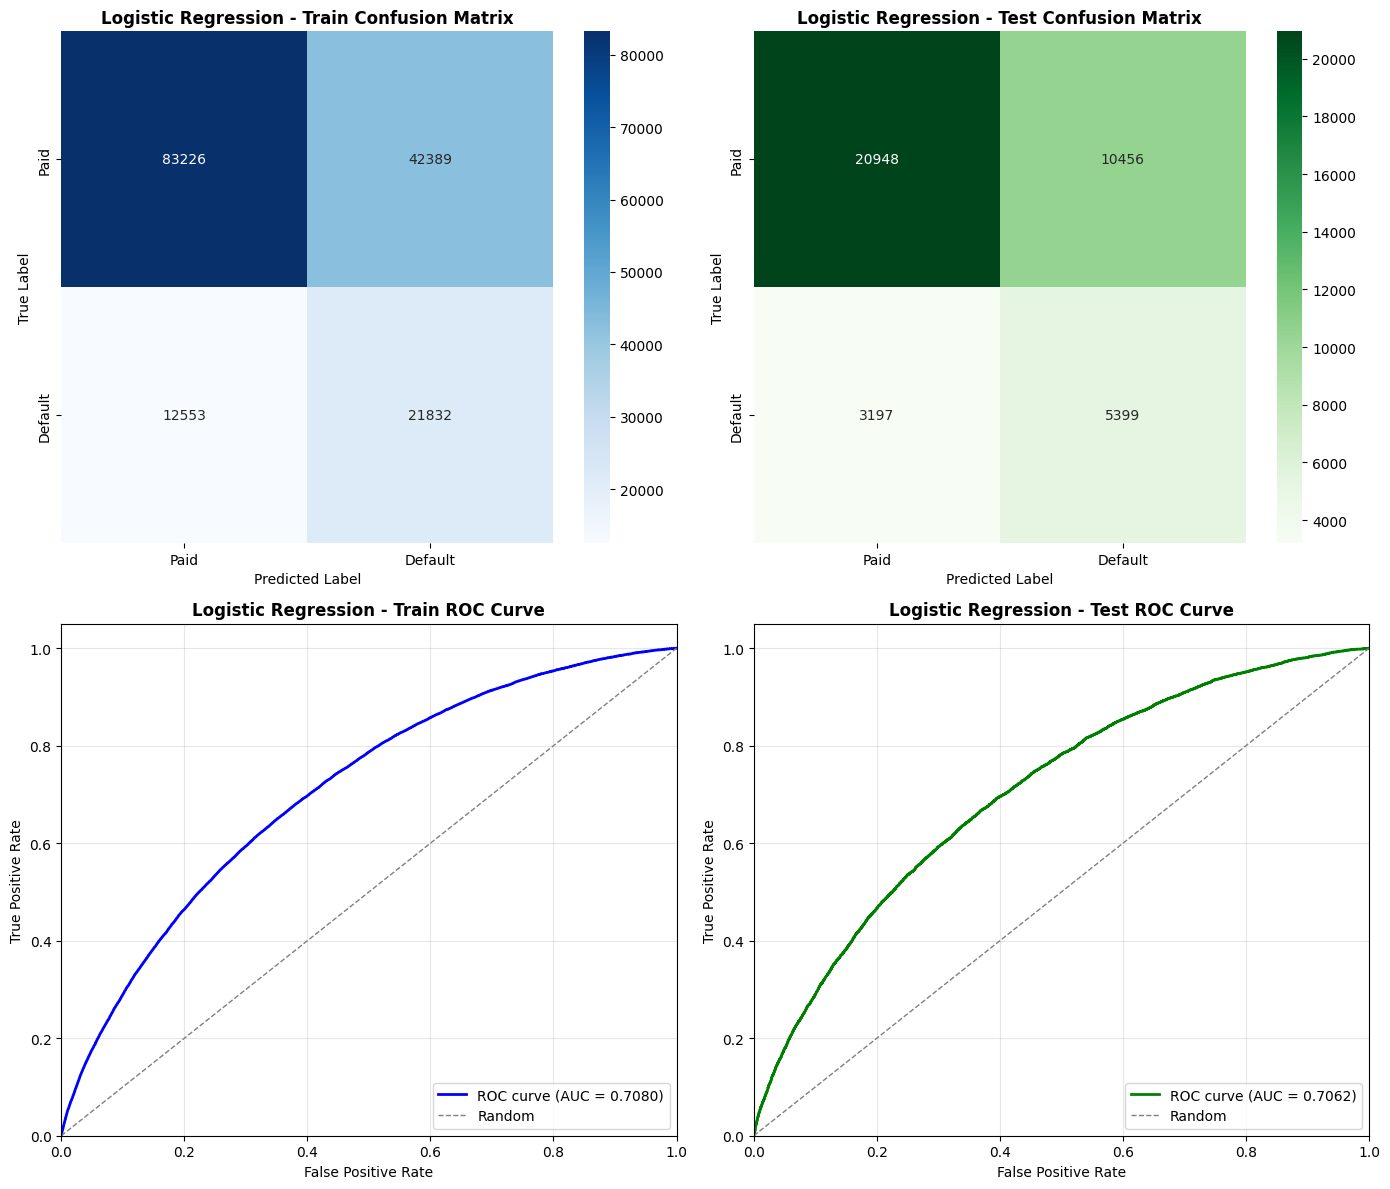

In [252]:
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

lr_metrics = evaluate_model(lr_model, X_train_scaled, X_test_scaled, 
                            y_train, y_test, "Logistic Regression")

## **Random Forest**


🚀 TRAINING MODEL 2: RANDOM FOREST

🔍 EVALUATING: Random Forest

📊 PERFORMANCE METRICS:
Metric               Train        Test        
--------------------------------------------
Accuracy             0.7938       0.7060      
Precision            0.5135       0.3716      
Recall               0.7666       0.5325      
F1-Score             0.6151       0.4377      
AUC-ROC              0.8727       0.7119      


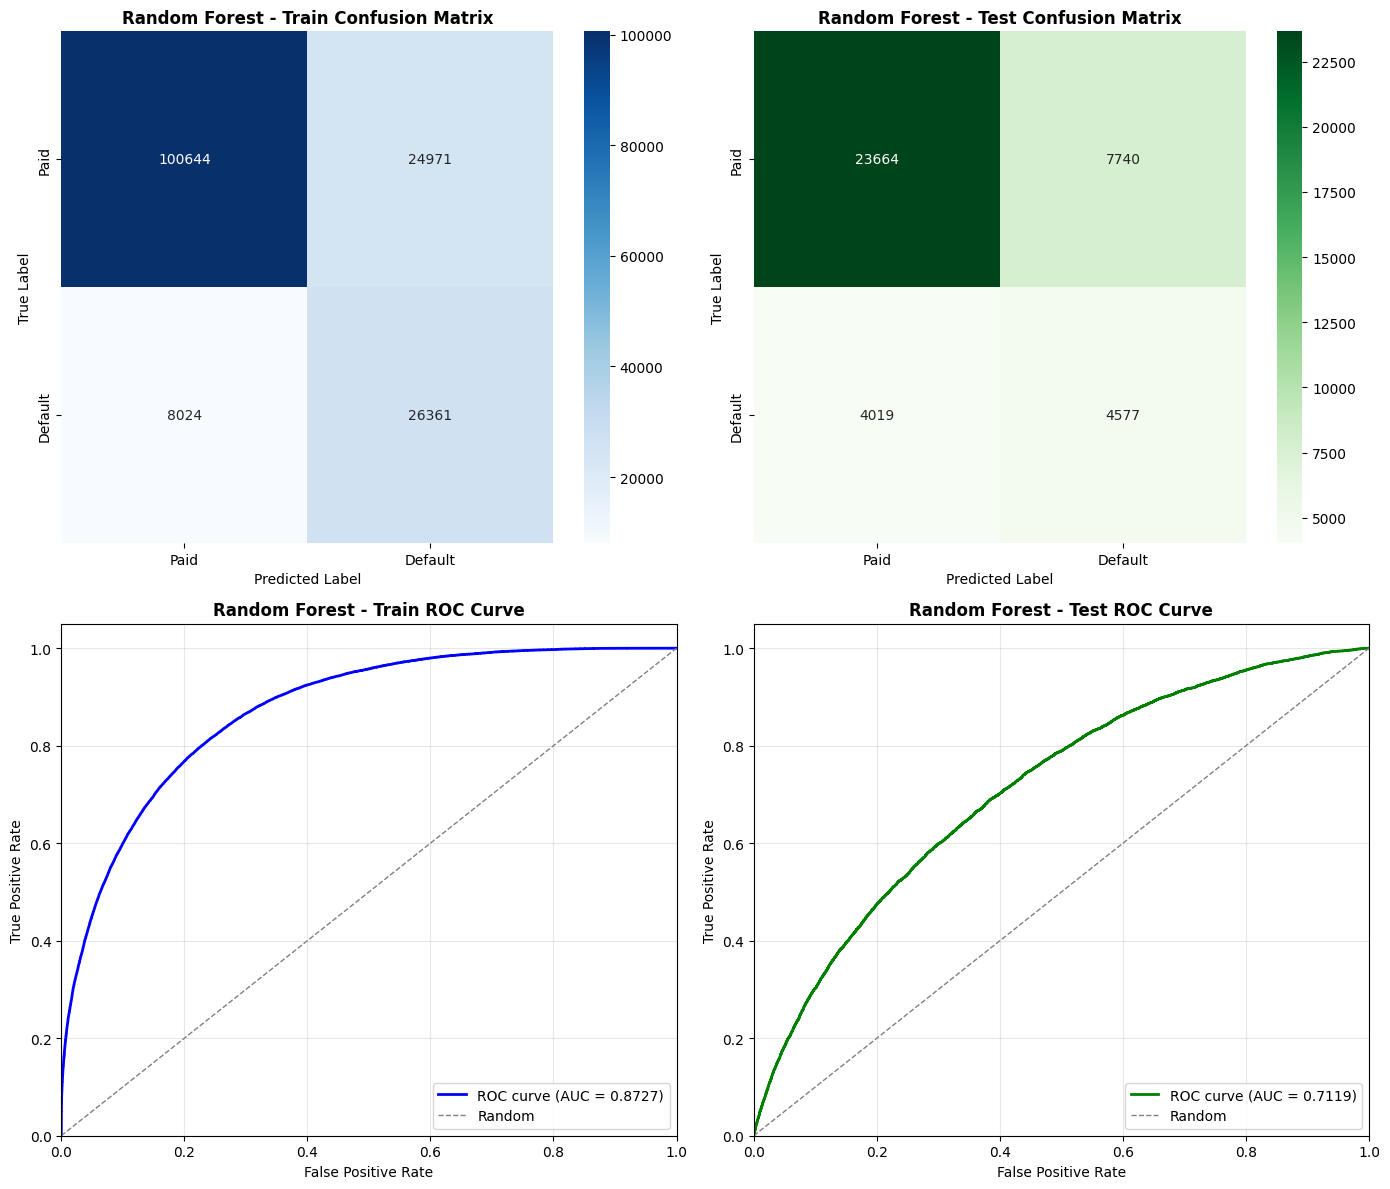

In [253]:
print("\n" + "="*60)
print("🚀 TRAINING MODEL 2: RANDOM FOREST")
print("="*60)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, 
                                 min_samples_split=10, min_samples_leaf=5,
                                 random_state=42, n_jobs=-1, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

rf_metrics = evaluate_model(rf_model, X_train_scaled, X_test_scaled, 
                            y_train, y_test, "Random Forest")

## **XGBoost**


🚀 TRAINING MODEL 3: XGBOOST

🔍 EVALUATING: XGBoost

📊 PERFORMANCE METRICS:
Metric               Train        Test        
--------------------------------------------
Accuracy             0.6734       0.6542      
Precision            0.3663       0.3415      
Recall               0.7119       0.6562      
F1-Score             0.4837       0.4492      
AUC-ROC              0.7566       0.7176      


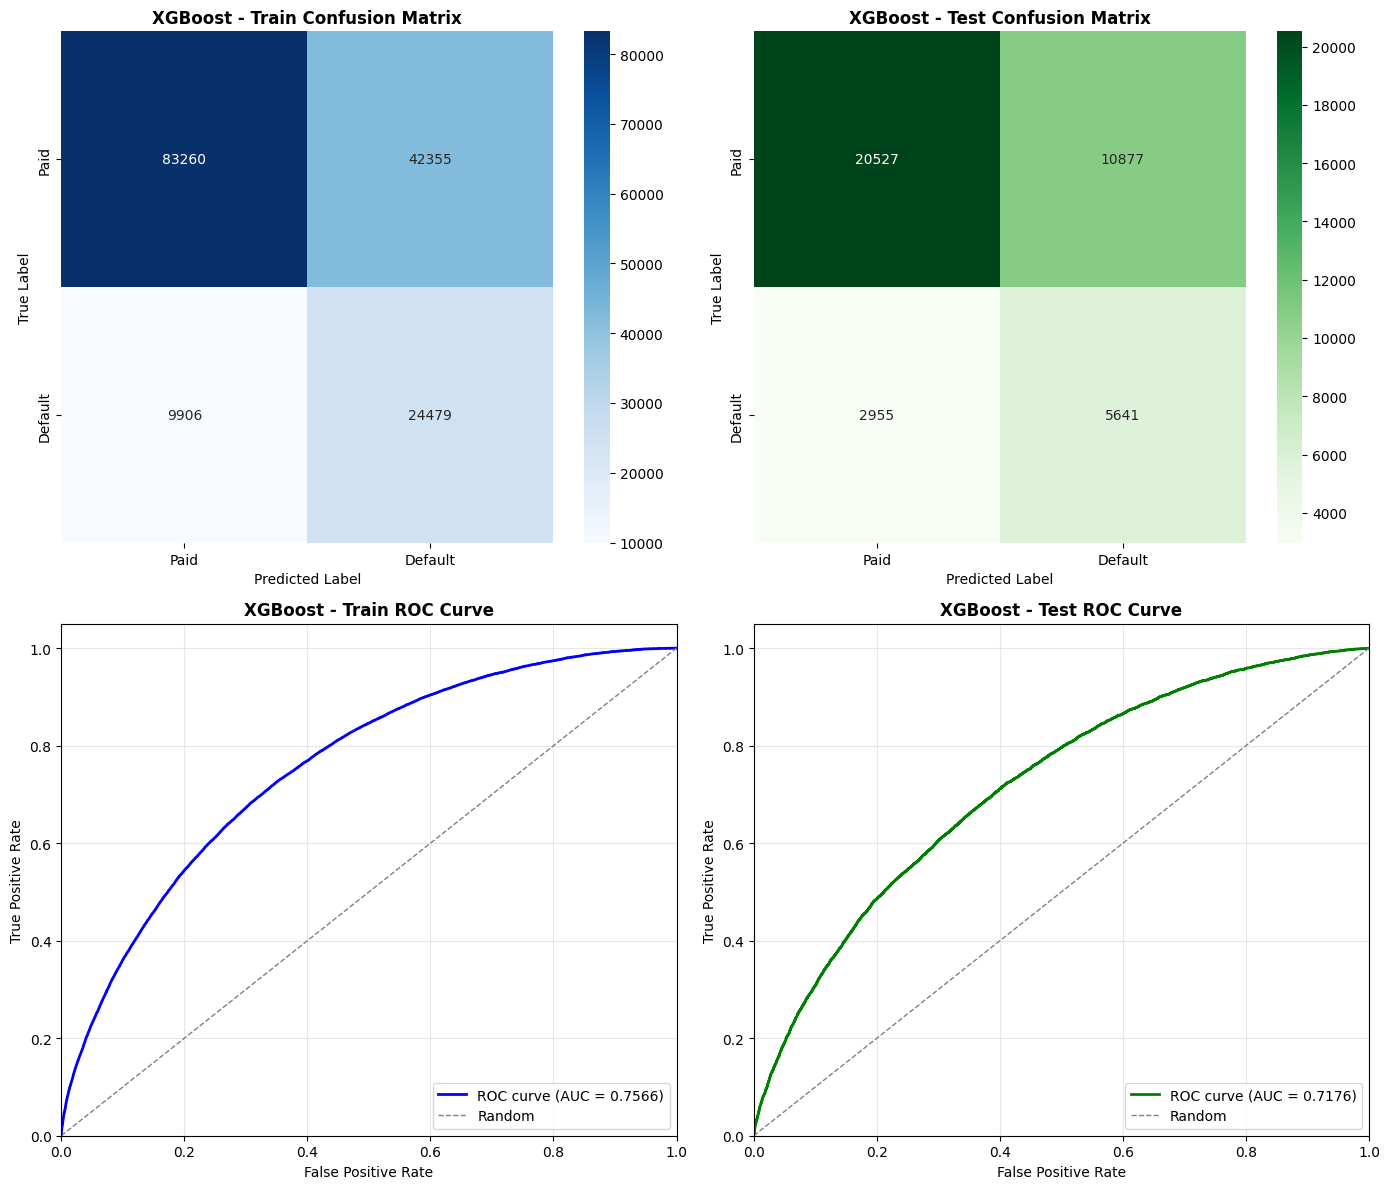

In [254]:
print("\n" + "="*60)
print("🚀 TRAINING MODEL 3: XGBOOST")
print("="*60)

# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                         scale_pos_weight=scale_pos_weight, random_state=42,
                         n_jobs=-1, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

xgb_metrics = evaluate_model(xgb_model, X_train_scaled, X_test_scaled, 
                             y_train, y_test, "XGBoost")

## **Artificial Neural Network (ANN)**


🚀 TRAINING MODEL 4: ARTIFICIAL NEURAL NETWORK

Training ANN...
Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5956 - loss: 1.0347 - val_accuracy: 0.6482 - val_loss: 0.5992
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6209 - loss: 0.9945 - val_accuracy: 0.6208 - val_loss: 0.6188
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6232 - loss: 0.9878 - val_accuracy: 0.6373 - val_loss: 0.6068
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6276 - loss: 0.9843 - val_accuracy: 0.6463 - val_loss: 0.6155
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6323 - loss: 0.9819 - val_accuracy: 0.6428 - val_loss: 0.6181
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6354 - loss: 0.9809 - val_accuracy: 0.6511 - val_loss: 0.6176
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6339 - loss: 0.9793 - val_accuracy: 0.6338 - val_loss: 0.6351
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 

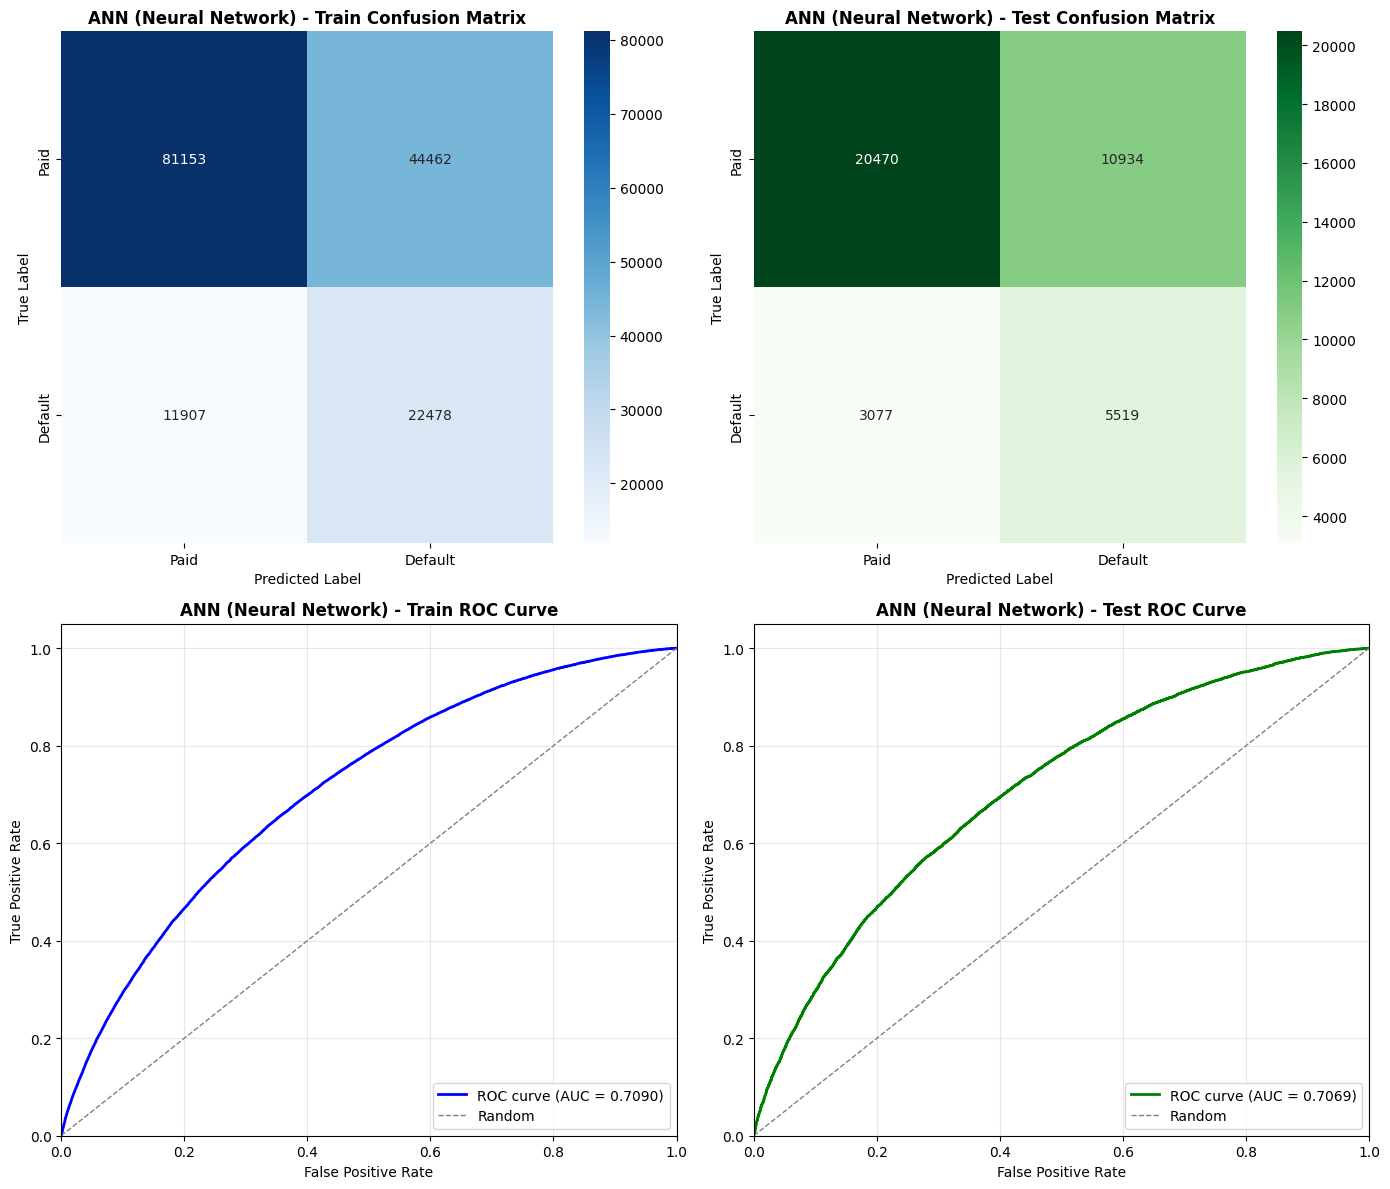

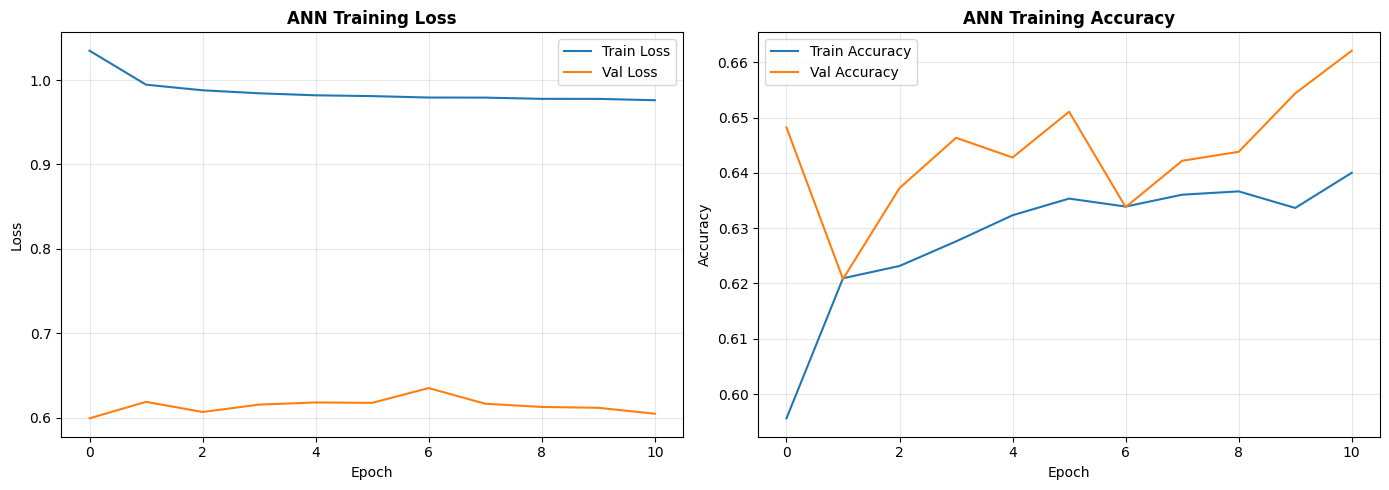

In [255]:
print("\n" + "="*60)
print("🚀 TRAINING MODEL 4: ARTIFICIAL NEURAL NETWORK")
print("="*60)

# Build ANN architecture
ann_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(16, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')
])

# Compile model
ann_model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Calculate class weights
class_weight_dict = {
    0: 1.0,
    1: (y_train == 0).sum() / (y_train == 1).sum()
}

# Train model
print("\nTraining ANN...")
history = ann_model.fit(X_train_scaled, y_train,
                       epochs=50,
                       batch_size=256,
                       validation_split=0.2,
                       callbacks=[early_stop],
                       class_weight=class_weight_dict,
                       verbose=1)

ann_metrics = evaluate_model(ann_model, X_train_scaled, X_test_scaled, 
                             y_train, y_test, "ANN (Neural Network)", is_keras=True)

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('ANN Training Loss', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('ANN Training Accuracy', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## **Ensemble (Boosting)**


🚀 TRAINING MODEL 5: ENSEMBLE (VOTING CLASSIFIER)

Ensemble model created with weighted voting...

🔍 EVALUATING: Ensemble (Weighted Voting)

📊 PERFORMANCE METRICS:
Metric               Train        Test        
--------------------------------------------
Accuracy             0.7128       0.6751      
Precision            0.4044       0.3522      
Recall               0.7110       0.6101      
F1-Score             0.5156       0.4466      
AUC-ROC              0.7880       0.7164      


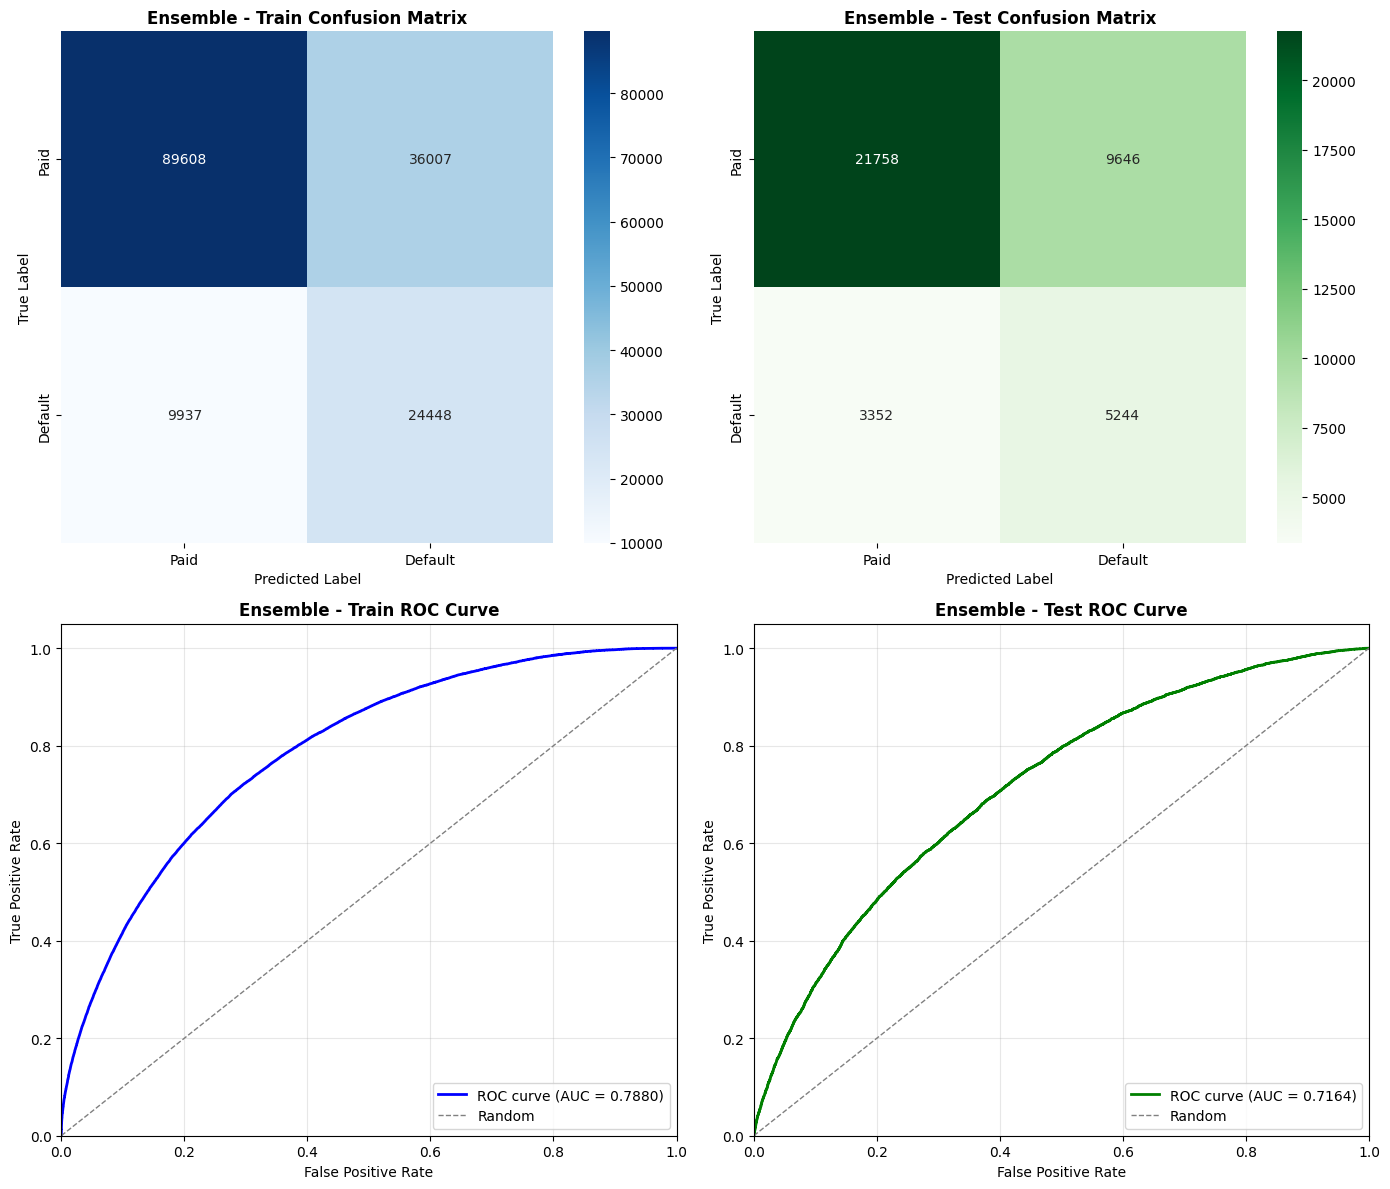

In [256]:
print("\n" + "="*60)
print("🚀 TRAINING MODEL 5: ENSEMBLE (VOTING CLASSIFIER)")
print("="*60)

# Since Keras wrapper is problematic with VotingClassifier,
# we'll create a custom ensemble using weighted averaging of probabilities

class CustomEnsemble:
    def __init__(self, models, weights, is_keras_flags):
        self.models = models
        self.weights = np.array(weights) / np.sum(weights)  # Normalize weights
        self.is_keras_flags = is_keras_flags
        
    def predict_proba(self, X):
        """Weighted average of predicted probabilities"""
        probas = []
        for model, is_keras in zip(self.models, self.is_keras_flags):
            if is_keras:
                proba = model.predict(X, verbose=0).flatten()
                proba = np.vstack([1 - proba, proba]).T
            else:
                proba = model.predict_proba(X)
            probas.append(proba)
        
        # Weighted average
        weighted_proba = np.zeros_like(probas[0])
        for proba, weight in zip(probas, self.weights):
            weighted_proba += proba * weight
            
        return weighted_proba
    
    def predict(self, X):
        """Predict class labels"""
        proba = self.predict_proba(X)
        return (proba[:, 1] > 0.5).astype(int)

# Create custom ensemble
ensemble_model = CustomEnsemble(
    models=[lr_model, rf_model, xgb_model, ann_model],
    weights=[1, 2, 2, 1],  # Give more weight to RF and XGBoost
    is_keras_flags=[False, False, False, True]
)

print("\nEnsemble model created with weighted voting...")

# Custom evaluation for ensemble (no fitting needed)
print(f"\n{'='*60}")
print(f"🔍 EVALUATING: Ensemble (Weighted Voting)")
print(f"{'='*60}")

# Make predictions
y_train_pred = ensemble_model.predict(X_train_scaled)
y_test_pred = ensemble_model.predict(X_test_scaled)
y_train_proba = ensemble_model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = ensemble_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
ensemble_metrics = {
    'Model': 'Ensemble (Weighted Voting)',
    'Train_Accuracy': accuracy_score(y_train, y_train_pred),
    'Test_Accuracy': accuracy_score(y_test, y_test_pred),
    'Train_Precision': precision_score(y_train, y_train_pred),
    'Test_Precision': precision_score(y_test, y_test_pred),
    'Train_Recall': recall_score(y_train, y_train_pred),
    'Test_Recall': recall_score(y_test, y_test_pred),
    'Train_F1': f1_score(y_train, y_train_pred),
    'Test_F1': f1_score(y_test, y_test_pred),
    'Train_AUC': roc_auc_score(y_train, y_train_proba),
    'Test_AUC': roc_auc_score(y_test, y_test_proba)
}

# Print metrics table
print("\n📊 PERFORMANCE METRICS:")
print(f"{'Metric':<20} {'Train':<12} {'Test':<12}")
print("-" * 44)
print(f"{'Accuracy':<20} {ensemble_metrics['Train_Accuracy']:<12.4f} {ensemble_metrics['Test_Accuracy']:<12.4f}")
print(f"{'Precision':<20} {ensemble_metrics['Train_Precision']:<12.4f} {ensemble_metrics['Test_Precision']:<12.4f}")
print(f"{'Recall':<20} {ensemble_metrics['Train_Recall']:<12.4f} {ensemble_metrics['Test_Recall']:<12.4f}")
print(f"{'F1-Score':<20} {ensemble_metrics['Train_F1']:<12.4f} {ensemble_metrics['Test_F1']:<12.4f}")
print(f"{'AUC-ROC':<20} {ensemble_metrics['Train_AUC']:<12.4f} {ensemble_metrics['Test_AUC']:<12.4f}")

# Confusion Matrix
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot Confusion Matrices and ROC Curves
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Train Confusion Matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Paid', 'Default'], yticklabels=['Paid', 'Default'])
axes[0, 0].set_title('Ensemble - Train Confusion Matrix', fontweight='bold')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# Test Confusion Matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1],
            xticklabels=['Paid', 'Default'], yticklabels=['Paid', 'Default'])
axes[0, 1].set_title('Ensemble - Test Confusion Matrix', fontweight='bold')
axes[0, 1].set_ylabel('True Label')
axes[0, 1].set_xlabel('Predicted Label')

# Train ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
axes[1, 0].plot(fpr_train, tpr_train, color='blue', lw=2, 
                label=f'ROC curve (AUC = {ensemble_metrics["Train_AUC"]:.4f})')
axes[1, 0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('Ensemble - Train ROC Curve', fontweight='bold')
axes[1, 0].legend(loc="lower right")
axes[1, 0].grid(alpha=0.3)

# Test ROC Curve
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
axes[1, 1].plot(fpr_test, tpr_test, color='green', lw=2, 
                label=f'ROC curve (AUC = {ensemble_metrics["Test_AUC"]:.4f})')
axes[1, 1].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('Ensemble - Test ROC Curve', fontweight='bold')
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


# **Scenario 1: GNN vs No GNN**


STEP 2: Building graphs for train and test sets
RangeIndex(start=0, stop=160000, step=1)
RangeIndex(start=0, stop=40000, step=1)

Building train graph...
  Graph structure:
    - Transaction nodes: 160,000
    - Entity nodes: 954
      • Members: 0
      • Zip codes: 889
      • States: 51
      • Purposes: 14
    - Total nodes: 160,954
  Computing 5-NN connections between similar transactions...
  Total edges: 1,760,000

Building test graph...
  Graph structure:
    - Transaction nodes: 40,000
    - Entity nodes: 920
      • Members: 0
      • Zip codes: 856
      • States: 50
      • Purposes: 14
    - Total nodes: 40,920
  Computing 5-NN connections between similar transactions...
  Total edges: 440,000

STEP 3: Training GraphSAGE encoder
  Training on device: cpu
  Class distribution: Non-default=125,615, Default=34,385
  Positive class weight: 3.65
  Epoch 1/30 - Loss: 0.0443, Acc: 0.5160, F1: 0.3030
  Epoch 5/30 - Loss: 0.0330, Acc: 0.7851, F1: 0.0000
  Epoch 10/30 - Loss: 0.032

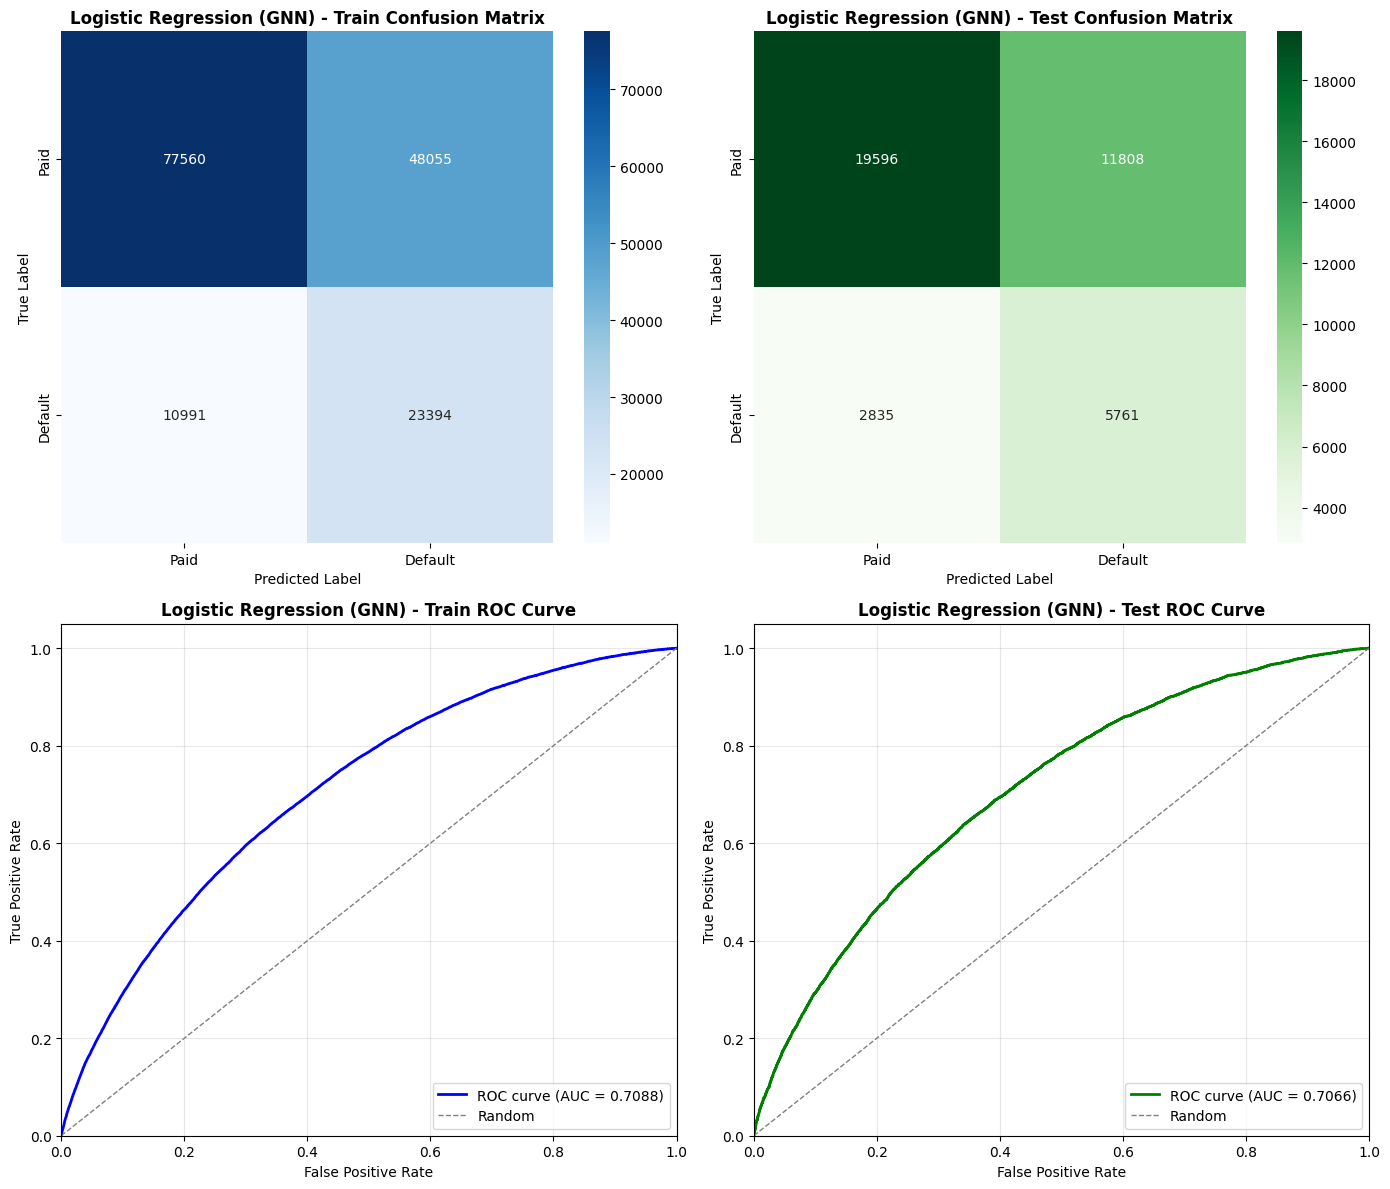


Training Random Forest (GNN)...

🔍 EVALUATING: Random Forest (GNN)

📊 PERFORMANCE METRICS:
Metric               Train        Test        
--------------------------------------------
Accuracy             0.7568       0.6858      
Precision            0.4597       0.3566      
Recall               0.7509       0.5745      
F1-Score             0.5703       0.4400      
AUC-ROC              0.8485       0.7096      


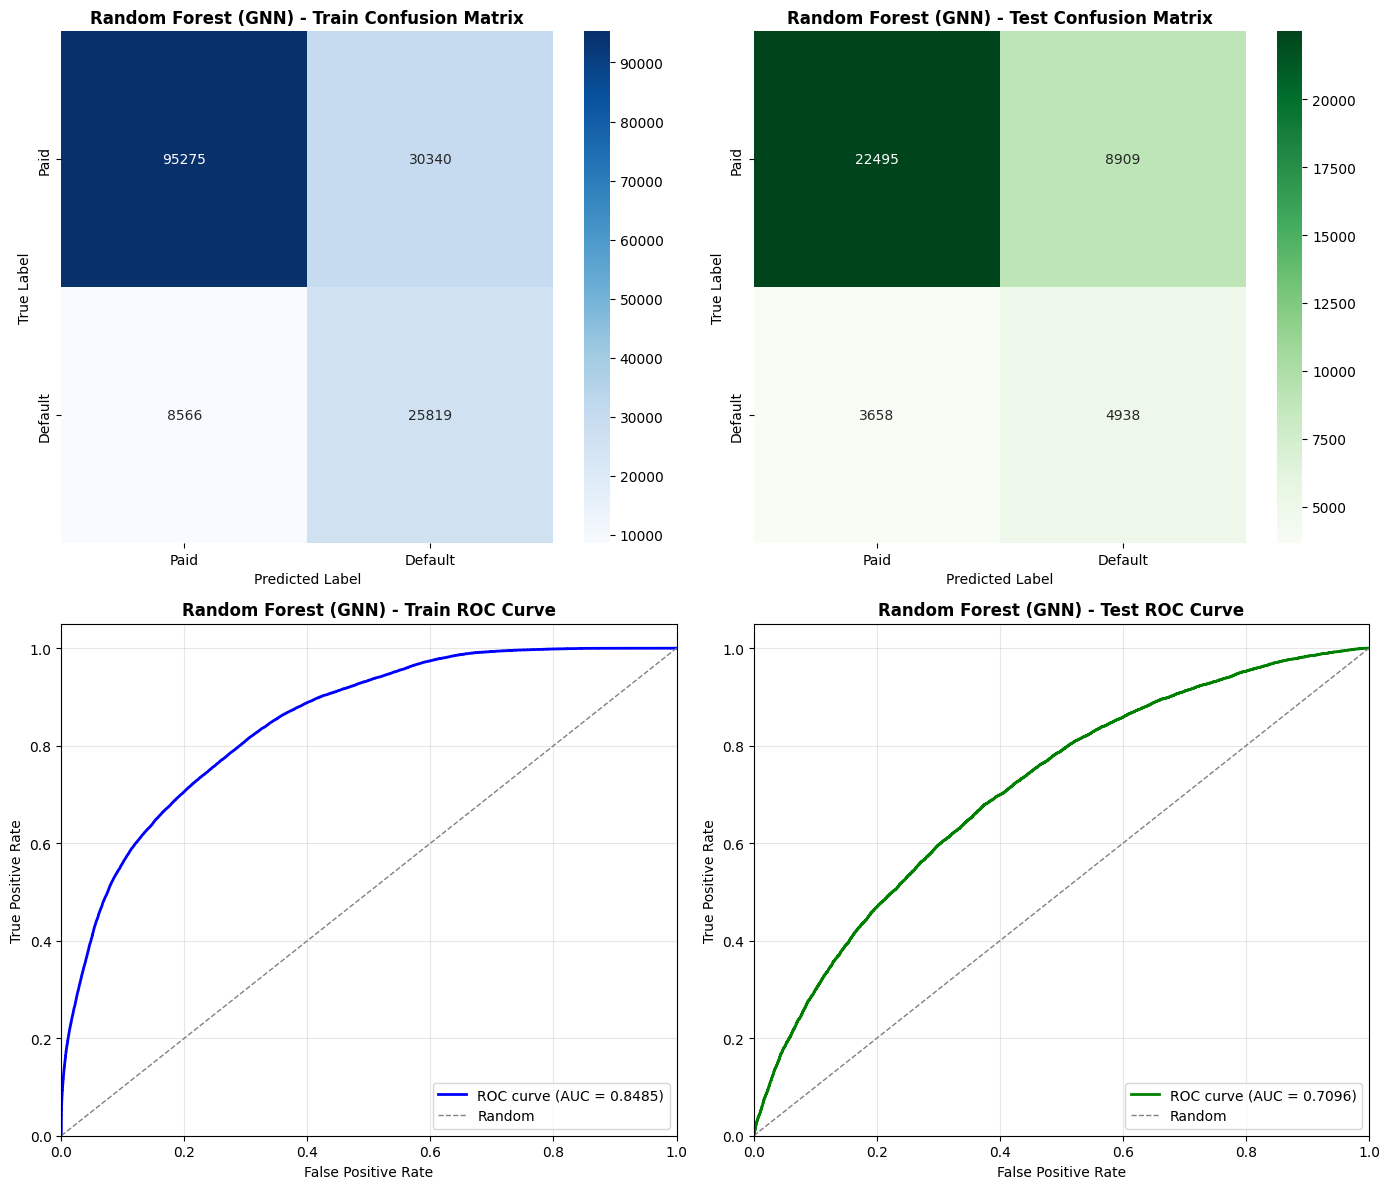


Training XGBoost (GNN)...

🔍 EVALUATING: XGBoost (GNN)

📊 PERFORMANCE METRICS:
Metric               Train        Test        
--------------------------------------------
Accuracy             0.6655       0.6492      
Precision            0.3603       0.3389      
Recall               0.7172       0.6652      
F1-Score             0.4796       0.4491      
AUC-ROC              0.7556       0.7177      


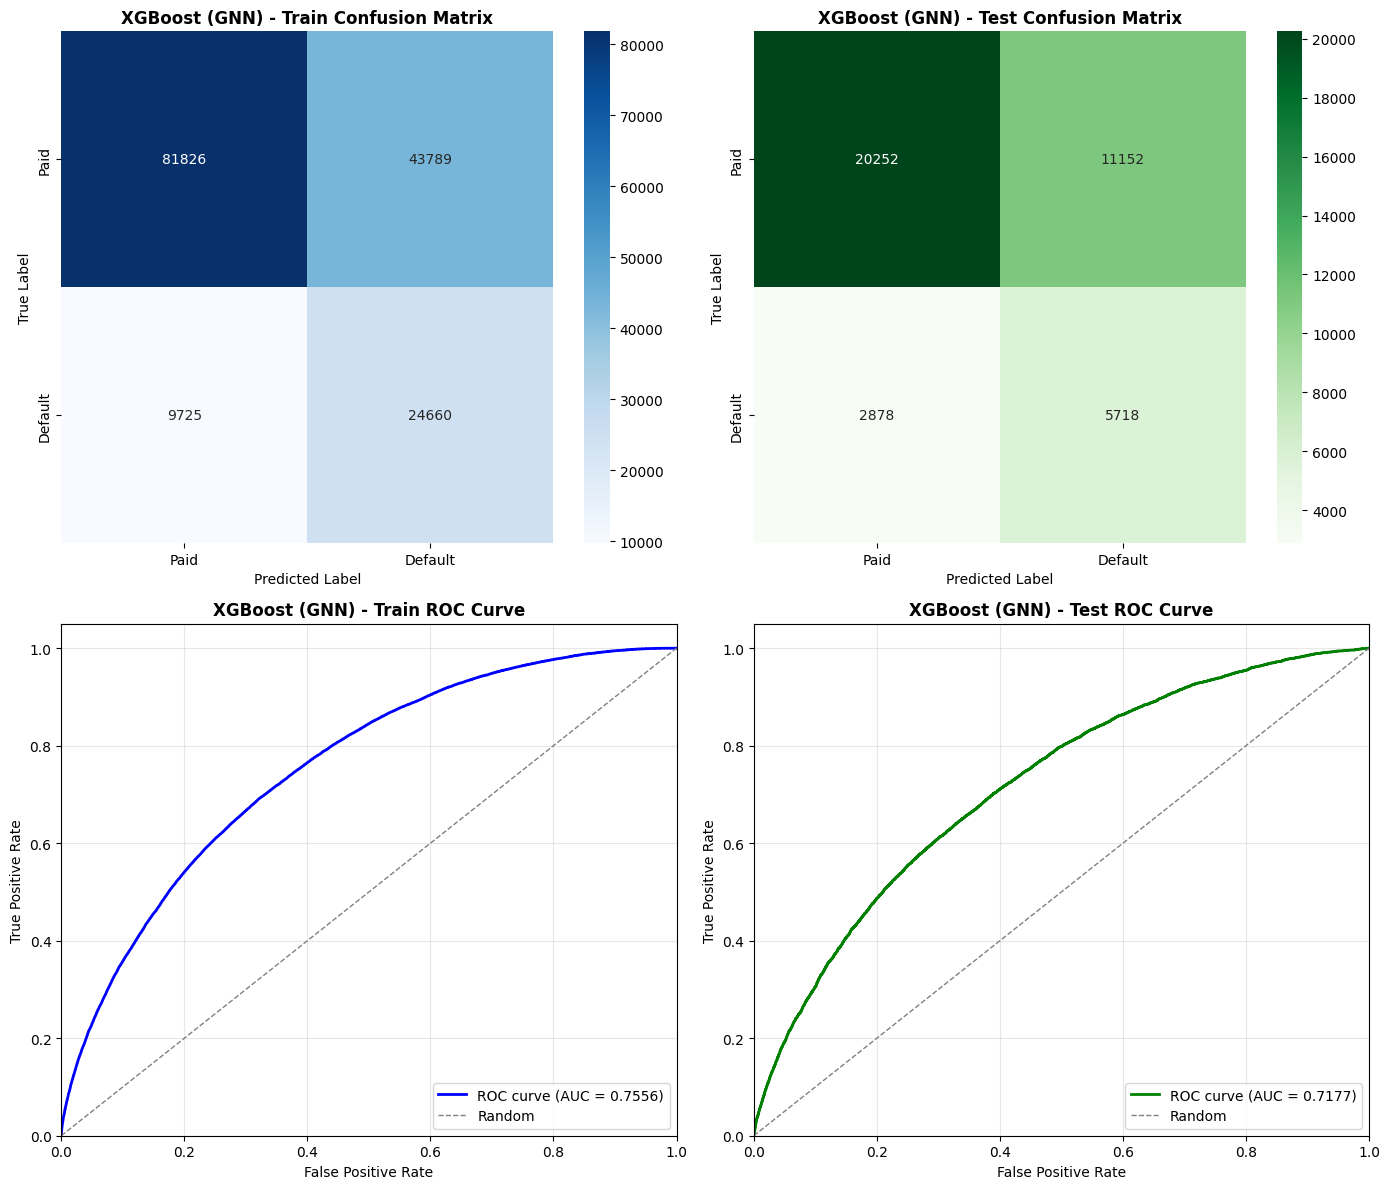


Training ANN (GNN)...
Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5939 - loss: 1.0416 - val_accuracy: 0.6137 - val_loss: 0.6300
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6169 - loss: 0.9971 - val_accuracy: 0.6141 - val_loss: 0.6281
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6215 - loss: 0.9921 - val_accuracy: 0.6222 - val_loss: 0.6321
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6253 - loss: 0.9864 - val_accuracy: 0.6164 - val_loss: 0.6365
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6279 - loss: 0.9835 - val_accuracy: 0.6235 - val_loss: 0.6264
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6288 - loss: 0.9812 - val_accuracy: 0.6288 - val_loss: 0.6325
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6339 - loss: 0.9804 - val_accuracy: 0.6356 - val_loss: 0.6261
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6320 - loss: 0.

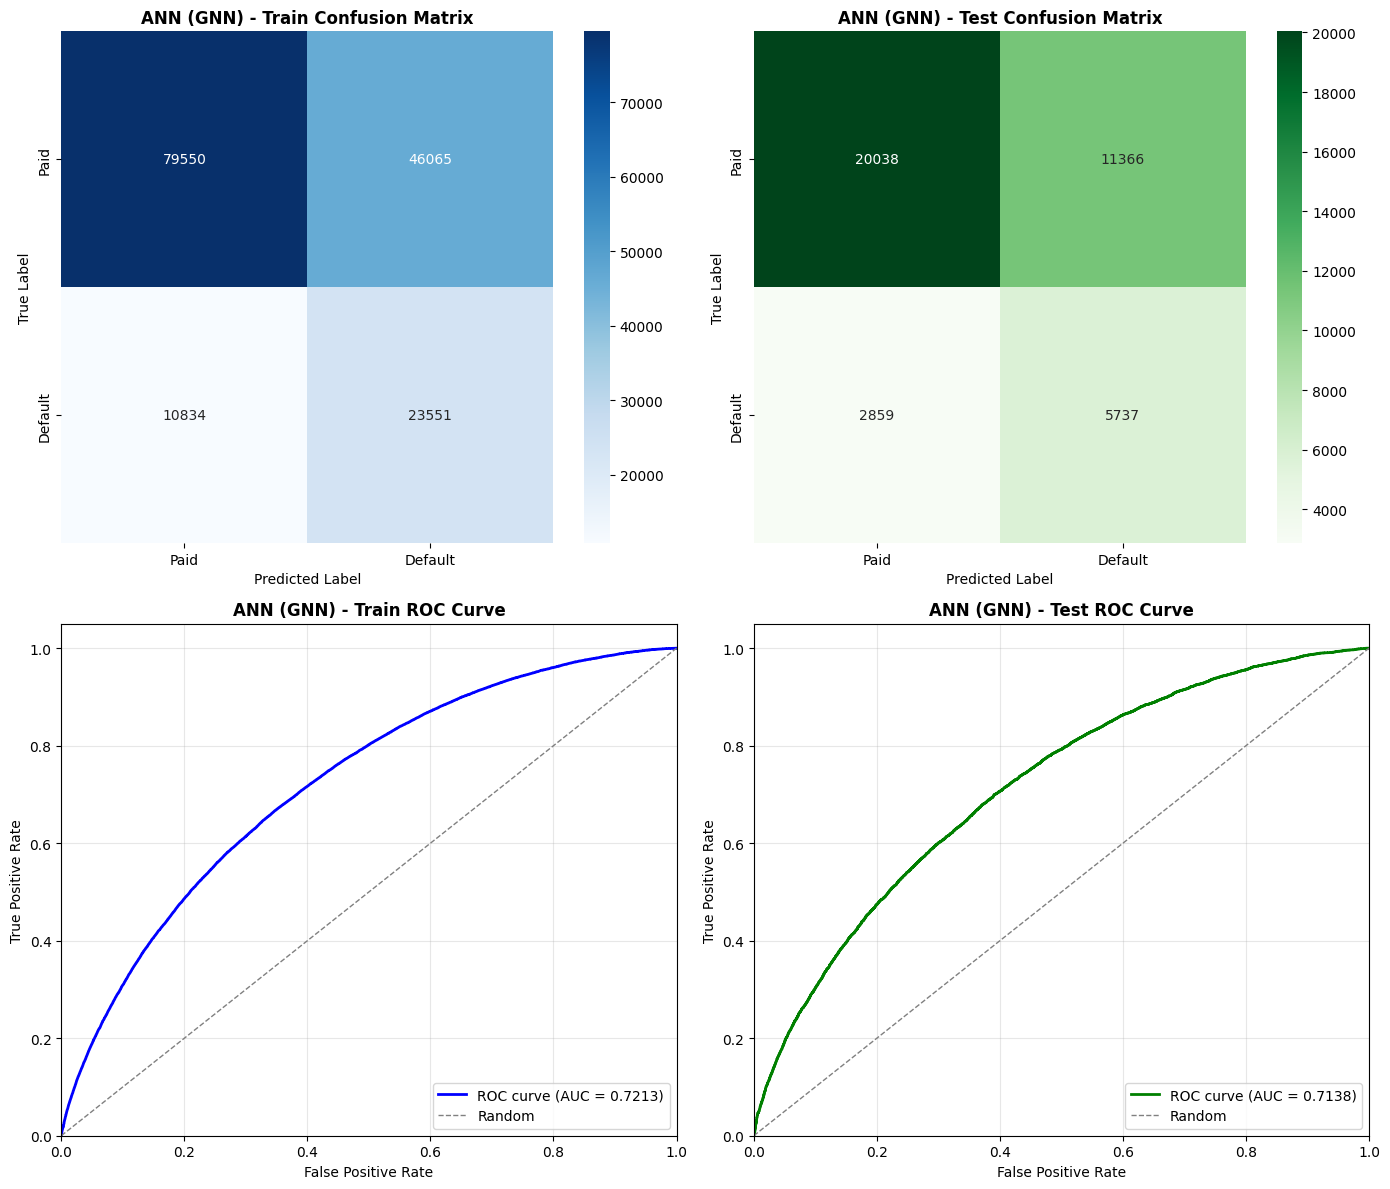


Creating Ensemble (GNN)...

🔍 EVALUATING: Ensemble (GNN)

Metric               Train        Test        
--------------------------------------------
Accuracy             0.6884       0.6599      
Precision            0.3810       0.3440      
Recall               0.7201       0.6425      
F1                   0.4984       0.4481      
AUC                  0.7792       0.7162      

FINAL COMPARISON: GNN vs No-GNN Performance

📊 Test Set Performance Comparison:
              Model  No-GNN AUC  GNN AUC     AUC Δ  No-GNN F1   GNN F1      F1 Δ  No-GNN Recall  GNN Recall  Recall Δ
Logistic Regression    0.706162 0.706568  0.000406   0.441618 0.440359 -0.001259       0.628083    0.670195  0.042113
      Random Forest    0.711934 0.709575 -0.002359   0.437718 0.440048  0.002330       0.532457    0.574453  0.041996
            XGBoost    0.717581 0.717660  0.000079   0.449232 0.449069 -0.000162       0.656235    0.665193  0.008958
                ANN    0.706866 0.713842  0.006975   0.440656

In [ ]:
def build_credit_risk_graph(features_df, entity_df, k_similar=5):
    """
    Build heterogeneous graph for credit risk with:
    - Transaction nodes (loan applications with features)
    - Entity nodes (member_id, zip_code, addr_state, purpose)
    - Edges: tx->entity (shared attributes) + tx->tx (similar features)
    
    Args:
        features_df: Scaled feature DataFrame (n_samples x n_features)
        entity_df: DataFrame with entity columns aligned with features_df
        k_similar: Number of similar transactions to connect
    
    Returns:
        torch_geometric.data.Data object
    """
    X = features_df.values.astype(np.float32)
    n_transactions = X.shape[0]
    entity_offset = n_transactions
    
    # Create entity maps (entity_value -> node_index)
    member_map = {}
    zip_map = {}
    state_map = {}
    purpose_map = {}
    current_id = entity_offset
    
    # Build member entity nodes
    for member in entity_df['member_id'].dropna().unique():
        if member != 'nan' and member not in member_map:
            member_map[member] = current_id
            current_id += 1
    
    # Build zip code entity nodes
    for zipcode in entity_df['zip_code'].dropna().unique():
        if zipcode != 'nan' and zipcode not in zip_map:
            zip_map[zipcode] = current_id
            current_id += 1
    
    # Build state entity nodes
    for state in entity_df['addr_state'].dropna().unique():
        if state != 'nan' and state not in state_map:
            state_map[state] = current_id
            current_id += 1
    
    # Build purpose entity nodes
    for purpose in entity_df['purpose'].dropna().unique():
        if purpose != 'nan' and purpose not in purpose_map:
            purpose_map[purpose] = current_id
            current_id += 1
    
    total_nodes = current_id
    n_entities = total_nodes - n_transactions
    
    print(f"  Graph structure:")
    print(f"    - Transaction nodes: {n_transactions:,}")
    print(f"    - Entity nodes: {n_entities:,}")
    print(f"      • Members: {len(member_map):,}")
    print(f"      • Zip codes: {len(zip_map):,}")
    print(f"      • States: {len(state_map):,}")
    print(f"      • Purposes: {len(purpose_map):,}")
    print(f"    - Total nodes: {total_nodes:,}")
    
    # Build edges
    edges = []
    edge_types = []  # 0=member, 1=zip, 2=state, 3=purpose, 4=similar_tx
    
    # Connect transactions to entity nodes (star topology)
    for tx_idx in range(n_transactions):
        # Connect to member entity
        member = entity_df.iloc[tx_idx]['member_id']
        if member != 'nan' and member in member_map:
            entity_node = member_map[member]
            edges.extend([(tx_idx, entity_node), (entity_node, tx_idx)])
            edge_types.extend([0, 0])
        
        # Connect to zip code entity
        zipcode = entity_df.iloc[tx_idx]['zip_code']
        if zipcode != 'nan' and zipcode in zip_map:
            entity_node = zip_map[zipcode]
            edges.extend([(tx_idx, entity_node), (entity_node, tx_idx)])
            edge_types.extend([1, 1])
        
        # Connect to state entity
        state = entity_df.iloc[tx_idx]['addr_state']
        if state != 'nan' and state in state_map:
            entity_node = state_map[state]
            edges.extend([(tx_idx, entity_node), (entity_node, tx_idx)])
            edge_types.extend([2, 2])
        
        # Connect to purpose entity
        purpose = entity_df.iloc[tx_idx]['purpose']
        if purpose != 'nan' and purpose in purpose_map:
            entity_node = purpose_map[purpose]
            edges.extend([(tx_idx, entity_node), (entity_node, tx_idx)])
            edge_types.extend([3, 3])
    
    # Add k-NN connections between similar transactions (feature-based)
    if k_similar > 0 and n_transactions > k_similar:
        print(f"  Computing {k_similar}-NN connections between similar transactions...")
        pca_dim = min(16, X.shape[1])
        pca = PCA(n_components=pca_dim, random_state=42)
        X_reduced = pca.fit_transform(X)
        
        nbrs = NearestNeighbors(n_neighbors=k_similar+1, algorithm="ball_tree", n_jobs=-1)
        nbrs.fit(X_reduced)
        _, neighbors = nbrs.kneighbors(X_reduced)
        
        for i in range(n_transactions):
            for j in neighbors[i][1:]:  # Skip self
                edges.append((i, int(j)))
                edge_types.append(4)
    
    # Convert to tensors
    if len(edges) == 0:
        edge_index = torch.tensor([[i, i] for i in range(n_transactions)], dtype=torch.long).t()
        edge_type = torch.zeros(n_transactions, dtype=torch.long)
    else:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        edge_type = torch.tensor(edge_types, dtype=torch.long)
    
    print(f"  Total edges: {edge_index.shape[1]:,}")
    
    # Create entity features (aggregate statistics from linked transactions)
    entity_feat_dim = X.shape[1]
    entity_features = np.zeros((n_entities, entity_feat_dim), dtype=np.float32)
    
    # Aggregate features for each entity type
    for entity_type, entity_map_dict, col_name in [
        ('member', member_map, 'member_id'),
        ('zip', zip_map, 'zip_code'),
        ('state', state_map, 'addr_state'),
        ('purpose', purpose_map, 'purpose')
    ]:
        entity_tx_features = defaultdict(list)
        for tx_idx in range(n_transactions):
            entity_val = entity_df.iloc[tx_idx][col_name]
            if entity_val != 'nan' and entity_val in entity_map_dict:
                entity_tx_features[entity_val].append(X[tx_idx])
        
        for entity_val, feats in entity_tx_features.items():
            entity_idx = entity_map_dict[entity_val] - entity_offset
            entity_features[entity_idx] = np.mean(feats, axis=0)
    
    # Combine transaction and entity features
    all_features = np.vstack([X, entity_features])
    x = torch.tensor(all_features, dtype=torch.float32)
    
    # Create train mask (only transaction nodes can be labeled)
    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    train_mask[:n_transactions] = True
    
    data = Data(x=x, edge_index=edge_index, edge_type=edge_type, train_mask=train_mask)
    data.n_transactions = n_transactions
    data.n_entities = n_entities
    
    return data

# ============================================================================
# STEP 3: GRAPHSAGE ENCODER MODEL
# ============================================================================

class GraphSAGEEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels=32, num_layers=3, dropout=0.3):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.dropout = dropout
        self.hidden_channels = hidden_channels
    
    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = F.relu(x)
            if i < len(self.convs) - 1:
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x

def train_gnn_encoder(data, labels, embedding_dim=32, epochs=30, lr=0.01):
    """
    Train GraphSAGE encoder with supervised learning on transaction nodes.
    
    Args:
        data: PyG Data object with graph structure
        labels: Labels for transaction nodes (numpy array)
        embedding_dim: Dimension of node embeddings
        epochs: Number of training epochs
        lr: Learning rate
    
    Returns:
        Trained encoder model
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"  Training on device: {device}")
    
    # Attach labels to data
    y_full = np.full(data.x.shape[0], -1, dtype=np.int64)
    y_full[:data.n_transactions] = labels.astype(int)
    data.y = torch.tensor(y_full, dtype=torch.long)
    data = data.to(device)
    
    # Calculate class weights for imbalanced data
    fraud_count = (labels == 1).sum()
    non_fraud_count = (labels == 0).sum()
    pos_weight = non_fraud_count / fraud_count if fraud_count > 0 else 1.0
    
    print(f"  Class distribution: Non-default={non_fraud_count:,}, Default={fraud_count:,}")
    print(f"  Positive class weight: {pos_weight:.2f}")
    
    # Initialize model and optimizer
    model = GraphSAGEEncoder(
        in_channels=data.x.shape[1],
        hidden_channels=embedding_dim,
        num_layers=3,
        dropout=0.3
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Classification head (used only during training)
    classifier = nn.Linear(embedding_dim, 2).to(device)
    class_optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
    
    # Focal loss for imbalanced data
    class FocalLoss(nn.Module):
        def __init__(self, alpha=0.25, gamma=2.0):
            super().__init__()
            self.alpha = alpha
            self.gamma = gamma
        
        def forward(self, inputs, targets):
            ce_loss = F.cross_entropy(inputs, targets, reduction='none')
            pt = torch.exp(-ce_loss)
            focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
            return focal_loss.mean()
    
    criterion = FocalLoss(alpha=0.25, gamma=2.0)
    
    # Training loop
    model.train()
    classifier.train()
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        class_optimizer.zero_grad()
        
        # Forward pass
        embeddings = model(data.x, data.edge_index)
        logits = classifier(embeddings[data.train_mask])
        
        # Filter valid labels (transaction nodes only)
        labels_masked = data.y[data.train_mask]
        valid_mask = labels_masked >= 0
        logits = logits[valid_mask]
        labels_masked = labels_masked[valid_mask]
        
        # Compute loss
        loss = criterion(logits, labels_masked)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        class_optimizer.step()
        
        # Calculate metrics
        with torch.no_grad():
            pred = logits.argmax(dim=1)
            acc = (pred == labels_masked).float().mean().item()
            
            tp = ((pred == 1) & (labels_masked == 1)).sum().item()
            fp = ((pred == 1) & (labels_masked == 0)).sum().item()
            fn = ((pred == 0) & (labels_masked == 1)).sum().item()
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"  Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}, Acc: {acc:.4f}, F1: {f1:.4f}")
        
        # Early stopping
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 10:
                print(f"  Early stopping at epoch {epoch+1}")
                break
    
    model.eval()
    return model.cpu()

# ============================================================================
# STEP 4: BUILD GRAPHS AND GENERATE EMBEDDINGS
# ============================================================================
print("\n" + "="*80)
print("STEP 2: Building graphs for train and test sets")
print("="*80)

# Extract entity information aligned with train/test indices
train_idx = X_train_scaled.index
test_idx = X_test_scaled.index
print(train_idx)
print(test_idx)

entity_train = entity_info.loc[train_idx].reset_index(drop=True)
entity_test = entity_info.loc[test_idx].reset_index(drop=True)

# Build graphs
print("\nBuilding train graph...")
train_graph = build_credit_risk_graph(
    X_train_scaled.reset_index(drop=True),
    entity_train,
    k_similar=5
)

print("\nBuilding test graph...")
test_graph = build_credit_risk_graph(
    X_test_scaled.reset_index(drop=True),
    entity_test,
    k_similar=5
)

# ============================================================================
# STEP 5: TRAIN ENCODER AND GENERATE EMBEDDINGS
# ============================================================================
print("\n" + "="*80)
print("STEP 3: Training GraphSAGE encoder")
print("="*80)

embedding_dim = 16
encoder = train_gnn_encoder(
    train_graph,
    y_train.values,
    embedding_dim=embedding_dim,
    epochs=30,
    lr=0.01
)

print("\n" + "="*80)
print("STEP 4: Generating GNN embeddings")
print("="*80)

# Generate embeddings
encoder.eval()
with torch.no_grad():
    train_emb_all = encoder(train_graph.x, train_graph.edge_index).numpy()
    test_emb_all = encoder(test_graph.x, test_graph.edge_index).numpy()

# Extract transaction node embeddings only
train_emb = train_emb_all[:train_graph.n_transactions]
test_emb = test_emb_all[:test_graph.n_transactions]

print(f"Train embeddings shape: {train_emb.shape}")
print(f"Test embeddings shape: {test_emb.shape}")

# ============================================================================
# STEP 6: CONCATENATE FEATURES WITH GNN EMBEDDINGS
# ============================================================================
print("\n" + "="*80)
print("STEP 5: Concatenating tabular features with GNN embeddings")
print("="*80)

emb_cols = [f"gnn_emb_{i}" for i in range(embedding_dim)]

X_train_with_gnn = pd.DataFrame(
    np.hstack([X_train_scaled.values, train_emb]),
    columns=list(X_train_scaled.columns) + emb_cols
)

X_test_with_gnn = pd.DataFrame(
    np.hstack([X_test_scaled.values, test_emb]),
    columns=list(X_test_scaled.columns) + emb_cols
)

# Scale the concatenated features
scaler_gnn = StandardScaler()
X_train_with_gnn_scaled = pd.DataFrame(
    scaler_gnn.fit_transform(X_train_with_gnn),
    columns=X_train_with_gnn.columns
)
X_test_with_gnn_scaled = pd.DataFrame(
    scaler_gnn.transform(X_test_with_gnn),
    columns=X_test_with_gnn.columns
)

print(f"✓ Features concatenated")
print(f"  Original features: {X_train_scaled.shape[1]}")
print(f"  GNN embeddings: {embedding_dim}")
print(f"  Total features: {X_train_with_gnn_scaled.shape[1]}")

# ============================================================================
# STEP 7: TRAIN CLASSIFIERS ON GNN-AUGMENTED FEATURES
# ============================================================================
print("\n" + "="*80)
print("STEP 6: Training classifiers on GNN-augmented features")
print("="*80)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Logistic Regression
print("\nTraining Logistic Regression (GNN)...")
lr_gnn = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_gnn.fit(X_train_with_gnn_scaled, y_train)
lr_gnn_metrics = evaluate_model(lr_gnn, X_train_with_gnn_scaled, X_test_with_gnn_scaled, 
                                 y_train, y_test, "Logistic Regression (GNN)")

# Random Forest
print("\nTraining Random Forest (GNN)...")
rf_gnn = RandomForestClassifier(
    n_estimators=100, max_depth=15, min_samples_split=10, min_samples_leaf=5,
    random_state=42, n_jobs=-1, class_weight='balanced'
)
rf_gnn.fit(X_train_with_gnn_scaled, y_train)
rf_gnn_metrics = evaluate_model(rf_gnn, X_train_with_gnn_scaled, X_test_with_gnn_scaled, 
                                 y_train, y_test, "Random Forest (GNN)")

# XGBoost
print("\nTraining XGBoost (GNN)...")
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_gnn = XGBClassifier(
    n_estimators=100, max_depth=6, learning_rate=0.1,
    scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1, eval_metric='logloss'
)
xgb_gnn.fit(X_train_with_gnn_scaled, y_train)
xgb_gnn_metrics = evaluate_model(xgb_gnn, X_train_with_gnn_scaled, X_test_with_gnn_scaled, 
                                  y_train, y_test, "XGBoost (GNN)")

# ANN
print("\nTraining ANN (GNN)...")
input_dim_gnn = X_train_with_gnn_scaled.shape[1]
ann_gnn = Sequential([
    Dense(128, activation='relu', input_dim=input_dim_gnn),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

ann_gnn.compile(optimizer=Adam(learning_rate=0.001), 
                loss='binary_crossentropy', 
                metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
class_weight_dict = {0: 1.0, 1: (y_train == 0).sum() / (y_train == 1).sum()}

ann_gnn.fit(X_train_with_gnn_scaled, y_train,
            epochs=50, batch_size=256, validation_split=0.2,
            callbacks=[early_stop], class_weight=class_weight_dict, verbose=1)

ann_gnn_metrics = evaluate_model(ann_gnn, X_train_with_gnn_scaled, X_test_with_gnn_scaled, 
                                  y_train, y_test, "ANN (GNN)", is_keras=True)

# Ensemble
print("\nCreating Ensemble (GNN)...")
ensemble_gnn = CustomEnsemble(
    models=[lr_gnn, rf_gnn, xgb_gnn, ann_gnn],
    weights=[1, 2, 2, 1],
    is_keras_flags=[False, False, False, True]
)

# Evaluate ensemble
y_train_pred_ens = ensemble_gnn.predict(X_train_with_gnn_scaled)
y_test_pred_ens = ensemble_gnn.predict(X_test_with_gnn_scaled)
y_train_proba_ens = ensemble_gnn.predict_proba(X_train_with_gnn_scaled)[:, 1]
y_test_proba_ens = ensemble_gnn.predict_proba(X_test_with_gnn_scaled)[:, 1]

ensemble_gnn_metrics = {
    'Model': 'Ensemble (GNN)',
    'Train_Accuracy': accuracy_score(y_train, y_train_pred_ens),
    'Test_Accuracy': accuracy_score(y_test, y_test_pred_ens),
    'Train_Precision': precision_score(y_train, y_train_pred_ens),
    'Test_Precision': precision_score(y_test, y_test_pred_ens),
    'Train_Recall': recall_score(y_train, y_train_pred_ens),
    'Test_Recall': recall_score(y_test, y_test_pred_ens),
    'Train_F1': f1_score(y_train, y_train_pred_ens),
    'Test_F1': f1_score(y_test, y_test_pred_ens),
    'Train_AUC': roc_auc_score(y_train, y_train_proba_ens),
    'Test_AUC': roc_auc_score(y_test, y_test_proba_ens)
}

print(f"\n{'='*60}")
print(f"🔍 EVALUATING: Ensemble (GNN)")
print(f"{'='*60}")
print(f"\n{'Metric':<20} {'Train':<12} {'Test':<12}")
print("-" * 44)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']:
    print(f"{metric:<20} {ensemble_gnn_metrics[f'Train_{metric}']:<12.4f} {ensemble_gnn_metrics[f'Test_{metric}']:<12.4f}")


In [ ]:
# ============================================================================
# STEP 8: COMPARE GNN VS NO-GNN PERFORMANCE
# ============================================================================
print("\n" + "="*80)
print("FINAL COMPARISON: GNN vs No-GNN Performance")
print("="*80)

comparison_data = []

for model_name, no_gnn_metrics, gnn_metrics in [
    ('Logistic Regression', lr_metrics, lr_gnn_metrics),
    ('Random Forest', rf_metrics, rf_gnn_metrics),
    ('XGBoost', xgb_metrics, xgb_gnn_metrics),
    ('ANN', ann_metrics, ann_gnn_metrics),
    ('Ensemble', ensemble_metrics, ensemble_gnn_metrics)
]:
    comparison_data.append({
        'Model': model_name,

        # Accuracy
        'No-GNN Accuracy': no_gnn_metrics['Test_Accuracy'],
        'GNN Accuracy': gnn_metrics['Test_Accuracy'],
        'Accuracy Δ': gnn_metrics['Test_Accuracy'] - no_gnn_metrics['Test_Accuracy'],

        # AUC
        'No-GNN AUC': no_gnn_metrics['Test_AUC'],
        'GNN AUC': gnn_metrics['Test_AUC'],
        'AUC Δ': gnn_metrics['Test_AUC'] - no_gnn_metrics['Test_AUC'],

        # F1
        'No-GNN F1': no_gnn_metrics['Test_F1'],
        'GNN F1': gnn_metrics['Test_F1'],
        'F1 Δ': gnn_metrics['Test_F1'] - no_gnn_metrics['Test_F1'],

        # Recall
        'No-GNN Recall': no_gnn_metrics['Test_Recall'],
        'GNN Recall': gnn_metrics['Test_Recall'],
        'Recall Δ': gnn_metrics['Test_Recall'] - no_gnn_metrics['Test_Recall'],
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n📊 Test Set Performance Comparison:")
print(comparison_df.to_string(index=False))
# Summary statistics
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

avg_accuracy_improvement = comparison_df['Accuracy Δ'].mean()
avg_auc_improvement = comparison_df['AUC Δ'].mean()
avg_f1_improvement = comparison_df['F1 Δ'].mean()
avg_recall_improvement = comparison_df['Recall Δ'].mean()

print(f"Average Accuracy improvement: {avg_accuracy_improvement}")
print(f"Average AUC improvement: {avg_auc_improvement:+.4f}")
print(f"Average F1 improvement: {avg_f1_improvement:+.4f}")
print(f"Average Recall improvement: {avg_recall_improvement:+.4f}")

best_model_idx = comparison_df['GNN AUC'].idxmax()
best_model = comparison_df.iloc[best_model_idx]
print(f"\nBest performing model (GNN): {best_model['Model']}")
print(f"  - AUC: {best_model['GNN AUC']:.4f}")
print(f"  - F1: {best_model['GNN F1']:.4f}")
print(f" ")
print(f"  - Recall: {best_model['GNN Recall']:.4f}")

print("\n✓ GNN enhancement complete!")


FINAL COMPARISON: GNN vs No-GNN Performance

📊 Test Set Performance Comparison:
              Model  No-GNN Accuracy  GNN Accuracy  Accuracy Δ  No-GNN AUC  GNN AUC     AUC Δ  No-GNN F1   GNN F1      F1 Δ  No-GNN Recall  GNN Recall  Recall Δ
Logistic Regression         0.658675      0.633925    -0.02475    0.706162 0.706568  0.000406   0.441618 0.440359 -0.001259       0.628083    0.670195  0.042113
      Random Forest         0.706025      0.685825    -0.02020    0.711934 0.709575 -0.002359   0.437718 0.440048  0.002330       0.532457    0.574453  0.041996
            XGBoost         0.654200      0.649250    -0.00495    0.717581 0.717660  0.000079   0.449232 0.449069 -0.000162       0.656235    0.665193  0.008958
                ANN         0.649725      0.644375    -0.00535    0.706866 0.713842  0.006975   0.440656 0.446477  0.005820       0.642043    0.667403  0.025361
           Ensemble         0.675050      0.659850    -0.01520    0.716421 0.716158 -0.000263   0.446564 0.448077 

# **Scenario 2: Sampling vs No Sampling**


 SAMPLER: NoSampling
  Using original training set (no sampling).

🔍 EVALUATING: Logistic Regression (NoSampling)

📊 PERFORMANCE METRICS:
Metric               Train        Test        
--------------------------------------------
Accuracy             0.6310       0.6339      
Precision            0.3274       0.3279      
Recall               0.6804       0.6702      
F1-Score             0.4421       0.4404      
AUC-ROC              0.7088       0.7066      


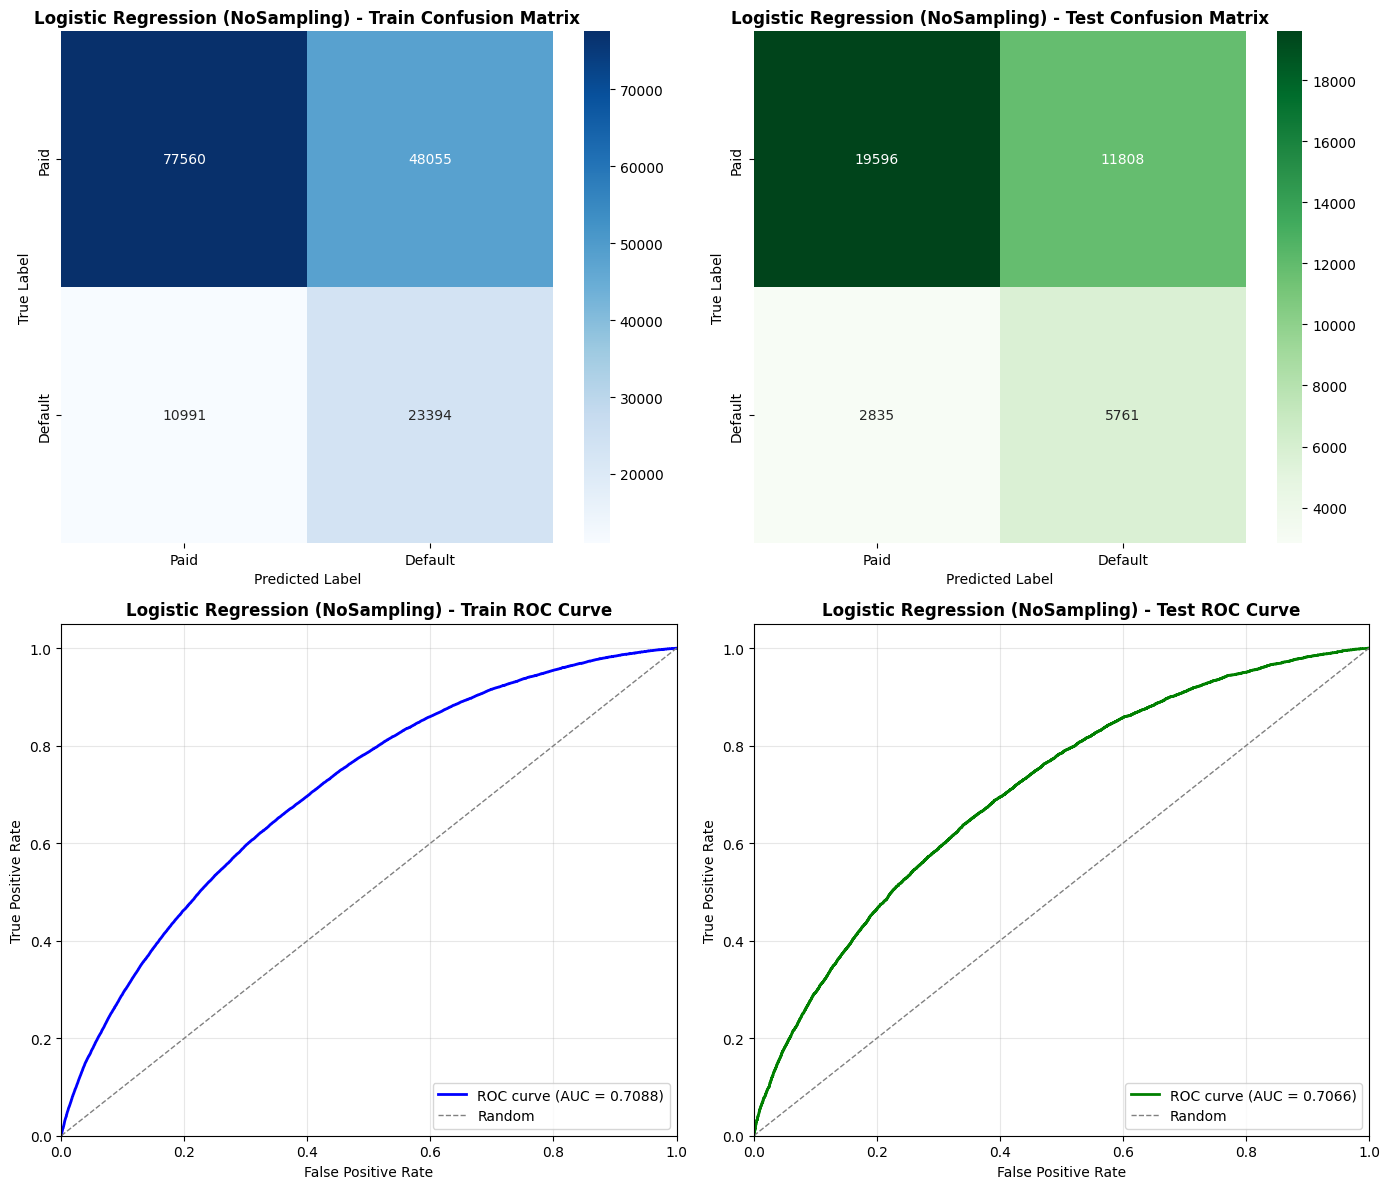


🔍 EVALUATING: Random Forest (NoSampling)

📊 PERFORMANCE METRICS:
Metric               Train        Test        
--------------------------------------------
Accuracy             0.7568       0.6858      
Precision            0.4597       0.3566      
Recall               0.7509       0.5745      
F1-Score             0.5703       0.4400      
AUC-ROC              0.8485       0.7096      


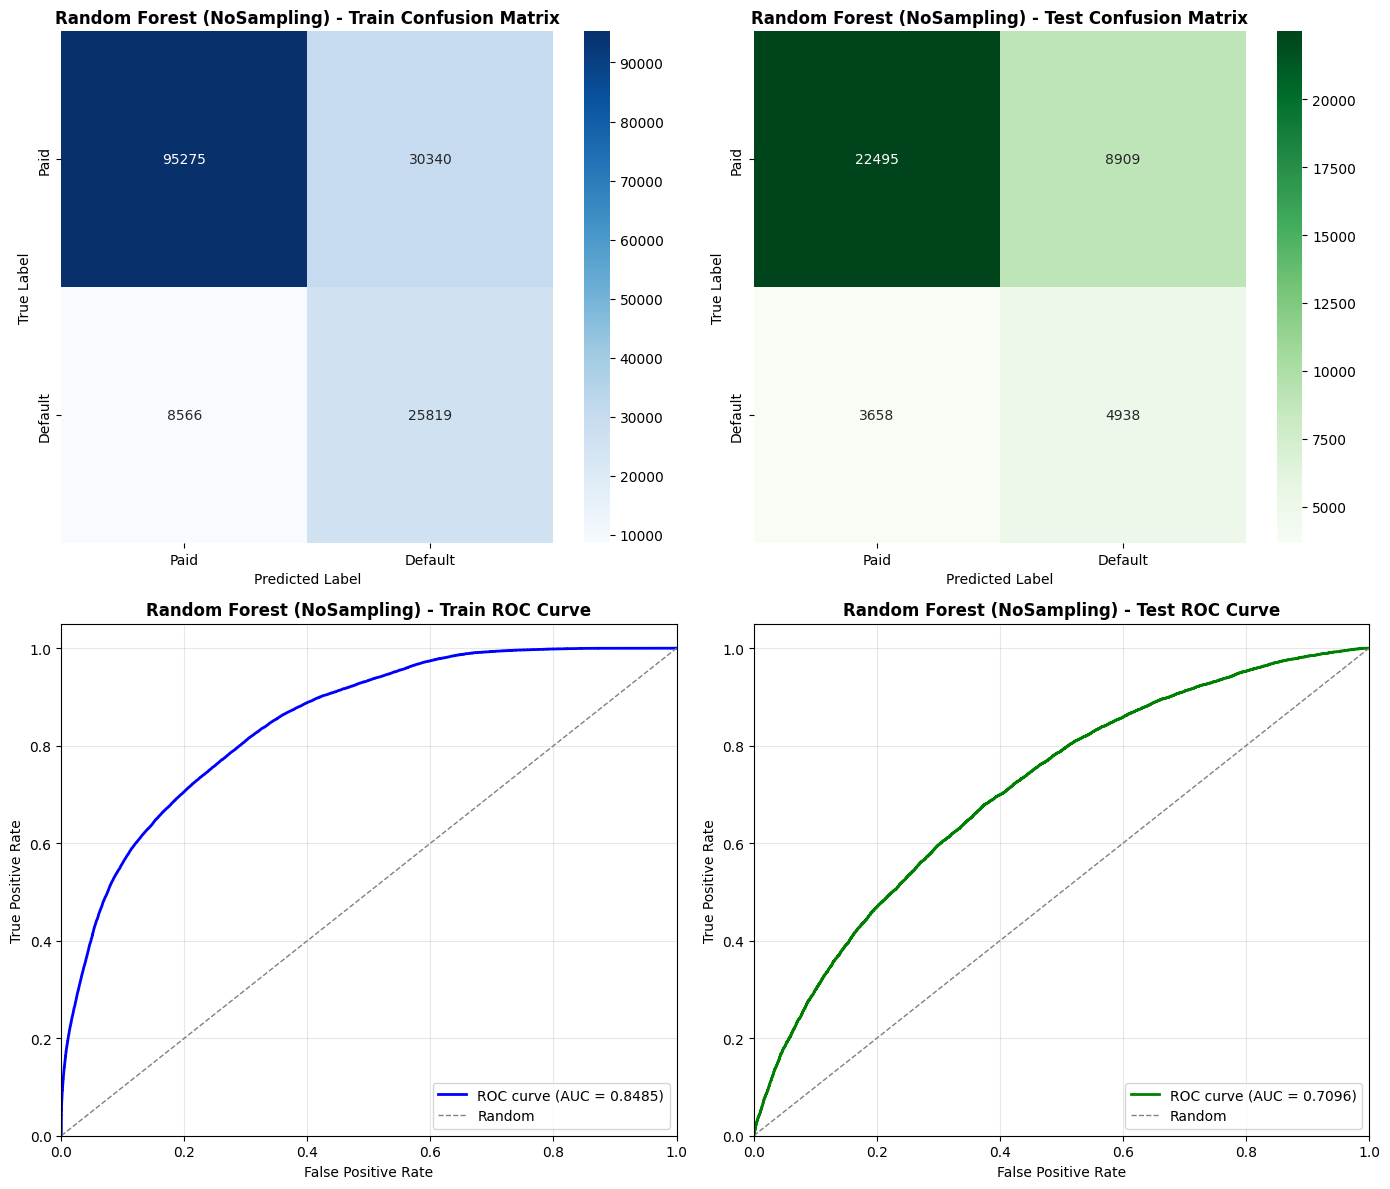


🔍 EVALUATING: XGBoost (NoSampling)

📊 PERFORMANCE METRICS:
Metric               Train        Test        
--------------------------------------------
Accuracy             0.6655       0.6492      
Precision            0.3603       0.3389      
Recall               0.7172       0.6652      
F1-Score             0.4796       0.4491      
AUC-ROC              0.7556       0.7177      


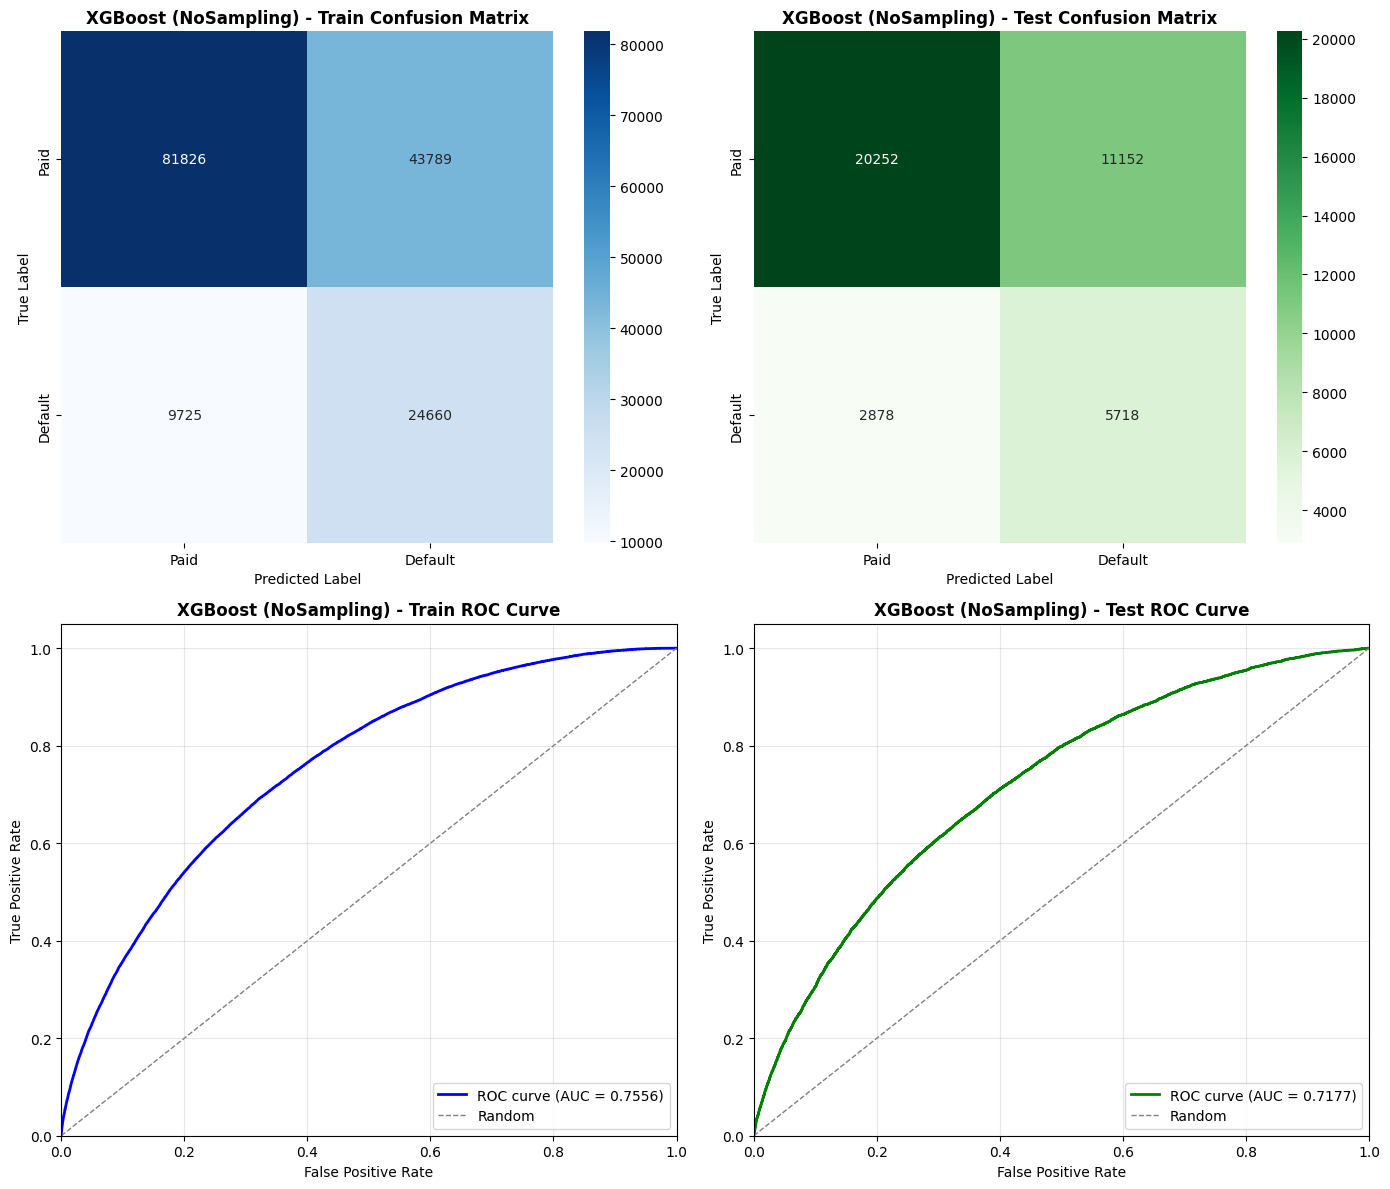


  Training ANN (this may take a while)...
Epoch 1/30
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5945 - loss: 0.6611 - val_accuracy: 0.6353 - val_loss: 0.6022
Epoch 2/30
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6179 - loss: 0.6349 - val_accuracy: 0.6425 - val_loss: 0.6078
Epoch 3/30
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6252 - loss: 0.6297 - val_accuracy: 0.6312 - val_loss: 0.6207
Epoch 4/30
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6250 - loss: 0.6278 - val_accuracy: 0.6391 - val_loss: 0.6140
Epoch 5/30
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6269 - loss: 0.6264 - val_accuracy: 0.6415 - val_loss: 0.6177
Epoch 6/30
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6315 - loss: 0.6245 - val_accuracy: 0.6445 - val_loss: 0.6225
Epoch 7/30
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6344 - loss: 0.6245 - val_accuracy: 0.6265 - val_loss: 0.6338

🔍 EVALUATING: ANN (NoSampling)
5000/5000 ━━━━━━━━━━━━━━━━━━━

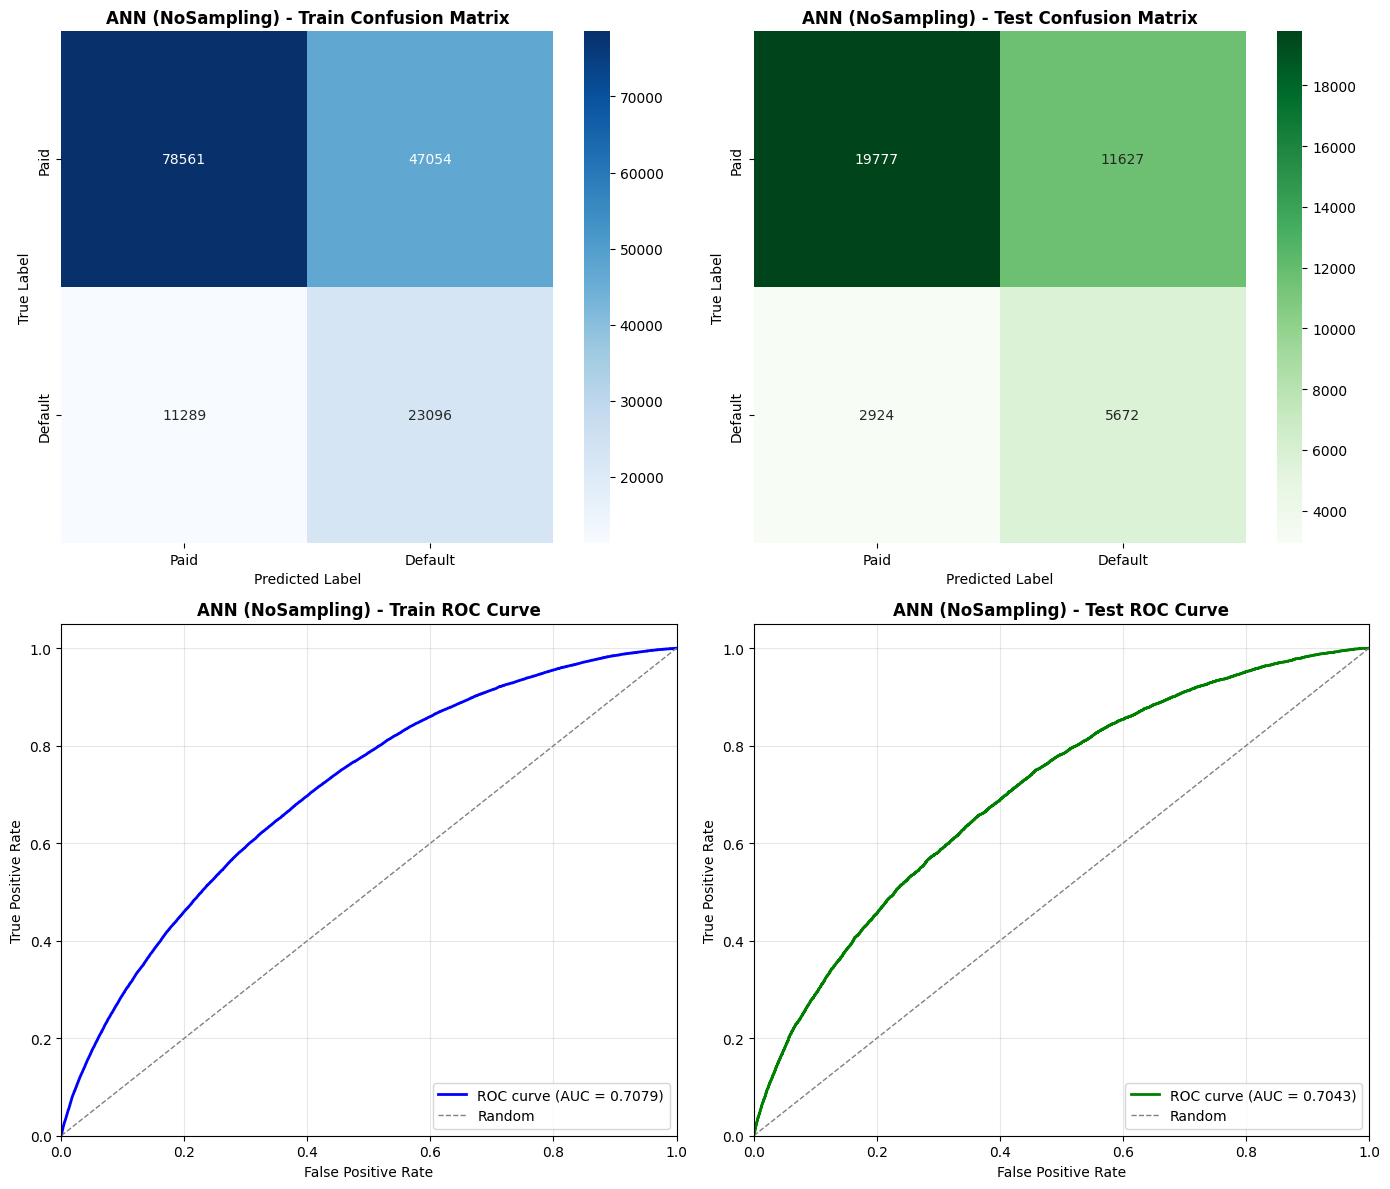


Ensemble (sampler=NoSampling) on test set -> AUC: 0.7148 F1: 0.4475 Recall: 0.6419 Accuracy: 0.6593

 SAMPLER: SMOTE
  Applying sampler: SMOTE
  After sampling -> X: (163299, 39), y: [125615  37684]

🔍 EVALUATING: Logistic Regression (SMOTE)

📊 PERFORMANCE METRICS:
Metric               Train        Test        
--------------------------------------------
Accuracy             0.6315       0.6338      
Precision            0.3477       0.3280      
Recall               0.6817       0.6716      
F1-Score             0.4605       0.4408      
AUC-ROC              0.7088       0.7066      


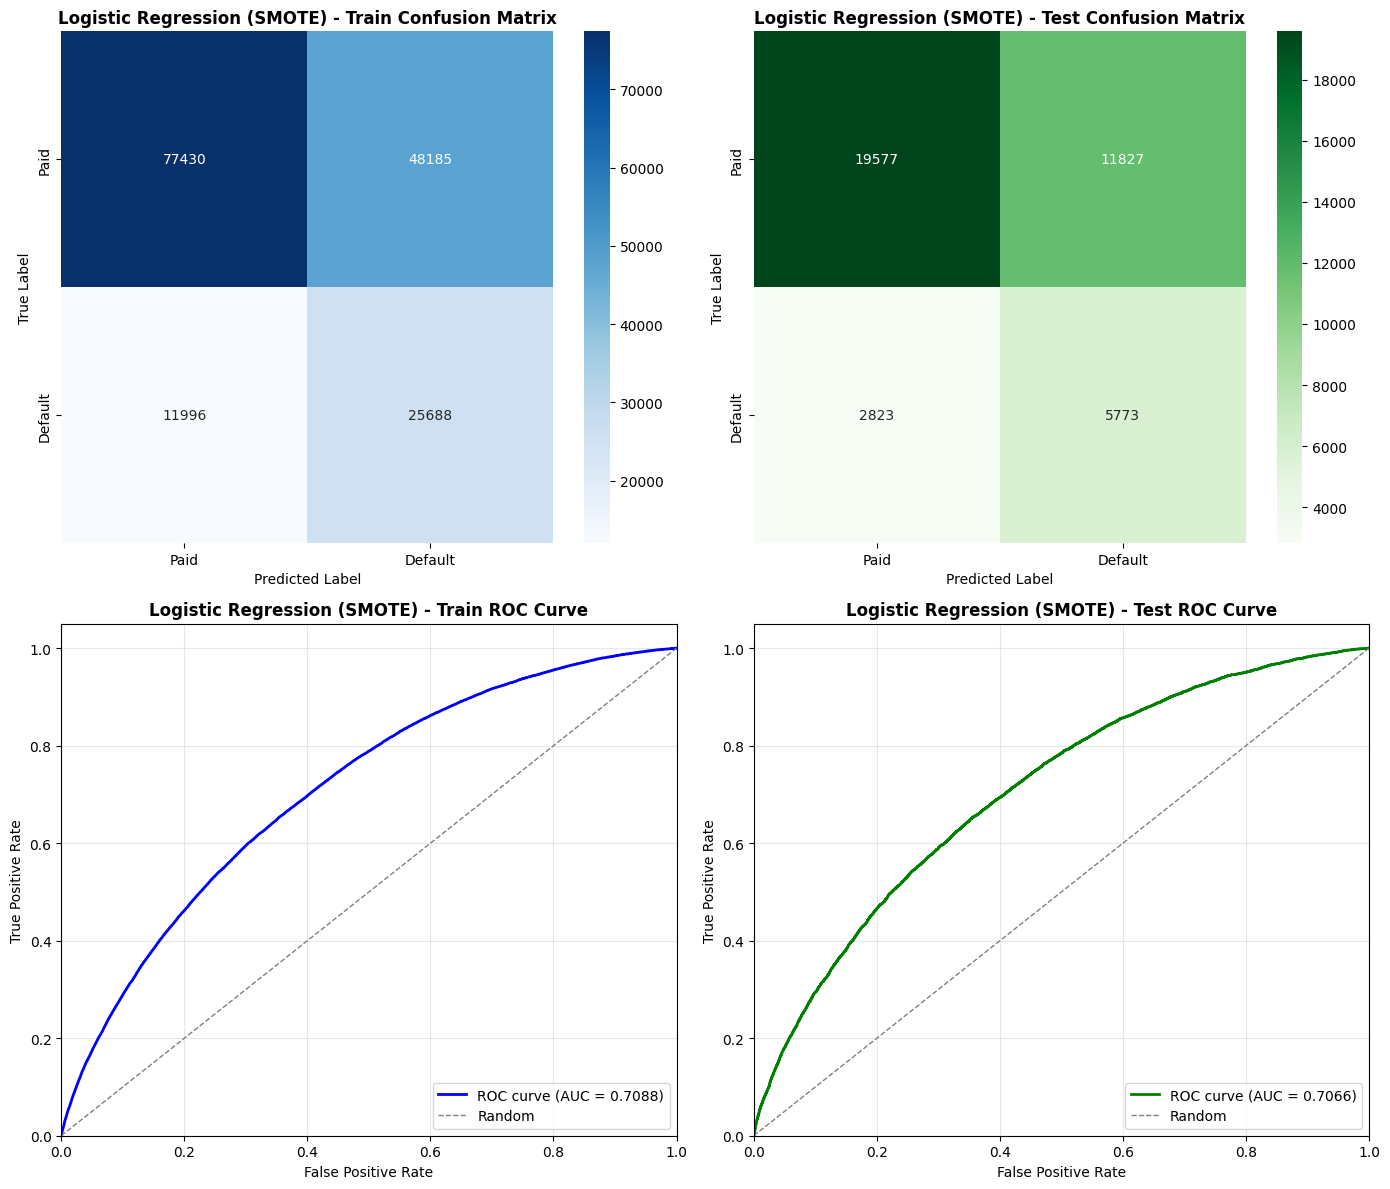


🔍 EVALUATING: Random Forest (SMOTE)

📊 PERFORMANCE METRICS:
Metric               Train        Test        
--------------------------------------------
Accuracy             0.7575       0.6869      
Precision            0.4838       0.3580      
Recall               0.7590       0.5761      
F1-Score             0.5909       0.4416      
AUC-ROC              0.8522       0.7102      


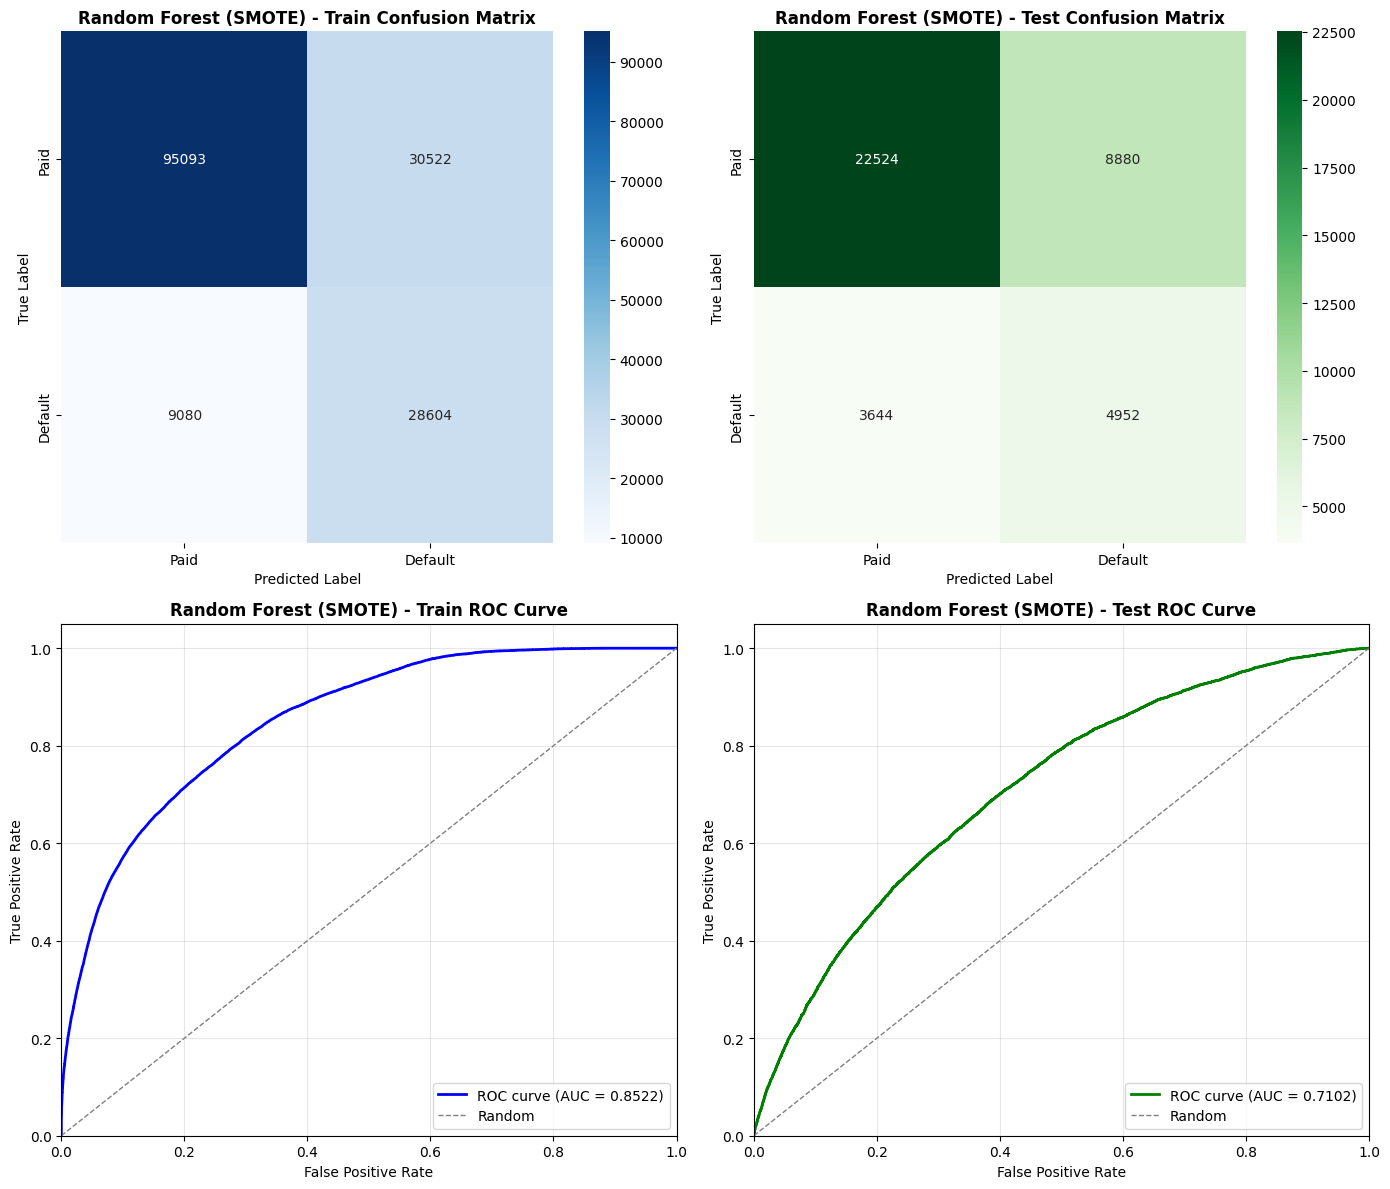


🔍 EVALUATING: XGBoost (SMOTE)

📊 PERFORMANCE METRICS:
Metric               Train        Test        
--------------------------------------------
Accuracy             0.6753       0.6579      
Precision            0.3891       0.3441      
Recall               0.7145       0.6534      
F1-Score             0.5039       0.4508      
AUC-ROC              0.7637       0.7176      


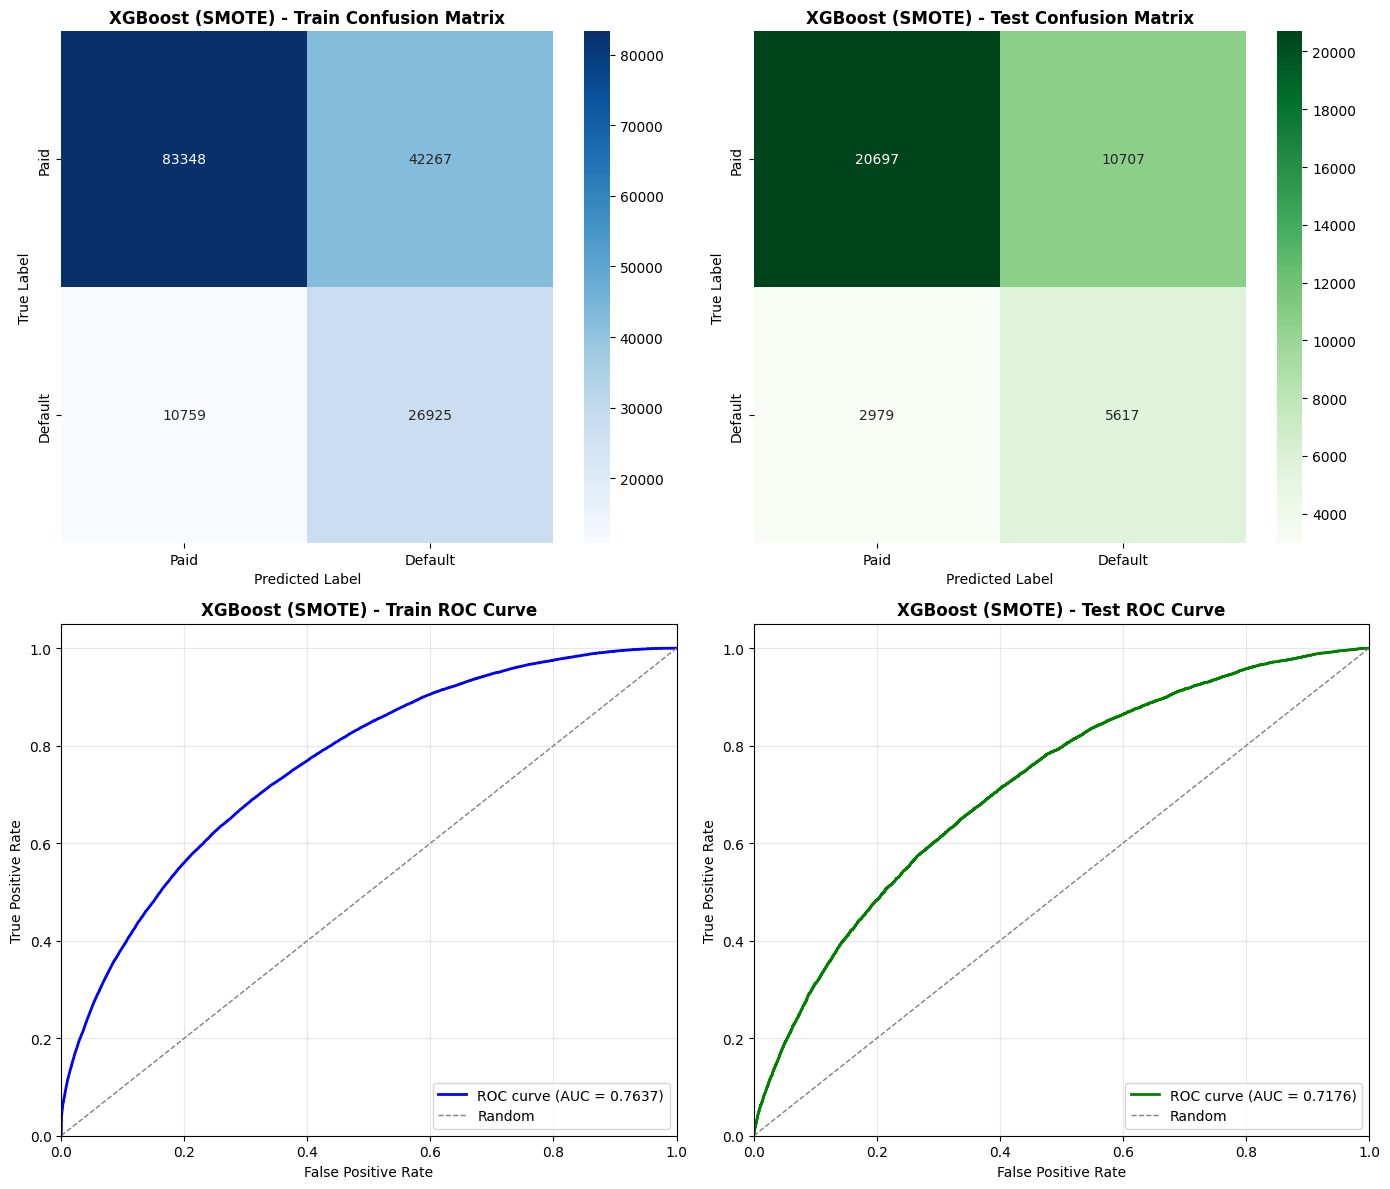


  Training ANN (this may take a while)...
Epoch 1/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6012 - loss: 0.6594 - val_accuracy: 0.6245 - val_loss: 0.6201
Epoch 2/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6146 - loss: 0.6337 - val_accuracy: 0.6203 - val_loss: 0.6161
Epoch 3/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6181 - loss: 0.6297 - val_accuracy: 0.6118 - val_loss: 0.6321
Epoch 4/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6187 - loss: 0.6266 - val_accuracy: 0.6108 - val_loss: 0.6204
Epoch 5/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6186 - loss: 0.6258 - val_accuracy: 0.6154 - val_loss: 0.6218
Epoch 6/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6237 - loss: 0.6247 - val_accuracy: 0.6149 - val_loss: 0.6264
Epoch 7/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6281 - loss: 0.6229 - val_accuracy: 0.6216 - val_loss: 0.6221
Epoch 8/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accurac

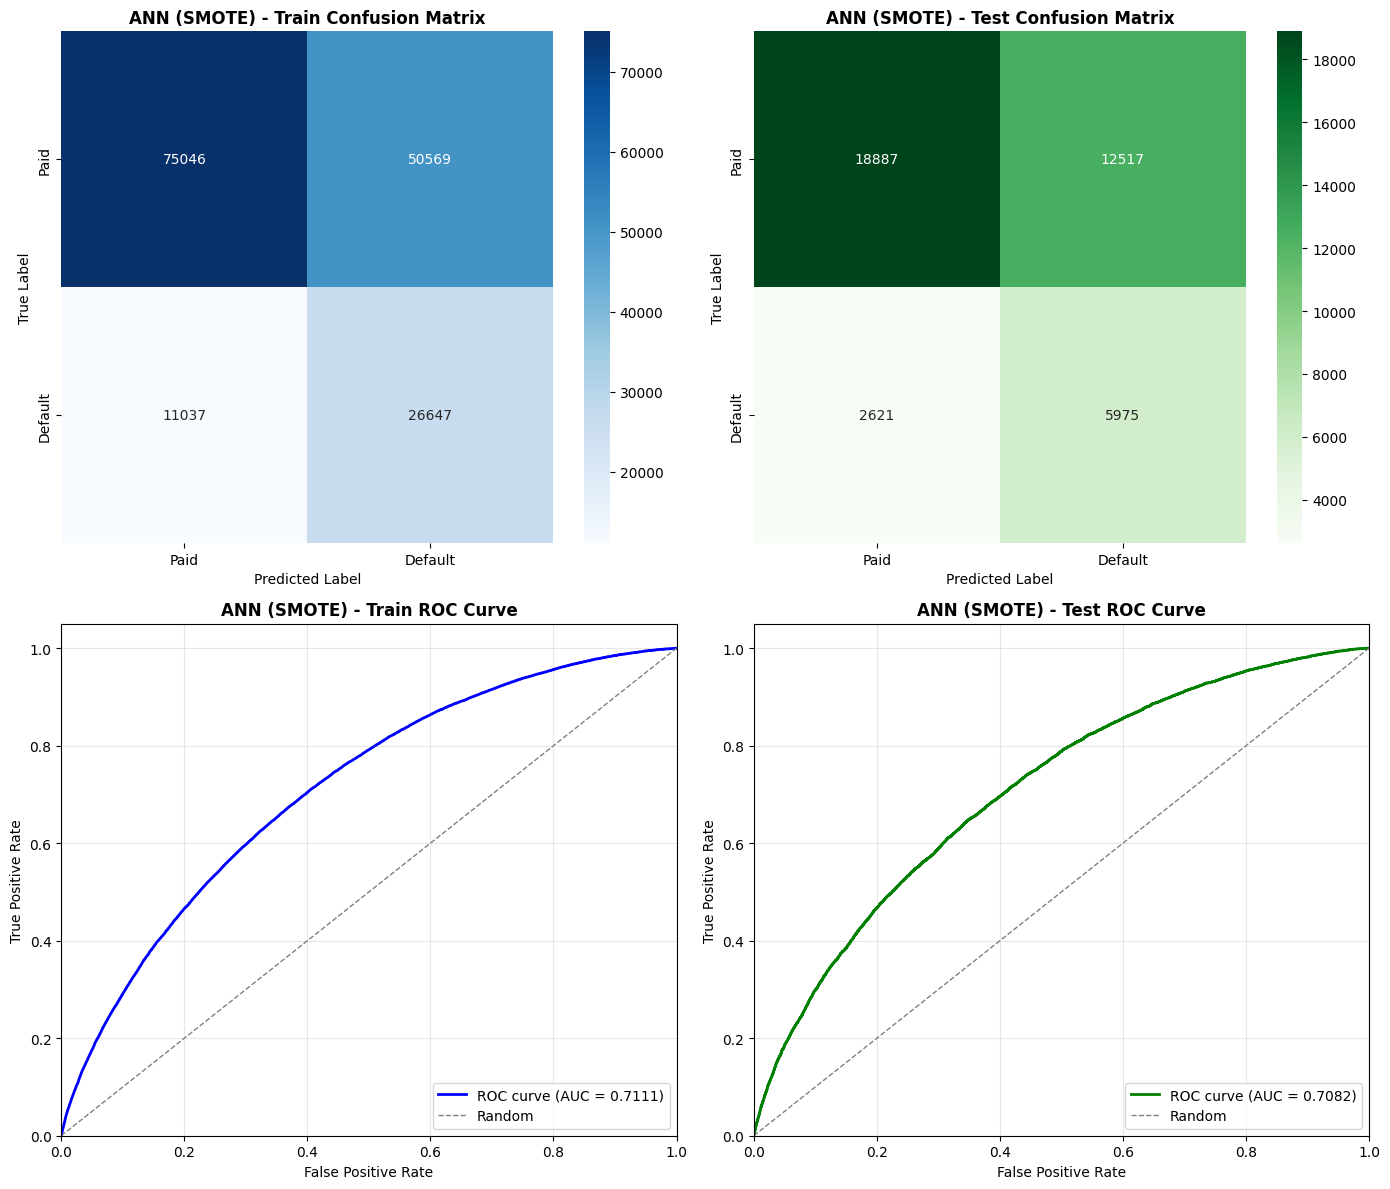


Ensemble (sampler=SMOTE) on test set -> AUC: 0.7152 F1: 0.4484 Recall: 0.6423 Accuracy: 0.6604

 SAMPLER: ENN
  Applying sampler: ENN
  After sampling -> X: (105061, 39), y: [70676 34385]

🔍 EVALUATING: Logistic Regression (ENN)

📊 PERFORMANCE METRICS:
Metric               Train        Test        
--------------------------------------------
Accuracy             0.7170       0.6087      
Precision            0.5517       0.3173      
Recall               0.7227       0.7127      
F1-Score             0.6257       0.4391      
AUC-ROC              0.7960       0.7067      


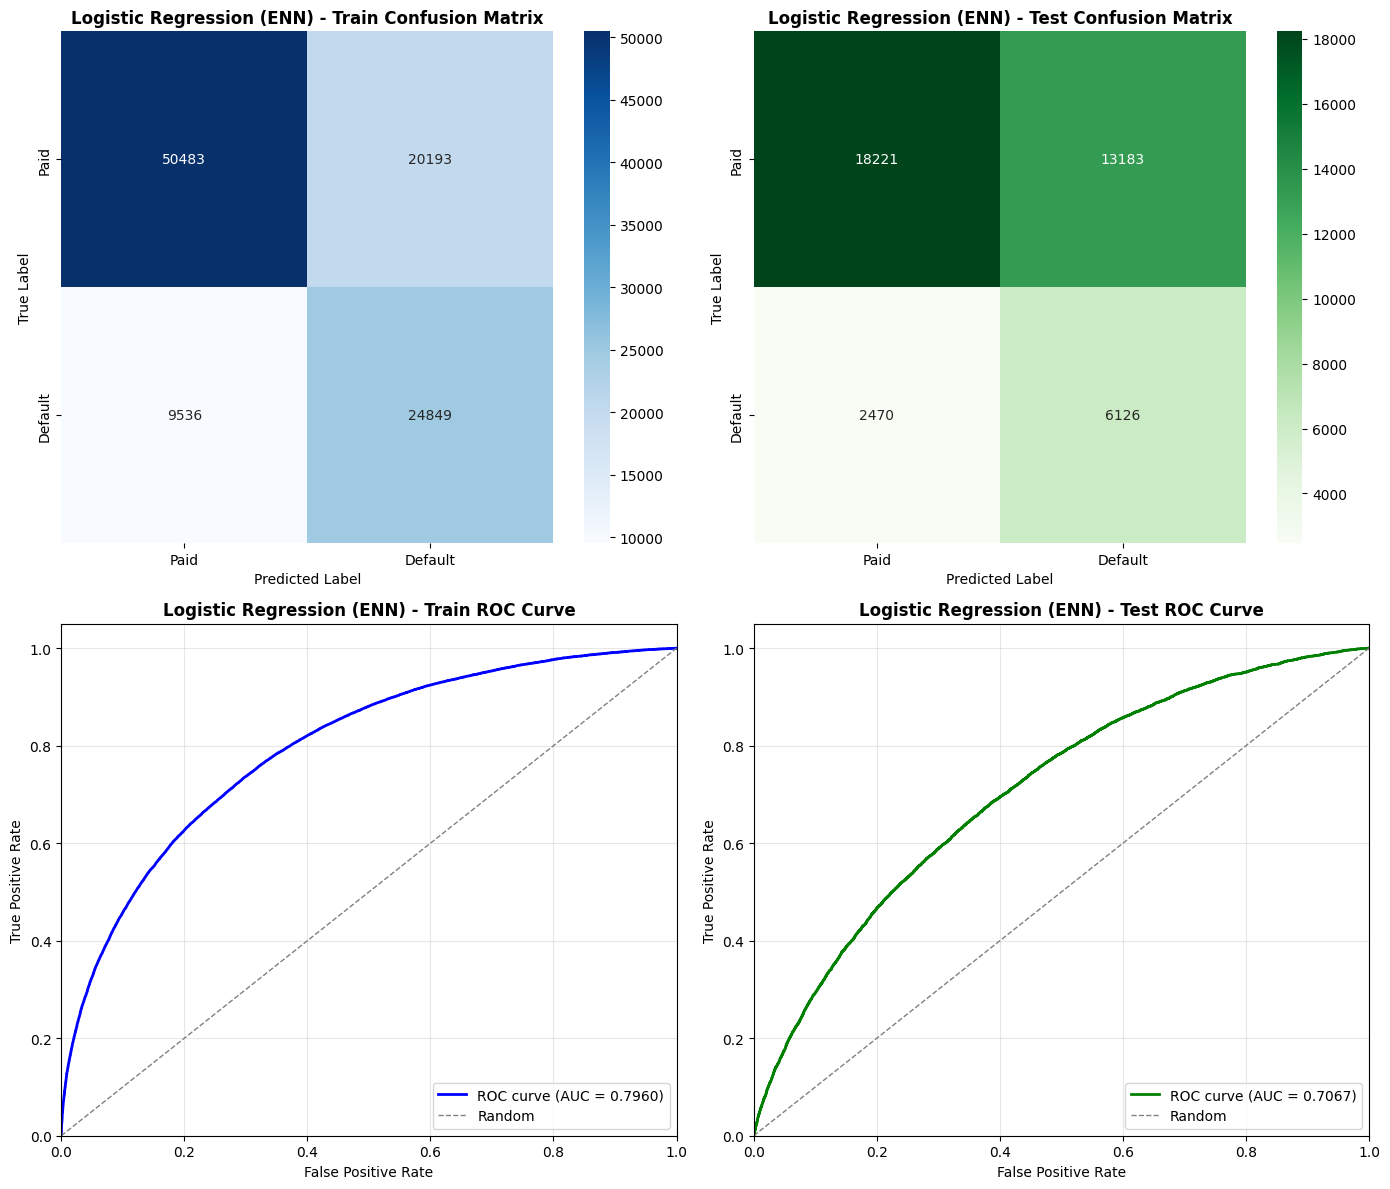


🔍 EVALUATING: Random Forest (ENN)

📊 PERFORMANCE METRICS:
Metric               Train        Test        
--------------------------------------------
Accuracy             0.8080       0.6389      
Precision            0.6782       0.3315      
Recall               0.7864       0.6689      
F1-Score             0.7283       0.4433      
AUC-ROC              0.8971       0.7097      


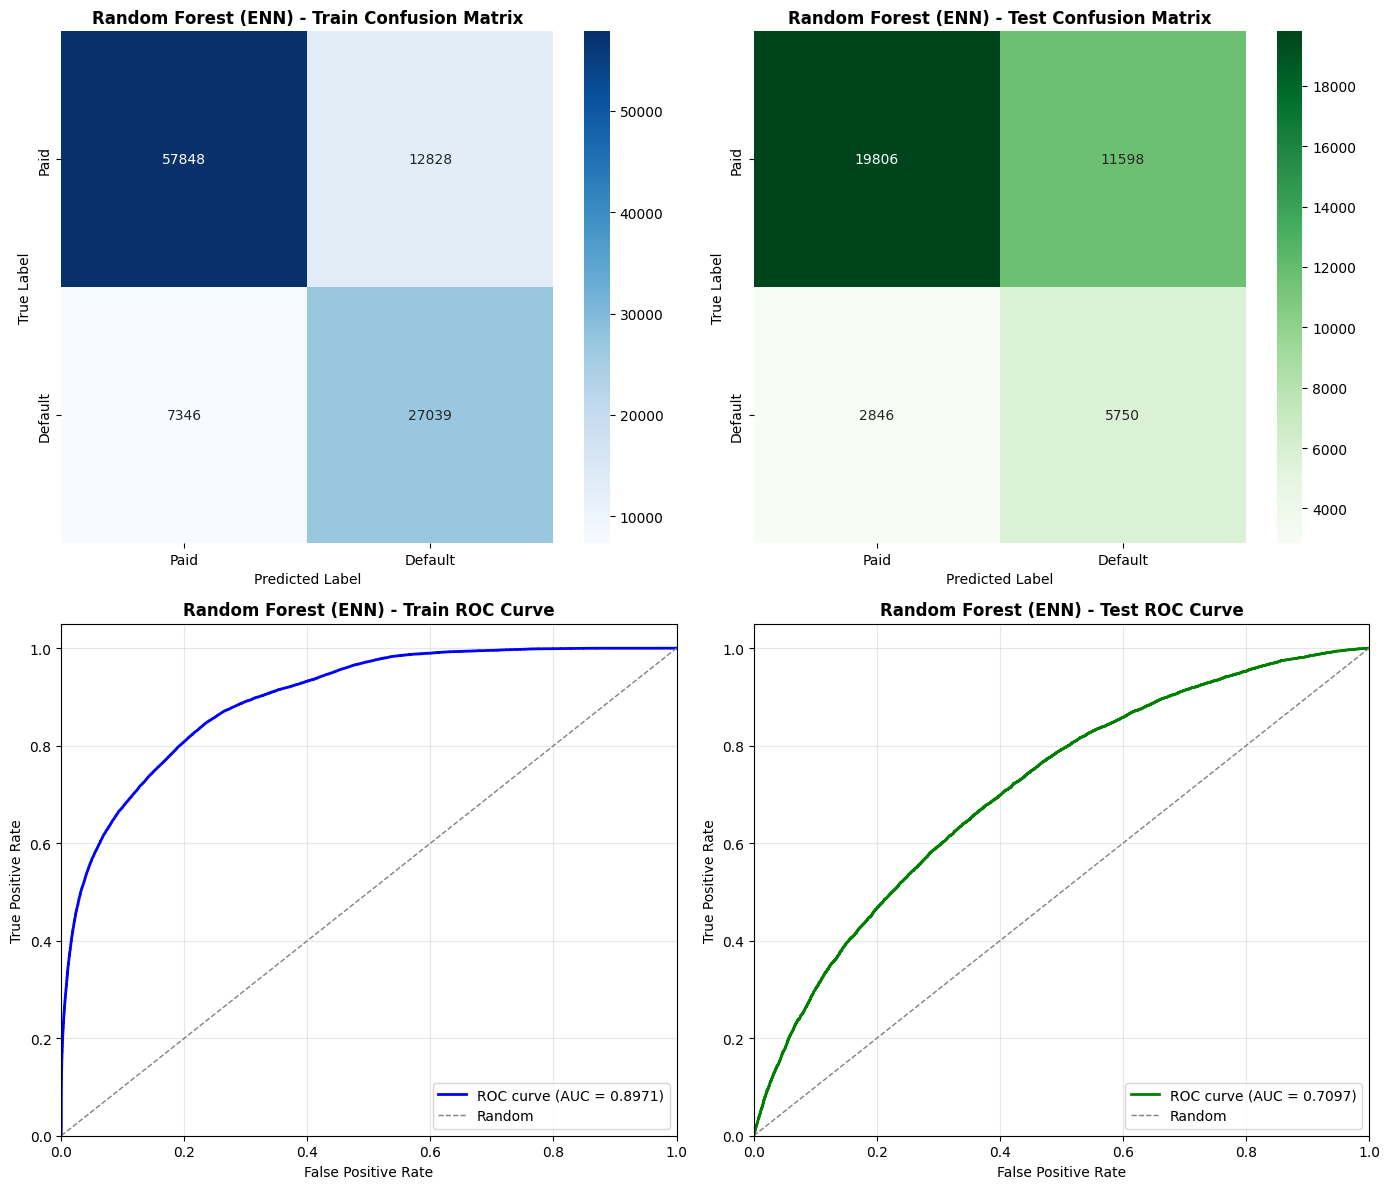


🔍 EVALUATING: XGBoost (ENN)

📊 PERFORMANCE METRICS:
Metric               Train        Test        
--------------------------------------------
Accuracy             0.7490       0.6233      
Precision            0.5923       0.3268      
Recall               0.7483       0.7099      
F1-Score             0.6612       0.4475      
AUC-ROC              0.8334       0.7161      


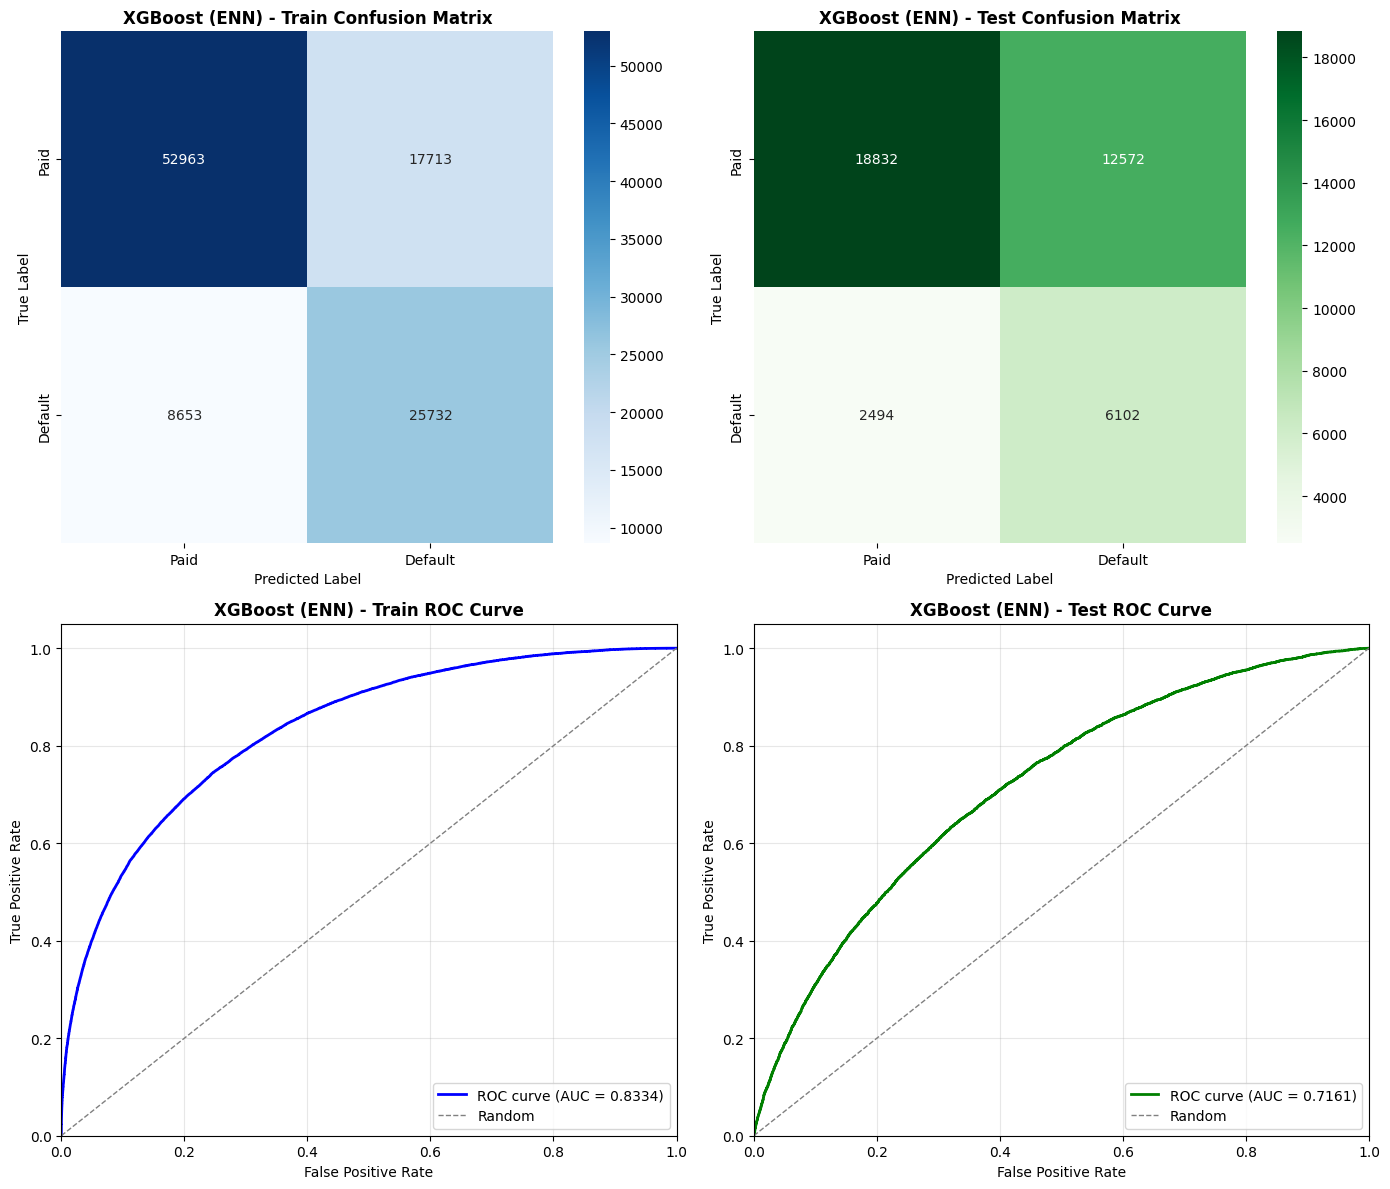


  Training ANN (this may take a while)...
Epoch 1/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6590 - loss: 0.6149 - val_accuracy: 0.7174 - val_loss: 0.5430
Epoch 2/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7047 - loss: 0.5679 - val_accuracy: 0.7238 - val_loss: 0.5365
Epoch 3/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7141 - loss: 0.5615 - val_accuracy: 0.7312 - val_loss: 0.5411
Epoch 4/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7167 - loss: 0.5561 - val_accuracy: 0.7299 - val_loss: 0.5342
Epoch 5/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7210 - loss: 0.5535 - val_accuracy: 0.7294 - val_loss: 0.5359
Epoch 6/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7216 - loss: 0.5498 - val_accuracy: 0.7299 - val_loss: 0.5322
Epoch 7/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7229 - loss: 0.5489 - val_accuracy: 0.7303 - val_loss: 0.5352
Epoch 8/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accurac

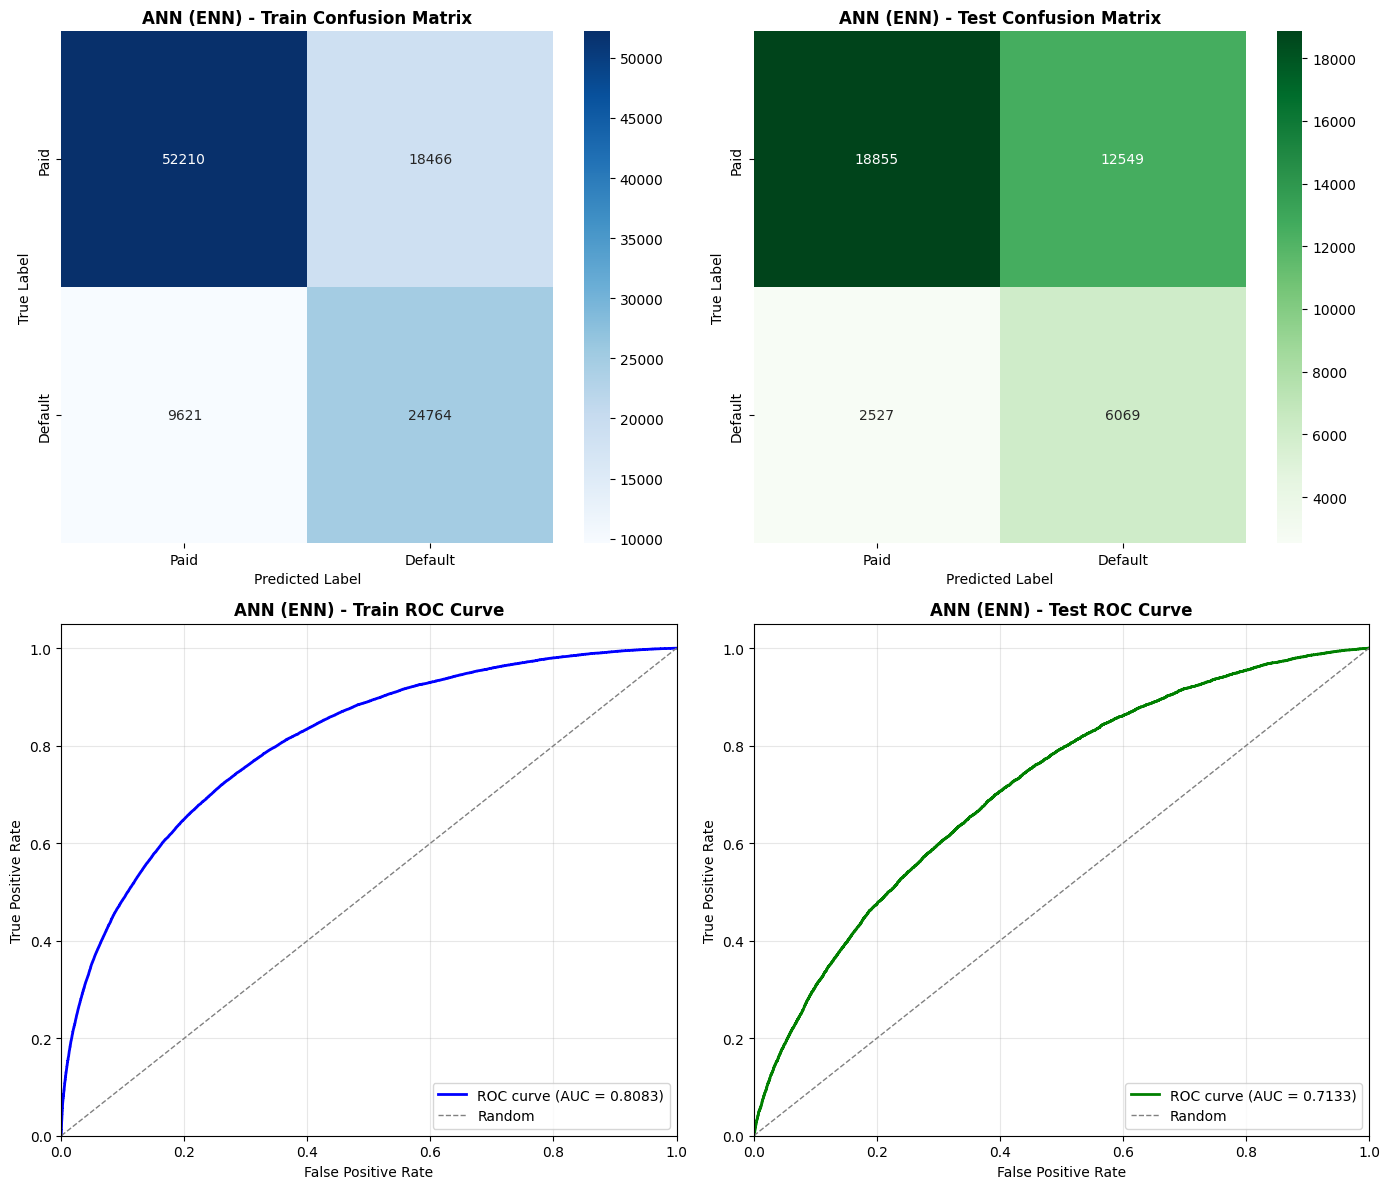


Ensemble (sampler=ENN) on test set -> AUC: 0.7142 F1: 0.4440 Recall: 0.6966 Accuracy: 0.6251

 SAMPLER: SMOTEENN
  Applying sampler: SMOTEENN
  After sampling -> X: (107215, 39), y: [69531 37684]

🔍 EVALUATING: Logistic Regression (SMOTEENN)

📊 PERFORMANCE METRICS:
Metric               Train        Test        
--------------------------------------------
Accuracy             0.7190       0.6075      
Precision            0.5803       0.3168      
Recall               0.7246       0.7143      
F1-Score             0.6445       0.4389      
AUC-ROC              0.7984       0.7068      


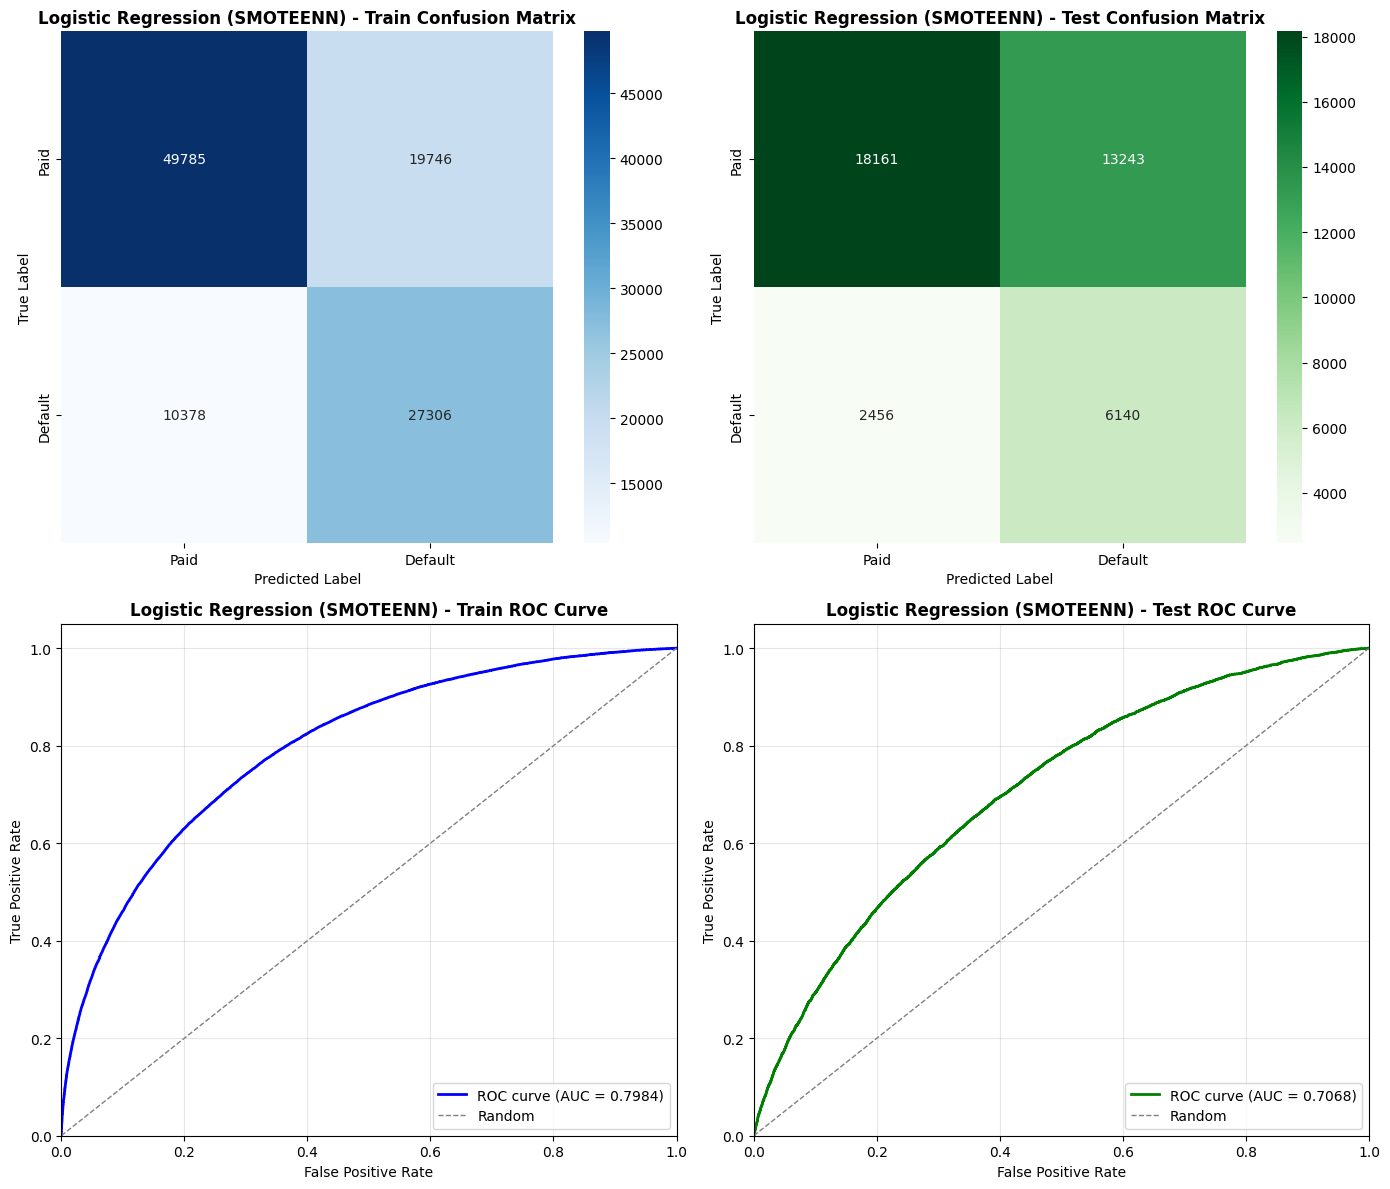


🔍 EVALUATING: Random Forest (SMOTEENN)

📊 PERFORMANCE METRICS:
Metric               Train        Test        
--------------------------------------------
Accuracy             0.8107       0.6359      
Precision            0.7041       0.3299      
Recall               0.7960       0.6732      
F1-Score             0.7472       0.4428      
AUC-ROC              0.9011       0.7096      


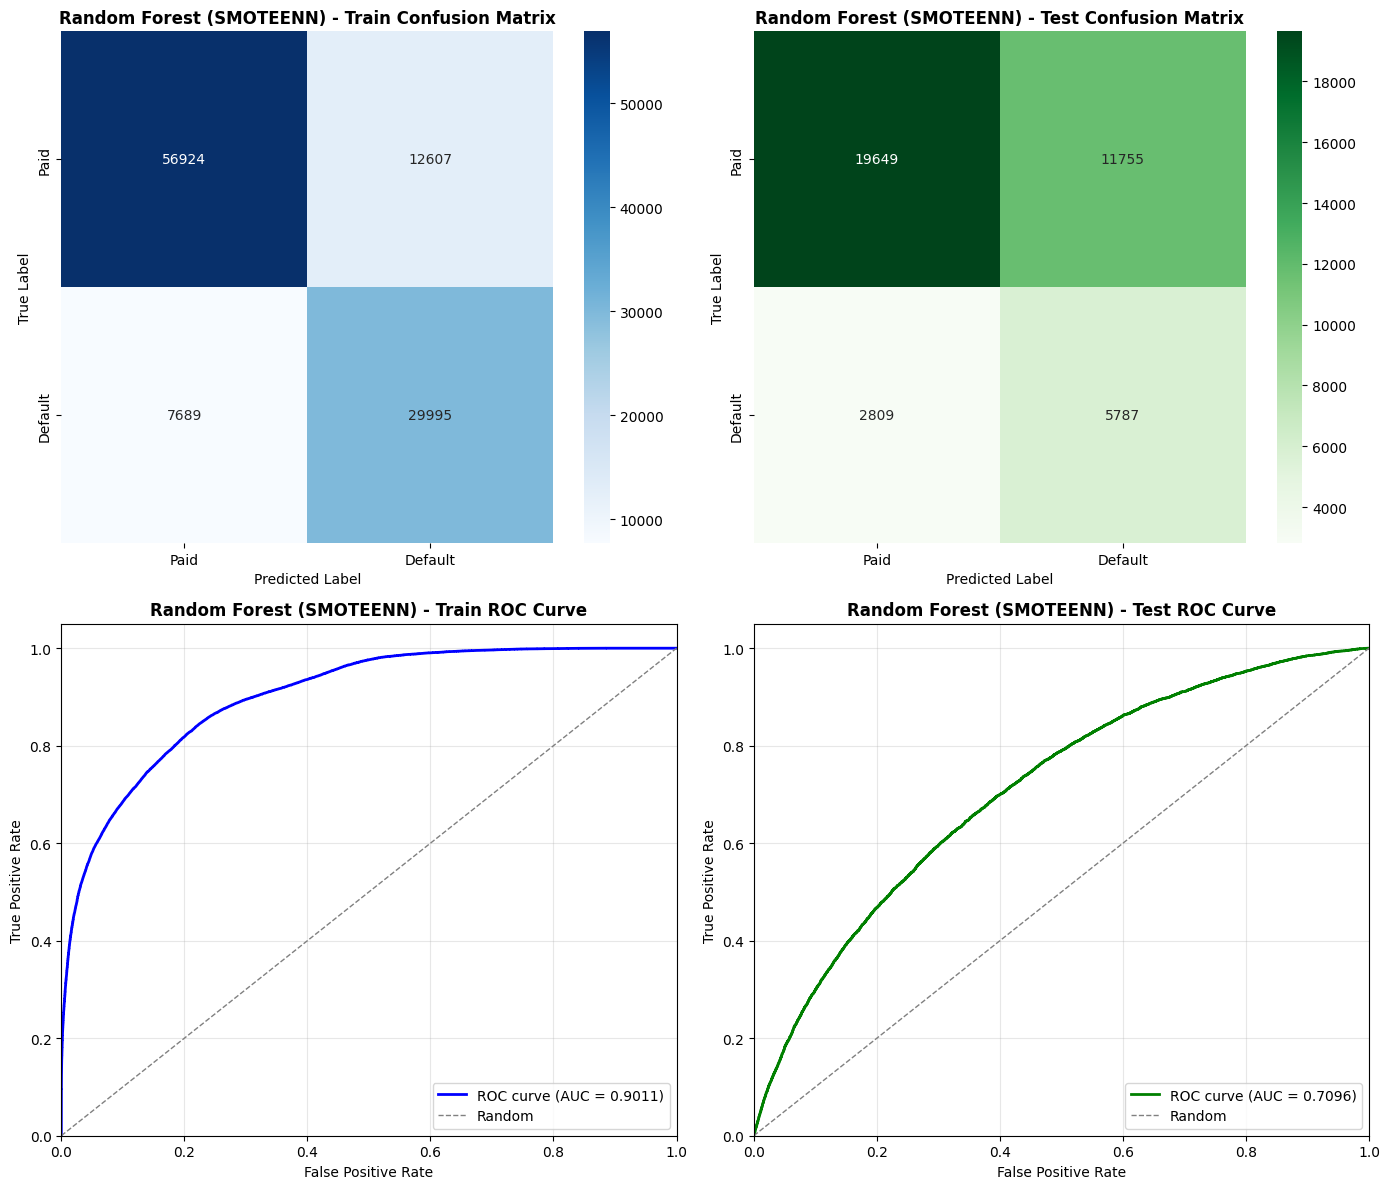


🔍 EVALUATING: XGBoost (SMOTEENN)

📊 PERFORMANCE METRICS:
Metric               Train        Test        
--------------------------------------------
Accuracy             0.7556       0.6288      
Precision            0.6271       0.3291      
Recall               0.7512       0.7004      
F1-Score             0.6836       0.4478      
AUC-ROC              0.8400       0.7160      


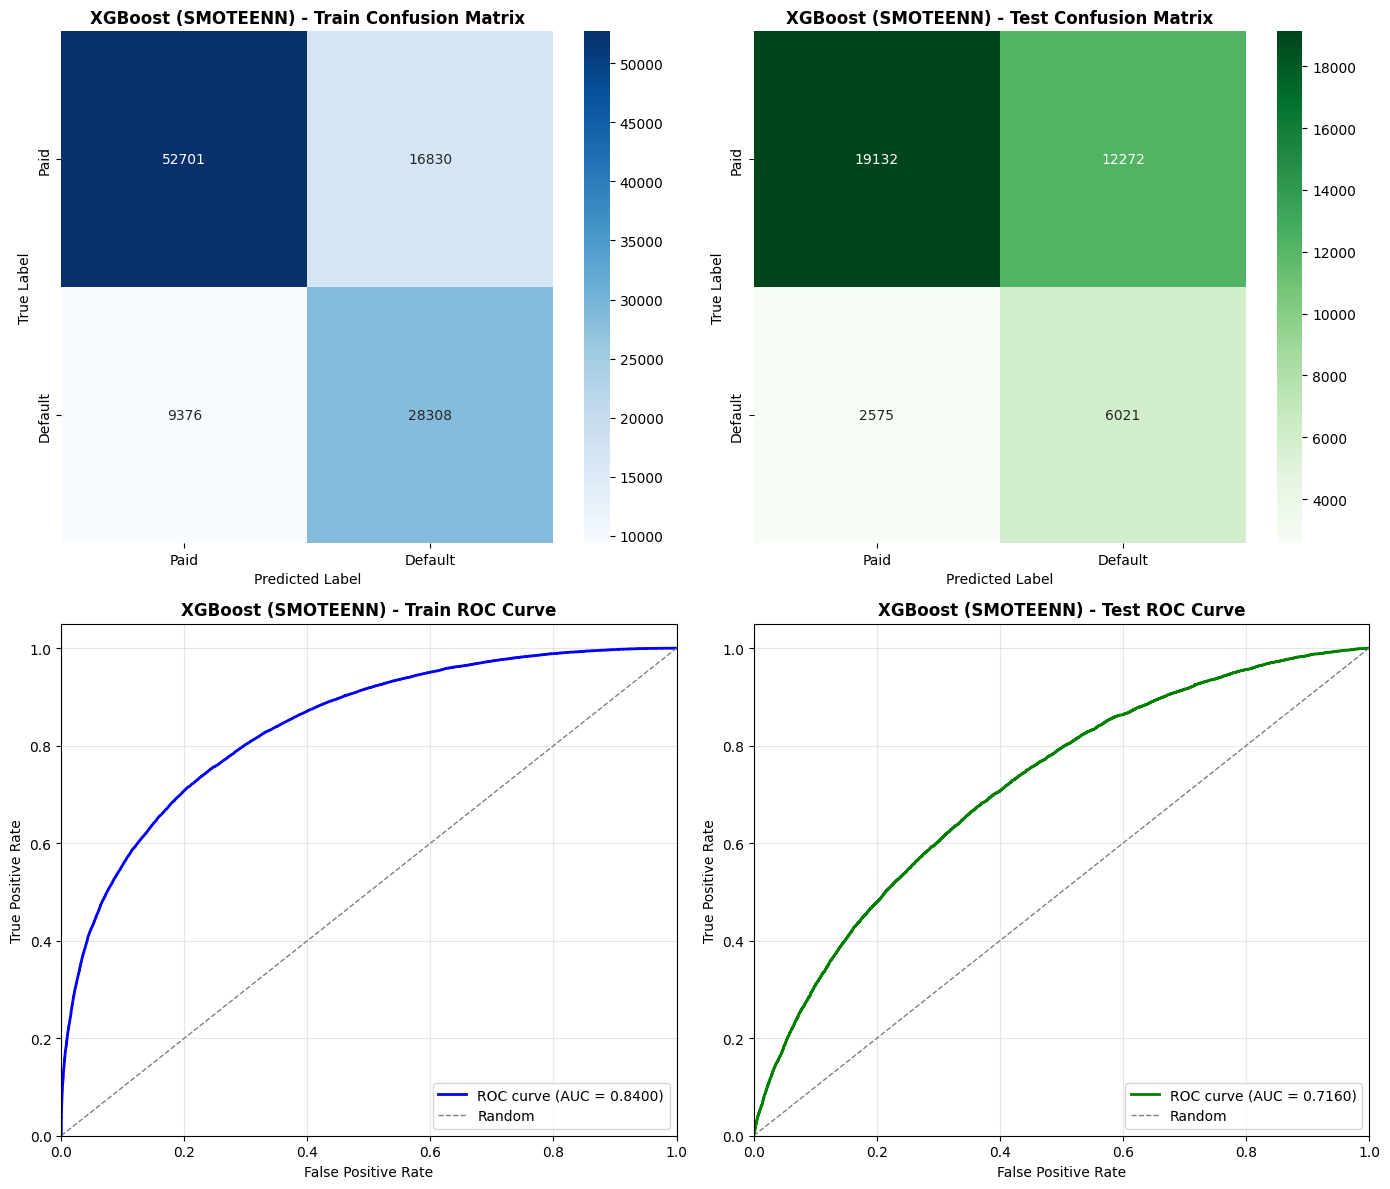


  Training ANN (this may take a while)...
Epoch 1/30
356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6677 - loss: 0.6098 - val_accuracy: 0.7381 - val_loss: 0.5251
Epoch 2/30
356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7129 - loss: 0.5598 - val_accuracy: 0.7292 - val_loss: 0.5314
Epoch 3/30
356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7166 - loss: 0.5534 - val_accuracy: 0.7288 - val_loss: 0.5262
Epoch 4/30
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7180 - loss: 0.5509 - val_accuracy: 0.7301 - val_loss: 0.5259
Epoch 5/30
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7197 - loss: 0.5494 - val_accuracy: 0.7340 - val_loss: 0.5265
Epoch 6/30
356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7217 - loss: 0.5473 - val_accuracy: 0.7272 - val_loss: 0.5328
Epoch 7/30
356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7221 - loss: 0.5454 - val_accuracy: 0.7303 - val_loss: 0.5311

🔍 EVALUATING: ANN (SMOTEENN)
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 

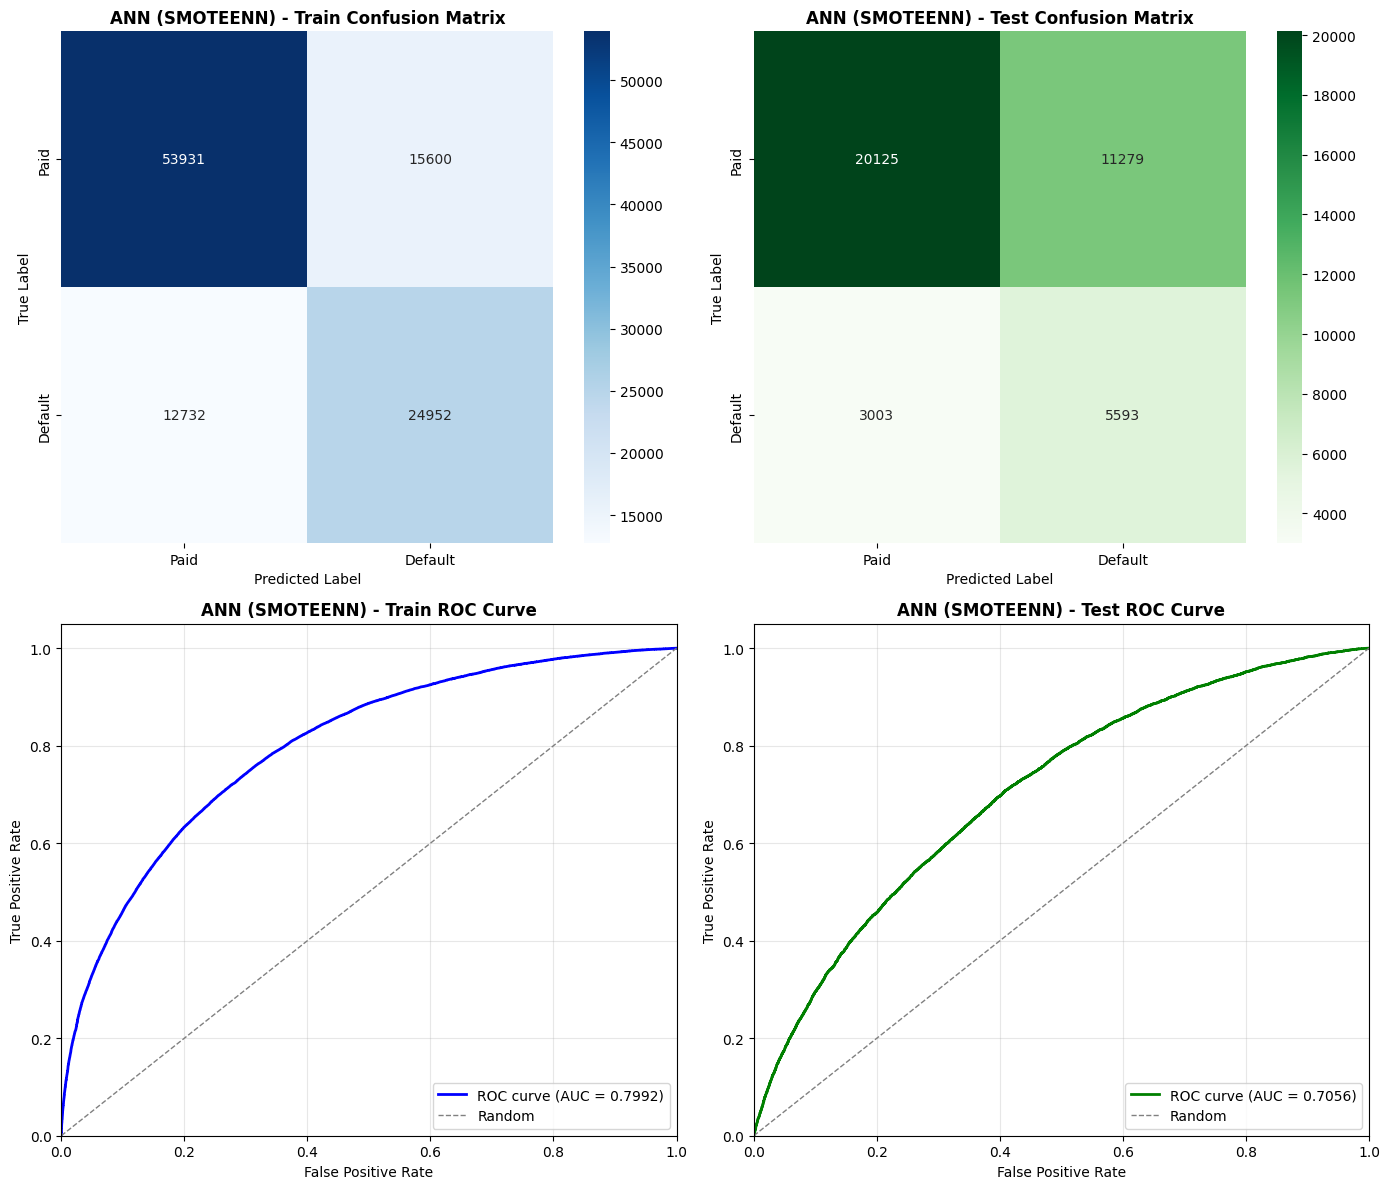


Ensemble (sampler=SMOTEENN) on test set -> AUC: 0.7130 F1: 0.4438 Recall: 0.6883 Accuracy: 0.6293


=== SUMMARY (all samplers & models) ===


test_auc                             test_f1             \
sampler                  ENN NoSampling   SMOTE SMOTEENN     ENN NoSampling   
model                                                                         
ANN                   0.7133     0.7043  0.7082   0.7056  0.4460     0.4381   
Ensemble              0.7142     0.7148  0.7152   0.7130  0.4440     0.4475   
Logistic Regression   0.7067     0.7066  0.7066   0.7068  0.4391     0.4404   
Random Forest         0.7097     0.7096  0.7102   0.7096  0.4433     0.4400   
XGBoost               0.7161     0.7177  0.7176   0.7160  0.4475     0.4491   

                                     test_recall                              \
sampler               SMOTE SMOTEENN         ENN NoSampling   SMOTE SMOTEENN   
model                                                                          
ANN                  0.4412   0.4392      0.7060     0.6598  0.6951   0.6507   
Ensemble             0.4484   0.4438      0.6966     0.6419  0.6423   0.6883   
Logistic Regression  0.4408   0.4389      0.7127     0.6702  0.6716   0.7143   
Random Forest        0.4416   0.4428      0.6689     0.5745  0.5761   0.6732   
XGBoost              0.4508   0.4478      0.7099     0.6652  0.6534   0.7004   

                    test_accuracy                              
sampler                       ENN NoSampling   SMOTE SMOTEENN  
model                                                          
ANN                        0.6231     0.6362  0.6216   0.6430  
Ensemble                   0.6251     0.6593  0.6604   0.6293  
Logistic Regression        0.6087     0.6339  0.6338   0.6075  
Random Forest              0.6389     0.6858  0.6869   0.6359  
XGBoost                    0.6234     0.6492  0.6579   0.6288


=== Percent change vs NoSampling (NoSampling = GNN baseline) ===


pct_auc                pct_f1                pct_recall  \
sampler                 ENN SMOTE SMOTEENN    ENN SMOTE SMOTEENN        ENN   
model                                                                         
ANN                    1.28  0.55     0.19   1.81  0.70     0.26       7.00   
Ensemble              -0.08  0.06    -0.25  -0.77  0.21    -0.81       8.52   
Logistic Regression    0.02  0.01     0.03  -0.29  0.09    -0.33       6.34   
Random Forest          0.02  0.09     0.00   0.73  0.35     0.63      16.44   
XGBoost               -0.22 -0.01    -0.22  -0.34  0.39    -0.27       6.72   

                                   pct_accuracy                 
sampler             SMOTE SMOTEENN          ENN SMOTE SMOTEENN  
model                                                           
ANN                  5.34    -1.39        -2.06 -2.31     1.06  
Ensemble             0.05     7.23        -5.19  0.17    -4.55  
Logistic Regression  0.21     6.58        -3.98 -0.03    -4.16  
Random Forest        0.28    17.19        -6.84  0.16    -7.28  
XGBoost             -1.77     5.30        -3.99  1.32    -3.15


Saved results to 'gnn_sampling_results.csv' and 'gnn_sampling_percent_change.csv'


In [261]:
# ------------------------------
# Scenario 2: sampling experiments
# ------------------------------
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
from sklearn.utils import shuffle
import time
import warnings
warnings.filterwarnings("ignore")

# Ensure these are defined in your notebook already:
# X_train_with_gnn_scaled, X_test_with_gnn_scaled, y_train, y_test
# lr_gnn_metrics, rf_gnn_metrics, xgb_gnn_metrics, ann_gnn_metrics, ensemble_gnn_metrics
# evaluate_model (function)

# Samplers to run
sampler_map = {
    "NoSampling": None,
    "SMOTE": SMOTE(random_state=42, sampling_strategy=0.3),        # increase minority to 20% of majority
    "ENN": EditedNearestNeighbours(),
    "SMOTEENN": SMOTEENN(smote=SMOTE(random_state=42, sampling_strategy=0.3), enn=EditedNearestNeighbours())
}

# Training params (tune to speed up)
RF_PARAMS = dict(n_estimators=100, max_depth=15, min_samples_split=10, min_samples_leaf=5, random_state=42, n_jobs=-1, class_weight='balanced')
XGB_PARAMS = dict(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss')
LR_PARAMS = dict(max_iter=1000, random_state=42, class_weight='balanced')

ANN_EPOCHS = 30
ANN_BATCH = 256

# Helper: train keras ANN on (X_train, y_train) numpy arrays / DataFrames
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_ann(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Custom ensemble similar to yours (weighted average)
class CustomEnsembleSampler:
    def __init__(self, models, weights, is_keras_flags):
        self.models = models
        self.weights = np.array(weights) / np.sum(weights)
        self.is_keras_flags = is_keras_flags
    def predict_proba(self, X):
        probas = []
        for model, is_keras in zip(self.models, self.is_keras_flags):
            if is_keras:
                proba = model.predict(X, verbose=0).flatten()
                proba = np.vstack([1 - proba, proba]).T
            else:
                proba = model.predict_proba(X)
            probas.append(proba)
        weighted = np.zeros_like(probas[0])
        for p, w in zip(probas, self.weights):
            weighted += p * w
        return weighted
    def predict(self, X):
        return (self.predict_proba(X)[:,1] > 0.5).astype(int)

# Main experiment runner
results = []  # list of dicts for summary

for sampler_name, sampler in sampler_map.items():
    print("\n" + "="*60)
    print(f" SAMPLER: {sampler_name}")
    print("="*60)
    
    # Prepare train data arrays (X as numpy; y as array)
    X_tr = X_train_with_gnn_scaled.copy()
    X_te = X_test_with_gnn_scaled.copy()
    y_tr = y_train.copy()
    y_te = y_test.copy()
    
    # Apply sampler if provided (ONLY on train set)
    if sampler is None:
        X_res, y_res = X_tr.values, y_tr.values
        print("  Using original training set (no sampling).")
    else:
        print("  Applying sampler:", sampler_name)
        # Some samplers (ENN) require numpy input (it handles arrays)
        X_res, y_res = sampler.fit_resample(X_tr.values, y_tr.values)
        # Shuffle to avoid ordering artifacts
        X_res, y_res = shuffle(X_res, y_res, random_state=42)
        print(f"  After sampling -> X: {X_res.shape}, y: {np.bincount(y_res)}")
    
    # Train models on X_res, y_res
    # 1) Logistic Regression
    from sklearn.linear_model import LogisticRegression
    lr_model = LogisticRegression(**LR_PARAMS)
    lr_model.fit(X_res, y_res)
    lr_metrics_s = evaluate_model(lr_model, pd.DataFrame(X_res, columns=X_tr.columns), X_te, pd.Series(y_res), y_te, f"Logistic Regression ({sampler_name})")
    
    # 2) Random Forest
    from sklearn.ensemble import RandomForestClassifier
    rf_model = RandomForestClassifier(**RF_PARAMS)
    rf_model.fit(X_res, y_res)
    rf_metrics_s = evaluate_model(rf_model, pd.DataFrame(X_res, columns=X_tr.columns), X_te, pd.Series(y_res), y_te, f"Random Forest ({sampler_name})")
    
    # 3) XGBoost
    from xgboost import XGBClassifier
    scale_pos_weight = (y_res == 0).sum() / max(1, (y_res == 1).sum())
    xgb_model = XGBClassifier(**XGB_PARAMS, scale_pos_weight=scale_pos_weight)
    xgb_model.fit(X_res, y_res)
    xgb_metrics_s = evaluate_model(xgb_model, pd.DataFrame(X_res, columns=X_tr.columns), X_te, pd.Series(y_res), y_te, f"XGBoost ({sampler_name})")
    
    # 4) ANN
    print("\n  Training ANN (this may take a while)...")
    ann = build_ann(input_dim=X_res.shape[1])
    early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    # class weights not necessary (we sampled) but keep safe: compute balanced weights from y_res
    from sklearn.utils.class_weight import compute_class_weight
    classes = np.unique(y_res)
    cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_res)
    class_weight_dict = {int(c): w for c, w in zip(classes, cw)}
    ann.fit(X_res, y_res, epochs=ANN_EPOCHS, batch_size=ANN_BATCH, validation_split=0.15,
            callbacks=[early_stop], class_weight=class_weight_dict, verbose=1)
    ann_metrics_s = evaluate_model(ann, pd.DataFrame(X_res, columns=X_tr.columns), X_te, pd.Series(y_res), y_te, f"ANN ({sampler_name})", is_keras=True)
    
    # 5) Ensemble (weighted: LR:1, RF:2, XGB:2, ANN:1)
    ensemble = CustomEnsembleSampler(models=[lr_model, rf_model, xgb_model, ann], weights=[1,2,2,1], is_keras_flags=[False,False,False,True])
    y_tr_pred = ensemble.predict(pd.DataFrame(X_res, columns=X_tr.columns))
    y_te_pred = ensemble.predict(X_te)
    y_tr_proba = ensemble.predict_proba(pd.DataFrame(X_res, columns=X_tr.columns))[:,1]
    y_te_proba = ensemble.predict_proba(X_te)[:,1]
    
    ensemble_metrics_s = {
        'Model': f'Ensemble ({sampler_name})',
        'Train_Accuracy': accuracy_score(y_res, y_tr_pred),
        'Test_Accuracy': accuracy_score(y_te, y_te_pred),
        'Train_Precision': precision_score(y_res, y_tr_pred),
        'Test_Precision': precision_score(y_te, y_te_pred),
        'Train_Recall': recall_score(y_res, y_tr_pred),
        'Test_Recall': recall_score(y_te, y_te_pred),
        'Train_F1': f1_score(y_res, y_tr_pred),
        'Test_F1': f1_score(y_te, y_te_pred),
        'Train_AUC': roc_auc_score(y_res, y_tr_proba),
        'Test_AUC': roc_auc_score(y_te, y_te_proba)
    }
    # Print ensemble evaluation
    print("\nEnsemble (sampler=%s) on test set -> AUC: %.4f F1: %.4f Recall: %.4f Accuracy: %.4f" % (
        sampler_name, ensemble_metrics_s['Test_AUC'], ensemble_metrics_s['Test_F1'], ensemble_metrics_s['Test_Recall'], ensemble_metrics_s['Test_Accuracy']
    ))
    
    # Save results (store both baseline GNN metrics and sampled metrics)
    # Normalize keys for simple summary later
    model_map = {
        'Logistic Regression': lr_metrics_s,
        'Random Forest': rf_metrics_s,
        'XGBoost': xgb_metrics_s,
        'ANN': ann_metrics_s,
        'Ensemble': ensemble_metrics_s
    }
    # Append per-model rows to results
    for model_name, metrics_dict in model_map.items():
        prefix = f"{sampler_name}"
        # metrics_dict may be a dict returned by evaluate_model or our ensemble dict
        results.append({
            'sampler': sampler_name,
            'model': model_name,
            'test_auc': metrics_dict['Test_AUC'],
            'test_f1' : metrics_dict['Test_F1'],
            'test_recall': metrics_dict['Test_Recall'],
            'test_precision': metrics_dict['Test_Precision'],
            'test_accuracy': metrics_dict['Test_Accuracy']
        })

# Summarize into DataFrame
results_df = pd.DataFrame(results)
print("\n\n=== SUMMARY (all samplers & models) ===")
display(results_df.pivot(index='model', columns='sampler', values=['test_auc','test_f1','test_recall','test_accuracy']).round(4))

# Compare % change versus NoSampling (GNN baseline)
baseline = results_df[results_df['sampler']=='NoSampling'].set_index('model')
percent_change_rows = []
for model in results_df['model'].unique():
    base_row = baseline.loc[model]
    for sampler in ['SMOTE','ENN','SMOTEENN']:
        row = results_df[(results_df['model']==model) & (results_df['sampler']==sampler)].iloc[0]
        pct_auc = (row['test_auc'] - base_row['test_auc']) / base_row['test_auc'] * 100
        pct_f1  = (row['test_f1']  - base_row['test_f1'])  / base_row['test_f1']  * 100 if base_row['test_f1']!=0 else np.nan
        pct_recall = (row['test_recall'] - base_row['test_recall']) / (base_row['test_recall'] if base_row['test_recall']!=0 else 1) * 100
        pct_acc = (row['test_accuracy'] - base_row['test_accuracy']) / base_row['test_accuracy'] * 100
        percent_change_rows.append({
            'model': model,
            'sampler': sampler,
            'pct_auc': pct_auc,
            'pct_f1': pct_f1,
            'pct_recall': pct_recall,
            'pct_accuracy': pct_acc
        })
pct_df = pd.DataFrame(percent_change_rows)
print("\n=== Percent change vs NoSampling (NoSampling = GNN baseline) ===")
display(pct_df.pivot(index='model', columns='sampler', values=['pct_auc','pct_f1','pct_recall','pct_accuracy']).round(2))

# Save results to CSV if you want
results_df.to_csv("gnn_sampling_results.csv", index=False)
pct_df.to_csv("gnn_sampling_percent_change.csv", index=False)
print("\nSaved results to 'gnn_sampling_results.csv' and 'gnn_sampling_percent_change.csv'")



# **Scenario 3: 5-Fold Cross Validation vs No Cross Validation**

In [262]:
# ================================================================
# SCENARIO 3:
# Compare WITH vs WITHOUT 5-Fold Cross-Validation
# Using best sampler = ENN
# ================================================================

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from imblearn.under_sampling import EditedNearestNeighbours

# ---------------------------
# PARAMS
# ---------------------------
ENN = EditedNearestNeighbours()

RF_PARAMS = dict(
    n_estimators=100, max_depth=15, min_samples_split=10,
    min_samples_leaf=5, random_state=42, class_weight='balanced'
)

XGB_PARAMS = dict(
    n_estimators=100, max_depth=6, learning_rate=0.1,
    random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'
)

LR_PARAMS = dict(max_iter=1000, random_state=42, class_weight='balanced')

ANN_EPOCHS = 30
ANN_BATCH = 256

# ---------------------------
# Helper: Evaluate model after training
# ---------------------------
def evaluate_basic(model, X_train, y_train, X_test, y_test, is_keras=False):
    if is_keras:
        train_pred = model.predict(X_train, verbose=0).flatten()
        test_pred  = model.predict(X_test, verbose=0).flatten()
        train_bin = (train_pred > 0.5).astype(int)
        test_bin  = (test_pred  > 0.5).astype(int)

        return {
            "Test_AUC": roc_auc_score(y_test, test_pred),
            "Test_F1": f1_score(y_test, test_bin),
            "Test_Recall": recall_score(y_test, test_bin),
            "Test_Accuracy": accuracy_score(y_test, test_bin)
        }
    else:
        train_pred = model.predict(X_train)
        test_pred  = model.predict(X_test)
        test_proba = model.predict_proba(X_test)[:,1]

        return {
            "Test_AUC": roc_auc_score(y_test, test_proba),
            "Test_F1": f1_score(y_test, test_pred),
            "Test_Recall": recall_score(y_test, test_pred),
            "Test_Accuracy": accuracy_score(y_test, test_pred)
        }


# ================================================================
# PART A — TRAIN WITHOUT CV (baseline)
# ================================================================

print("\n============================")
print(" WITHOUT 5-FOLD CROSS VALIDATION ")
print("============================")

X_res_no, y_res_no = ENN.fit_resample(X_train_with_gnn_scaled.values, y_train.values)
X_res_no, y_res_no = shuffle(X_res_no, y_res_no, random_state=42)

results_no_cv = {}

# Logistic Regression
lr_no = LogisticRegression(**LR_PARAMS).fit(X_res_no, y_res_no)
results_no_cv["LR"] = evaluate_basic(lr_no, X_res_no, y_res_no, X_test_with_gnn_scaled, y_test)

# Random Forest
rf_no = RandomForestClassifier(**RF_PARAMS).fit(X_res_no, y_res_no)
results_no_cv["RF"] = evaluate_basic(rf_no, X_res_no, y_res_no, X_test_with_gnn_scaled, y_test)

# XGBoost
spw = (y_res_no==0).sum() / max(1,(y_res_no==1).sum())
xgb_no = XGBClassifier(**XGB_PARAMS, scale_pos_weight=spw).fit(X_res_no, y_res_no)
results_no_cv["XGB"] = evaluate_basic(xgb_no, X_res_no, y_res_no, X_test_with_gnn_scaled, y_test)

# ANN
ann_no = build_ann(X_res_no.shape[1])
ann_no.fit(X_res_no, y_res_no, epochs=ANN_EPOCHS, batch_size=ANN_BATCH,
           validation_split=0.15, verbose=0)
results_no_cv["ANN"] = evaluate_basic(ann_no, X_res_no, y_res_no, X_test_with_gnn_scaled, y_test, is_keras=True)

# Ensemble
ensemble_no = CustomEnsembleSampler(
    [lr_no, rf_no, xgb_no, ann_no],
    [1,2,2,1],
    [False,False,False,True]
)
test_pred = ensemble_no.predict(X_test_with_gnn_scaled)
test_proba = ensemble_no.predict_proba(X_test_with_gnn_scaled)[:,1]
results_no_cv["Ensemble"] = {
    "Test_AUC": roc_auc_score(y_test, test_proba),
    "Test_F1": f1_score(y_test, test_pred),
    "Test_Recall": recall_score(y_test, test_pred),
    "Test_Accuracy": accuracy_score(y_test, test_pred)
}


# ================================================================
# PART B — TRAIN WITH 5-FOLD CROSS VALIDATION
# ================================================================

print("\n============================")
print(" WITH 5-FOLD CROSS VALIDATION ")
print("============================")

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_cv = {m: [] for m in ["LR","RF","XGB","ANN","Ensemble"]}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_with_gnn_scaled, y_train)):
    print(f"\n--- Fold {fold+1} ---")

    # Split fold
    X_tr, X_val = X_train_with_gnn_scaled.iloc[train_idx], X_train_with_gnn_scaled.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Apply ENN only on fold train
    X_fold, y_fold = ENN.fit_resample(X_tr.values, y_tr.values)
    X_fold, y_fold = shuffle(X_fold, y_fold, random_state=42)

    # -----------------
    # Train models
    # -----------------

    # LR
    lr = LogisticRegression(**LR_PARAMS).fit(X_fold, y_fold)
    results_cv["LR"].append(evaluate_basic(lr, X_fold, y_fold, X_test_with_gnn_scaled, y_test))

    # RF
    rf = RandomForestClassifier(**RF_PARAMS).fit(X_fold, y_fold)
    results_cv["RF"].append(evaluate_basic(rf, X_fold, y_fold, X_test_with_gnn_scaled, y_test))

    # XGB
    spw = (y_fold==0).sum() / max(1,(y_fold==1).sum())
    xgb = XGBClassifier(**XGB_PARAMS, scale_pos_weight=spw).fit(X_fold, y_fold)
    results_cv["XGB"].append(evaluate_basic(xgb, X_fold, y_fold, X_test_with_gnn_scaled, y_test))

    # ANN
    ann = build_ann(X_fold.shape[1])
    ann.fit(X_fold, y_fold, epochs=ANN_EPOCHS, batch_size=ANN_BATCH,
            validation_split=0.15, verbose=0)
    results_cv["ANN"].append(evaluate_basic(ann, X_fold, y_fold, X_test_with_gnn_scaled, y_test, is_keras=True))

    # Ensemble
    ensemble = CustomEnsembleSampler([lr,rf,xgb,ann], [1,2,2,1], [False,False,False,True])
    pred = ensemble.predict(X_test_with_gnn_scaled)
    proba = ensemble.predict_proba(X_test_with_gnn_scaled)[:,1]
    results_cv["Ensemble"].append({
        "Test_AUC": roc_auc_score(y_test, proba),
        "Test_F1": f1_score(y_test, pred),
        "Test_Recall": recall_score(y_test, pred),
        "Test_Accuracy": accuracy_score(y_test, pred)
    })

# Average results across 5 folds
final_cv = {
    m: {k: np.mean([fold[k] for fold in v]) for k in v[0].keys()}
    for m,v in results_cv.items()
}

# ================================================================
# FINAL REPORT
# ================================================================
import pandas as pd

df_no_cv = pd.DataFrame(results_no_cv).T
df_cv    = pd.DataFrame(final_cv).T

print("\n\n================ RESULTS WITHOUT CV ================")
print(df_no_cv)

print("\n\n================ RESULTS WITH 5-FOLD CV ================")
print(df_cv)

print("\n\n================ DELTA (CV - NO CV) ================")
print(df_cv - df_no_cv)



 WITHOUT 5-FOLD CROSS VALIDATION 

 WITH 5-FOLD CROSS VALIDATION 

--- Fold 1 ---

--- Fold 2 ---

--- Fold 3 ---

--- Fold 4 ---

--- Fold 5 ---


================ RESULTS WITHOUT CV ================
          Test_AUC   Test_F1  Test_Recall  Test_Accuracy
LR        0.706738  0.439061     0.712657       0.608675
RF        0.709710  0.443262     0.668916       0.638900
XGB       0.716062  0.447525     0.709865       0.623350
ANN       0.714595  0.430189     0.479409       0.727075
Ensemble  0.714622  0.446967     0.664262       0.646750


================ RESULTS WITH 5-FOLD CV ================
          Test_AUC   Test_F1  Test_Recall  Test_Accuracy
LR        0.706737  0.439265     0.712936       0.608845
RF        0.709338  0.442647     0.663890       0.640715
XGB       0.715446  0.446346     0.708981       0.622020
ANN       0.713593  0.431619     0.489995       0.722785
Ensemble  0.714295  0.446336     0.665333       0.645280


================ DELTA (CV - NO CV) ================
